# Курсовой проект от Мегафон

## Задание

**Задача:** построить алгоритм, который для каждой пары пользователь-услуга определит вероятность подключения услуги.

**Метрика:** sklearn.metrics.f1_score(…, average=’macro’)

**Исходные данные:**
1) data_train.csv: id, vas_id, buy_time, target \
2) features.csv.zip: id, feature_list \
3) data_test.csv: id, vas_id, buy_time

**Форма представления результатов:**
1) файл course_project.ipynb -- jupyter-ноутбук с кодом модели.\
2) файл final_model.pkl -- модель в формате pickle.\
3) файл predict_test.py -- питоновский файл с кодом (принимает файлы data_test.csv и features.csv из корневой папки и записывает в эту же папку файл answers_test.csv).\
4) файл answers_test.csv -- файл с предсказаниями вероятности классов для данных из data_test.csv.\
5) файл answers_test_class.csv -- файл с предсказаниями классов для данных из data_test.csv.\
6) файл vas_id_recommended.csv -- файл с рекомендациями услуг абенентам из data_test.csv.\
7) файл course_presentation.pdf -- презентация в формате pdf (информация о модели, ее параметрах, особенностях и основных результатах; обоснование выбора модели и ее сравнение с альтернативами; принцип составления индивидуальных предложений для выбранных абонентов).

### Загрузка необходимых библиотек и модулей

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from datetime import date

from matplotlib import pyplot as plt
from scipy.stats import shapiro

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import f1_score,\
                            make_scorer, \
                            plot_confusion_matrix, \
                            classification_report, \
                            plot_precision_recall_curve,\
                            precision_score, recall_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

### Пользовательские функции

In [4]:
#функция преобразования формата timestamp
def buy_time_prep(dataset):
    dataset['buy_time'] = dataset['buy_time'].apply(lambda data: date.fromtimestamp(data))
    return dataset

#функция построения новых признаков из buy_time
def new_feats_from_buy_time(dataset):
    dataset['year'] = dataset['buy_time'].apply(lambda data: data.year)
    dataset['month'] = dataset['buy_time'].apply(lambda data: data.month)
    dataset['day'] = dataset['buy_time'].apply(lambda data: data.day)
    
    return dataset

#функция отображения датасета с дублированными id
def dataset_dubles(dataset):
    data_dubles = dataset['id'][dataset['id'].duplicated()]
    dataset_dubles = dataset[dataset['id'].isin(data_dubles)].sort_values(by=['id','buy_time'])
    return dataset_dubles

#функция для вывода классификационного отчета
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    
#фунция для выбора отсечки
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold)), average='macro'))

    scores_table = pd.DataFrame({'f1_macro':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1_macro', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1_macro', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='red', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
    
#функция определения важности признаков
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

### Описание датасетов

Датасет **data_train.csv** содержит сведения за 6 месяцев (с 09 июля 2018 года по 31 декабря 2018 года), \
датасет **data_test.csv** содержит сведения за 1 месяц (с 07 января 2019 года по 21 января 2019 года).

**Признаки датасетов** data_train.csv и data_test.csv:\
**id** - идентификатор абонента.\
**vas_id** - подключаемая услуга.\
**buy_time** - время покупки, представлено в формате timestamp.\
**target** - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 

## План решения

[0. Загрузка данных](#part0)

[1. Первичный анализ данных](#part1) \
[1.1. Обзор целевой переменной](#part1.1) \
[1.2. Обзор датасета data_train](#part1.2) \
[1.3. Обзор датасета data_test](#part1.3) \
[1.4. Обзор датасета features](#part1.4) \
[1.5. Обработка признаков датасета features](#part1.5) 

[2. Построение модели классификации](#part2)\
[2.1. Merge датасетов train и features](#part2.1)\
[2.2. Отбор признаков](#part2.2)\
[2.3. Подбор моделей. Получение бейзлайна](#part2.3)\
[2.3.1. Разделение датасета data_train на тренировочный и валидационный](#part2.3.1)\
[2.3.2. CatBoostClassifier](#part2.3.2)\
[2.3.3. XGBClassifier](#part2.3.3)\
[2.3.4. LGBMClassifier](#part2.3.4)\
[2.3.5. DecisionTreeClassifier](#part2.3.5)\
[2.3.6. Сводная таблица метрик моделей](#part2.3.6)\
[2.4. Выбор лучшей модели. Настройка гиперпараметров](#part2.4)\
[2.5. Перекрестная проверка (Cross-validation)](#part2.5)\
[2.6. Определение оптимального порога предсказания класса](#part2.6)\
[2.7. Важность признаков](#part2.7)\
[2.8. Получение и сохранение итоговой модели](#part2.8)

[3. Прогнозирование на тестовом датасете](#part3)\
[3.1. Подготовка датасета для предсказания](#part3.1) \
[3.2. Предсказание класса с помощью итоговой модели](#part3.2) \
[3.3. Создание и сохранение датасета с прогнозами класса](#part3.3)

[4. Формирование рекомендаций подключения услуг](#part4)\
[4.1. Прогнозирование вероятности подключения каждой услуги каждым пользователем из data_test ](#part4.1) \
[4.2. Составление рекомендаций (услуг) пользователям](#part4.2) 

### 0. Загрузка данных <a class="anchor" id="part0"></a><center>

In [5]:
data_train = pd.read_csv('data_train.csv').drop(['Unnamed: 0'], axis=1)
print(data_train.shape)
data_train.head(2)

(831653, 4)


id  vas_id    buy_time  target
0   540968     8.0  1537131600     0.0
1  1454121     4.0  1531688400     0.0

In [6]:
data_test = pd.read_csv('data_test.csv').drop(['Unnamed: 0'], axis=1)
print(data_test.shape)
data_test.head(2)

(71231, 3)


id  vas_id    buy_time
0  3130519     2.0  1548018000
1  2000860     4.0  1548018000

In [7]:
%%time

features = pd.read_csv('features.csv', sep='\t').drop(['Unnamed: 0'], axis=1)
print(features.shape)
features.head(2)

(4512528, 255)
Wall time: 4min 10s


id    buy_time          0           1           2           3  \
0  2013026  1531688400  18.910029   46.980888    4.969214   -1.386798   
1  2014722  1539550800  36.690029  152.400888  448.069214  563.833202   

            4          5         6          7  ...         243         244  \
0    3.791754  -14.01179 -16.08618 -65.076097  ... -977.373846 -613.770792   
1  463.841754  568.99821 -16.08618 -53.216097  ... -891.373846 -544.770792   

         245        246         247        248       249        250      251  \
0 -25.996269 -37.630448 -301.747724 -25.832889 -0.694428 -12.175933 -0.45614   
1 -20.996269  48.369552   80.252276 -13.832889 -0.694428  -1.175933 -0.45614   

   252  
0  0.0  
1  0.0  

[2 rows x 255 columns]

**Вывод:** датасеты data_train, data_test, features загружены.

### 1. Первичный анализ данных <a class="anchor" id="part1"></a><center>

#### 1.1. Обзор целевой переменной <a class="anchor" id="part1.1"></a><center>

In [8]:
#оценка баланса классов
data_train['target'].value_counts()

0.0    771467
1.0     60186
Name: target, dtype: int64

**Вывод:** присутствует дисбаланс классов

#### 1.2. Обзор датасета data_train <a class="anchor" id="part1.2"></a><center>

In [9]:
#Преобразование признака buy_time к нужному для работы формату
data_train = buy_time_prep(data_train)

#Построение новых признаков из buy_time
data_train = new_feats_from_buy_time(data_train)

data_train.head(2)

id  vas_id    buy_time  target  year  month  day
0   540968     8.0  2018-09-17     0.0  2018      9   17
1  1454121     4.0  2018-07-16     0.0  2018      7   16

In [10]:
#Определение наличия пропусков
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831653 entries, 0 to 831652
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        831653 non-null  int64  
 1   vas_id    831653 non-null  float64
 2   buy_time  831653 non-null  object 
 3   target    831653 non-null  float64
 4   year      831653 non-null  int64  
 5   month     831653 non-null  int64  
 6   day       831653 non-null  int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 44.4+ MB


Пропусков в данных нет

In [11]:
#Обзор статистик по признакам
data_train.describe()

id         vas_id         target      year          month  \
count  8.316530e+05  831653.000000  831653.000000  831653.0  831653.000000   
mean   2.158304e+06       2.686185       0.072369    2018.0       9.702073   
std    1.257907e+06       1.952034       0.259098       0.0       1.873839   
min    2.000000e+00       1.000000       0.000000    2018.0       7.000000   
25%    1.067319e+06       1.000000       0.000000    2018.0       8.000000   
50%    2.144574e+06       2.000000       0.000000    2018.0      10.000000   
75%    3.244254e+06       4.000000       0.000000    2018.0      12.000000   
max    4.362694e+06       9.000000       1.000000    2018.0      12.000000   

                 day  
count  831653.000000  
mean       16.948350  
std         8.274301  
min         1.000000  
25%        10.000000  
50%        17.000000  
75%        24.000000  
max        31.000000

In [12]:
print('Данные в датасете собраны с ', np.min(data_train['buy_time']), 'по ', np.max(data_train['buy_time']))

Данные в датасете собраны с  2018-07-09 по  2018-12-31


In [13]:
print(f'Всего id: {len(data_train.id)}, среди них уникальных: {data_train.id.nunique()}')
print(f'Всего vas_id: {len(data_train.vas_id)}, среди них уникальных: {data_train.vas_id.nunique()}')

Всего id: 831653, среди них уникальных: 806613
Всего vas_id: 831653, среди них уникальных: 8


<AxesSubplot:ylabel='Frequency'>

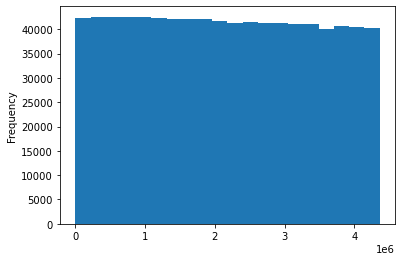

In [14]:
#оценка количества значений признака id
data_train['id'].plot(kind='hist',bins=20)

In [15]:
print('id пользователей от ', np.min(data_train['id']), 'до ', np.max(data_train['id']))

id пользователей от  2 до  4362694


<AxesSubplot:ylabel='Frequency'>

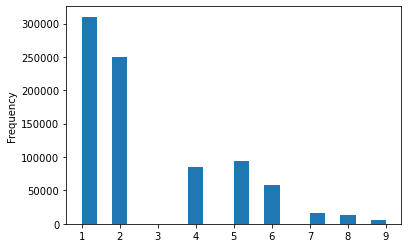

In [16]:
#оценка количества значений признака vas_id
data_train['vas_id'].plot(kind='hist',bins=20)

Во всех наблюдениях отсутствует vas_id со значением 3

In [17]:
#тренировочный датасет с дублированными id
data_train_dubles = dataset_dubles(data_train)
data_train_dubles.head(6)

id  vas_id    buy_time  target  year  month  day
14041  342     1.0  2018-11-05     0.0  2018     11    5
14042  342     2.0  2018-11-19     1.0  2018     11   19
19824  492     4.0  2018-10-08     0.0  2018     10    8
19825  492     6.0  2018-12-17     1.0  2018     12   17
22908  579     4.0  2018-11-19     1.0  2018     11   19
22909  579     6.0  2018-12-31     0.0  2018     12   31

In [18]:
data_train_dubles.id.value_counts().sort_values(ascending=False)

1144355    3
1081672    3
841367     3
3564496    3
1195576    3
          ..
2955229    2
462814     2
2752480    2
391137     2
975321     2
Name: id, Length: 25002, dtype: int64

Количество дублей не превосходит 3, значит каждому пользователю предлагали не более 3 услуг

**Вывод:** пропусков в данных нет, данные представлены с 2018-07-09 по  2018-12-31, есть повторяющиеся id и vas_id.

#### 1.3. Обзор датасета data_test <a class="anchor" id="part1.3"></a><center>

In [19]:
#Преобразование признака buy_time к нужному для работы формату
data_test = buy_time_prep(data_test)

#Построение новых признаков из buy_time
data_test = new_feats_from_buy_time(data_test)

data_test.head(2)

id  vas_id    buy_time  year  month  day
0  3130519     2.0  2019-01-21  2019      1   21
1  2000860     4.0  2019-01-21  2019      1   21

In [20]:
#Определение наличия пропусков
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71231 entries, 0 to 71230
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        71231 non-null  int64  
 1   vas_id    71231 non-null  float64
 2   buy_time  71231 non-null  object 
 3   year      71231 non-null  int64  
 4   month     71231 non-null  int64  
 5   day       71231 non-null  int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 3.3+ MB


Пропусков в данных нет

In [21]:
#Обзор статистик по признакам
data_test.describe()

id        vas_id     year    month           day
count  7.123100e+04  71231.000000  71231.0  71231.0  71231.000000
mean   2.153308e+06      3.435793   2019.0      1.0     12.862799
std    1.261506e+06      1.974035      0.0      0.0      5.118714
min    5.500000e+01      1.000000   2019.0      1.0      7.000000
25%    1.053974e+06      2.000000   2019.0      1.0      7.000000
50%    2.135540e+06      2.000000   2019.0      1.0     14.000000
75%    3.247490e+06      5.000000   2019.0      1.0     14.000000
max    4.362720e+06      9.000000   2019.0      1.0     21.000000

In [22]:
print('Данные в датасете собраны с ',np.min(data_test['buy_time']),'по', np.max(data_test['buy_time']))

Данные в датасете собраны с  2019-01-07 по 2019-01-21


Временные данные в датасетах data_train и data_test не пересекаются

In [23]:
print(f'Всего id: {len(data_test.id)}, среди них уникальных: {data_test.id.nunique()}')
print(f'Всего vas_id: {len(data_test.vas_id)}, среди них уникальных: {data_test.vas_id.nunique()}')

Всего id: 71231, среди них уникальных: 70152
Всего vas_id: 71231, среди них уникальных: 8


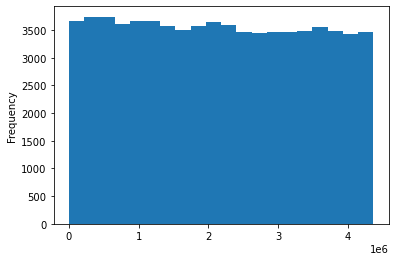

In [24]:
#оценка количества значений признака id
data_test['id'].plot(kind='hist',bins=20);

Пользователей со временем становится меньше

In [25]:
print('id пользователей от ', np.min(data_test['id']), 'до ', np.max(data_test['id']))

id пользователей от  55 до  4362720


In [26]:
#тестовый датасет с дублированными id
data_test_dubles = dataset_dubles(data_test)
data_test_dubles.head(6)

id  vas_id    buy_time  year  month  day
551     274     2.0  2019-01-14  2019      1   14
552     274     4.0  2019-01-21  2019      1   21
10677  4770     4.0  2019-01-14  2019      1   14
10676  4770     2.0  2019-01-21  2019      1   21
20241  8166     1.0  2019-01-07  2019      1    7
20242  8166     6.0  2019-01-21  2019      1   21

In [27]:
data_test_dubles.id.value_counts().sort_values(ascending=False)

2964486    3
409367     3
1320361    3
898205     3
3240429    3
          ..
198095     2
270196     2
511854     2
1990378    2
3301976    2
Name: id, Length: 1060, dtype: int64

Количество дублей не превосходит 3, значит каждому пользователю предлагали не более 3 услуг

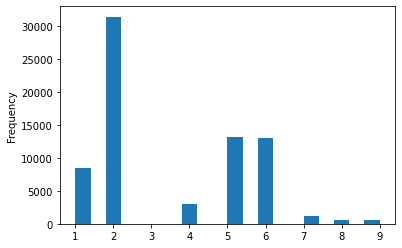

In [28]:
#оценка количества значений признака vas_id
data_test['vas_id'].plot(kind='hist',bins=20);

Во всех наблюдениях отсутствует vas_id со значением 3

**Вывод:** пропусков в данных нет, данные представлены с 2019-01-07 по 2019-01-21, есть повторяющиеся id и vas_id.

#### 1.4. Обзор датасета features <a class="anchor" id="part1.4"></a><center>

In [29]:
#Преобразование признака buy_time к нужному для работы формату
features = buy_time_prep(features)
features.head(2)

id    buy_time          0           1           2           3  \
0  2013026  2018-07-16  18.910029   46.980888    4.969214   -1.386798   
1  2014722  2018-10-15  36.690029  152.400888  448.069214  563.833202   

            4          5         6          7  ...         243         244  \
0    3.791754  -14.01179 -16.08618 -65.076097  ... -977.373846 -613.770792   
1  463.841754  568.99821 -16.08618 -53.216097  ... -891.373846 -544.770792   

         245        246         247        248       249        250      251  \
0 -25.996269 -37.630448 -301.747724 -25.832889 -0.694428 -12.175933 -0.45614   
1 -20.996269  48.369552   80.252276 -13.832889 -0.694428  -1.175933 -0.45614   

   252  
0  0.0  
1  0.0  

[2 rows x 255 columns]

In [30]:
print('Данные в датасете собраны с ',np.min(features['buy_time']),'по', np.max(features['buy_time']))

Данные в датасете собраны с  2018-07-09 по 2019-01-21


Временной промежуток датасета с признаками равен сумме временных промежутков тренировочного и тестового датасетов

In [31]:
#определяем пропуски
features.isnull().values.any()

False

Пропусков в данных нет

In [32]:
#статистики по признакам
features.describe()

id             0             1             2             3  \
count  4.512528e+06  4.512528e+06  4.512528e+06  4.512528e+06  4.512528e+06   
mean   2.182050e+06  1.510807e-12 -2.081808e-12  1.542454e-12 -1.108011e-12   
std    1.259141e+06  2.243294e+02  4.376565e+02  2.391380e+02  5.055830e+02   
min    0.000000e+00 -2.482300e+03 -1.594119e+03 -3.058041e+03 -8.200307e+03   
25%    1.092104e+06 -9.679997e+01 -2.094491e+02 -1.107408e+02 -2.431568e+02   
50%    2.181854e+06 -8.496997e+01 -6.072911e+01 -8.532079e+01 -7.942680e+01   
75%    3.273591e+06  1.177003e+01  1.180409e+02  2.737921e+01  1.256532e+02   
max    4.362738e+06  2.117307e+05  2.126061e+05  2.117168e+05  2.133577e+05   

                  4             5             6             7             8  \
count  4.512528e+06  4.512528e+06  4.512528e+06  4.512528e+06  4.512528e+06   
mean  -4.426932e-13 -1.245362e-12 -3.596164e-12  2.141398e-12  3.085549e-13   
std    2.548790e+02  5.677062e+02  1.555055e+02  3.191605e+02  1.016246e+02   
min   -3.063458e+03 -8.221412e+03 -2.401586e+03 -8.023561e+02 -1.184754e+03   
25%   -1.161582e+02 -2.602818e+02 -1.608618e+01 -6.507610e+01 -6.783660e+00   
50%   -8.783825e+01 -9.378179e+01 -1.608618e+01 -6.507610e+01 -6.783660e+00   
75%    2.912175e+01  1.189582e+02 -1.608618e+01 -5.914610e+01 -6.783660e+00   
max    2.120953e+05  2.137205e+05  2.118114e+05  2.125836e+05  1.276018e+05   

       ...           243           244           245           246  \
count  ...  4.512528e+06  4.512528e+06  4.512528e+06  4.512528e+06   
mean   ... -6.196210e-11 -6.047050e-12  1.866054e-11  2.936815e-12   
std    ...  3.209118e+03  2.237688e+03  9.486413e+02  2.983910e+02   
min    ... -9.773738e+02 -6.137708e+02 -2.599627e+01 -3.763045e+01   
25%    ... -9.773738e+02 -6.137708e+02 -2.599627e+01 -3.763045e+01   
50%    ... -9.593738e+02 -6.137708e+02 -2.599627e+01 -3.763045e+01   
75%    ... -4.853738e+02 -4.077708e+02 -2.499627e+01 -3.363045e+01   
max    ...  2.876716e+05  2.071552e+05  9.801580e+05  5.429037e+04   

                247           248           249           250           251  \
count  4.512528e+06  4.512528e+06  4.512528e+06  4.512528e+06  4.512528e+06   
mean  -2.192149e-11  3.117540e-12  2.965892e-13 -9.962012e-13 -1.454828e-14   
std    1.358662e+03  2.935884e+02  1.473285e+01  1.906053e+02  6.995322e+00   
min   -3.067477e+02 -2.583289e+01 -6.944285e-01 -1.217593e+01 -4.561399e-01   
25%   -3.057477e+02 -2.583289e+01 -6.944285e-01 -1.217593e+01 -4.561399e-01   
50%   -2.397477e+02 -2.383289e+01 -6.944285e-01 -1.217593e+01 -4.561399e-01   
75%   -7.774772e+01 -1.083289e+01 -6.944285e-01 -9.175933e+00 -4.561399e-01   
max    3.106113e+05  2.053172e+05  1.892331e+04  1.385528e+05  9.489544e+03   

                252  
count  4.512528e+06  
mean   2.559718e-01  
std    1.277607e+00  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    1.000000e+00  
max    1.743000e+03  

[8 rows x 254 columns]

In [33]:
print(f'Всего id: {len(features.id)}, среди них уникальных: {features.id.nunique()}')

Всего id: 4512528, среди них уникальных: 4362739


In [34]:
if features.id.nunique() > data_train.id.nunique() + data_test.id.nunique():
    print(f'В тренировочном и тестовом датасетах представлены подвыборки объема {data_train.id.nunique()} и {data_test.id.nunique()} соответственно из выборки объема {features.id.nunique()} пользователей')

В тренировочном и тестовом датасетах представлены подвыборки объема 806613 и 70152 соответственно из выборки объема 4362739 пользователей


In [35]:
#датасет с дублированными id
features_dubles = dataset_dubles(features)
features_dubles.head(6)

id    buy_time           0            1           2            3  \
702950   46  2018-08-27  -96.799971    15.550888 -110.740786    49.363202   
3790832  46  2018-10-15  -96.799971  -408.179112  -81.080786  -426.886798   
1027878  63  2018-07-23  504.740029  1330.840888  519.619214  1388.833202   
1276326  63  2018-11-19   34.410029   204.150888   20.469214   232.073202   
100527   71  2018-09-17  -96.799971  -408.179112 -102.260786  -414.156798   
2944225  71  2018-09-24  -79.009971  -390.389112  -92.950786  -404.846798   

                  4           5          6            7  ...           243  \
702950  -116.158246    28.25821  -16.08618   -65.076097  ...    813.626154   
3790832  -75.908246  -435.28179  -16.08618   -65.076097  ...  13177.626154   
1027878  514.201754  1367.72821  532.21382  1201.013903  ...   -943.373846   
1276326   15.051754   210.96821  -16.08618   -59.146097  ...   -313.373846   
100527  -107.678246  -435.26179  -16.08618   -65.076097  ...   -977.373846   
2944225  -98.368246  -425.95179   -6.76618   -55.756097  ...   -851.373846   

                 244        245        246         247        248       249  \
702950   -174.770792 -24.996269 -31.630448  -92.747724 -13.832889 -0.694428   
3790832  3432.229208 -20.996269 -32.630448  -34.747724  -4.832889 -0.694428   
1027878  -613.770792 -25.996269 -26.630448  106.252276 -25.832889 -0.694428   
1276326  -266.770792 -25.996269  -8.630448  790.252276 -23.832889 -0.694428   
100527   -613.770792 -25.996269 -37.630448 -296.747724 -25.832889 -0.694428   
2944225  -492.770792 -25.996269 -37.630448 -285.747724 -20.832889 -0.694428   

               250      251  252  
702950   -0.175933 -0.45614  0.0  
3790832  -4.175933 -0.45614  0.0  
1027878 -12.175933 -0.45614  0.0  
1276326 -12.175933 -0.45614  0.0  
100527  -12.175933 -0.45614  0.0  
2944225  -7.175933 -0.45614  0.0  

[6 rows x 255 columns]

In [36]:
features_dubles.id.value_counts().sort_values(ascending=False)

1576962    2
975068     2
2641930    2
2643979    2
2138132    2
          ..
2631675    2
3196903    2
98256      2
3246031    2
2101246    2
Name: id, Length: 149789, dtype: int64

Количество дублей не превосходит 2, значит каждому пользователю предлагали не более 2 услуг

**Вывод:** пропусков в данных нет, данные представлены с 2018-07-09 по 2019-01-21 (содержат временные периоды  data_train и data_test), есть повторяющиеся id и vas_id.

#### 1.5. Обработка признаков датасета features <a class="anchor" id="part1.5"></a><center>

In [37]:
#уникальные значения признаков
features_nunique = features.apply(lambda x: x.nunique(dropna=False))
features_nunique.shape

(255,)

In [38]:
#удаляем из списка признаков 'id' и 'buy_time'
features_nunique = features_nunique[2:]
features_nunique

0       83983
1      182103
2       99296
3      213950
4      105516
        ...  
248      4789
249       534
250      3328
251       434
252        94
Length: 253, dtype: int64

<AxesSubplot:title={'center':'Распределение уникальных значений признаков'}>

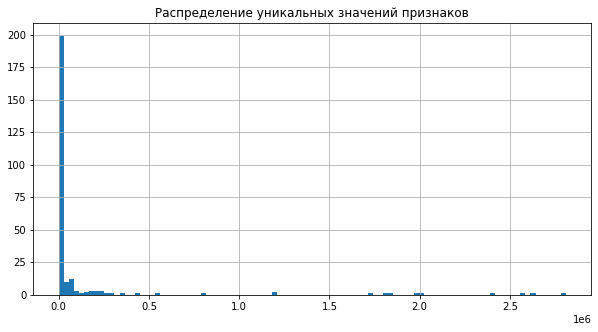

In [39]:
plt.title("Распределение уникальных значений признаков")
features_nunique.hist(bins=100, figsize=(10, 5))

Признаки с большим количеством значений -- вещественные, с малым -- категориальные/целые/бинарные

In [40]:
#названия всех признаков
features_all = set(features_nunique.index.tolist())
len(features_all)

253

**Константные признаки** (1 уникальное значение, поэтому в дальнейшем не будем их использовать)

In [41]:
features_const = set(features_nunique[features_nunique == 1].index.tolist())
print(f'Константные признаки: {features_const}')
print(f'Количество: {len(features_const)}')

Константные признаки: {'139', '81', '85', '75', '203'}
Количество: 5


In [42]:
features_other = features_all - features_const
len(features_other)

248

**Бинарные признаки** (0 или 1)

In [43]:
features_binary = set(features.loc[:, features_other].columns[(
                      (features.loc[:, features_other].max() == 1) & \
                      (features.loc[:, features_other].min() == 0) & \
                      (features.loc[:, features_other].isnull().sum() == 0))])
print(f'Бинарные признаки: {features_binary}')
print(f'Количество: {len(features_binary)}')

Бинарные признаки: set()
Количество: 0


In [44]:
features_other = features_other - features_binary
len(features_other)

248

**Категориальные признаки** (считаем категориальными признаками те, у которых количество значений <=10)

In [45]:
features_categorical = set(features_nunique.loc[features_other][features_nunique.loc[features_other] <= 10].index.tolist())
print(f'Категориальные признаки: {features_categorical}')
print(f'Количество: {len(features_categorical)}')

Категориальные признаки: {'154', '194', '197', '27', '199', '192', '216', '132', '206', '198', '196', '57', '26', '195', '32', '201', '205', '200', '31', '202', '30', '131', '29', '33', '204'}
Количество: 25


**Остальные признаки вещественные**

In [46]:
features_numeric = features_other - features_categorical
print(f'Вещественные признаки: {features_numeric}')
print(f'Количество: {len(features_numeric)}')

Вещественные признаки: {'58', '89', '39', '48', '106', '164', '70', '64', '78', '243', '234', '25', '91', '1', '43', '165', '237', '238', '179', '16', '37', '185', '79', '5', '236', '224', '84', '171', '24', '53', '173', '213', '11', '77', '109', '107', '251', '167', '41', '133', '140', '157', '222', '158', '230', '0', '104', '187', '219', '105', '211', '93', '181', '150', '221', '3', '96', '102', '136', '170', '208', '242', '49', '76', '252', '244', '240', '101', '123', '90', '182', '103', '250', '233', '111', '159', '13', '172', '112', '8', '127', '215', '121', '249', '175', '115', '38', '71', '54', '45', '134', '184', '61', '209', '248', '98', '223', '119', '239', '188', '65', '169', '86', '10', '6', '168', '4', '151', '22', '74', '67', '161', '108', '130', '87', '147', '152', '246', '128', '92', '241', '2', '34', '72', '210', '83', '129', '23', '217', '21', '50', '51', '66', '142', '191', '14', '17', '47', '144', '117', '155', '113', '44', '225', '42', '69', '228', '59', '227', '18

**Итого по признакам**

In [47]:
print(f'Всeго признаков {len(features_all)}, из них:')
print(f'константных: {len(features_const)}')
print(f'бинарных: {len(features_binary)}')
print(f'категориальных: {len(features_categorical)}')
print(f'вещественных: {len(features_numeric)}')
print('P.S. Из рассмотрения были удалены признаки id и buy_time')

Всeго признаков 253, из них:
константных: 5
бинарных: 0
категориальных: 25
вещественных: 223
P.S. Из рассмотрения были удалены признаки id и buy_time


Убираем из рассмотрения константные признаки (не несут в себе никакой информации)

In [48]:
features = features.drop(features_const,axis=1)
features

id    buy_time          0           1           2           3  \
0        2013026  2018-07-16  18.910029   46.980888    4.969214   -1.386798   
1        2014722  2018-10-15  36.690029  152.400888  448.069214  563.833202   
2        2015199  2018-12-24 -67.019971  157.050888  -63.180786  178.103202   
3        2021765  2018-08-13   7.010029  150.200888   -6.930786  216.213202   
4        2027465  2018-08-06 -90.439971  134.220888 -104.380786  153.643202   
...          ...         ...        ...         ...         ...         ...   
4512523  3521417  2019-01-21 -96.799971  -29.579112  -94.900786  -40.506798   
4512524  3521563  2019-01-14  30.530029 -150.929112   16.589214  -34.046798   
4512525  3521574  2019-01-07 -96.799971 -396.439112 -110.740786 -447.776798   
4512526  3521640  2019-01-14  38.030029 -152.519112   24.089214 -175.956798   
4512527  3521702  2019-01-21   9.780029 -145.769112   -4.160786 -198.376798   

                  4          5         6          7  ...          243  \
0          3.791754  -14.01179 -16.08618 -65.076097  ...  -977.373846   
1        463.841754  568.99821 -16.08618 -53.216097  ...  -891.373846   
2        -68.598246  156.99821   3.51382  25.183903  ...  -977.373846   
3         76.621754  351.84821 -16.08618 -65.076097  ...  -973.373846   
4       -109.798246  132.53821 -16.08618 -65.076097  ...  1643.626154   
...             ...        ...       ...        ...  ...          ...   
4512523 -100.318246  -61.61179 -16.08618 -65.076097  ...  1133.626154   
4512524   11.171754  -55.15179 -16.08618 -65.076097  ...  -680.373846   
4512525 -116.158246 -468.88179 -16.08618 -65.076097  ...  -977.373846   
4512526   18.671754 -197.06179 -16.08618 -65.076097  ...  2242.626154   
4512527   -9.578246 -219.48179 -16.08618 -65.076097  ...  -975.373846   

                 244         245        246           247        248  \
0        -613.770792  -25.996269 -37.630448   -301.747724 -25.832889   
1        -544.770792  -20.996269  48.369552     80.252276 -13.832889   
2        -613.770792  -12.996269 -37.630448  10829.252276 -25.832889   
3        -613.770792  -23.996269 -37.630448   -205.747724 -24.832889   
4        2007.229208  206.003731 -21.630448   6667.252276  92.167111   
...              ...         ...        ...           ...        ...   
4512523  1497.229208  -25.996269 -36.630448   -126.747724 -25.832889   
4512524  -316.770792  -25.996269 -35.630448   -296.747724 -25.832889   
4512525  -613.770792  -25.996269 -37.630448   -306.747724 -25.832889   
4512526  2528.229208  -25.996269  90.369552    -26.747724 -18.832889   
4512527  -612.770792  -25.996269 -35.630448   -288.747724 -20.832889   

              249        250       251  252  
0       -0.694428 -12.175933  -0.45614  0.0  
1       -0.694428  -1.175933  -0.45614  0.0  
2       -0.694428 -12.175933  -0.45614  0.0  
3       -0.694428 -11.175933  -0.45614  1.0  
4       -0.694428  49.824067  47.54386  0.0  
...           ...        ...       ...  ...  
4512523 -0.694428 -12.175933  -0.45614  0.0  
4512524 -0.694428 -12.175933  -0.45614  0.0  
4512525 -0.694428 -12.175933  -0.45614  0.0  
4512526 -0.694428 -12.175933   0.54386  0.0  
4512527 -0.694428 -12.175933  -0.45614  0.0  

[4512528 rows x 250 columns]

**Вывод:** определены типы признаков датасета features, удалены константные признаки.

### 2. Построение модели классификации  <a class="anchor" id="part2"></a><center>

#### 2.1. Merge датасетов train и features <a class="anchor" id="part2.1"></a><center>

In [49]:
%%time

X_nearest = pd.merge_asof(data_train.sort_values(by=['id']), 
                       features.sort_values(by=['id']), 
                       on='id', 
                       by='buy_time', 
                       direction='nearest')
X_nearest.head(2)

Wall time: 20min 19s


id  vas_id    buy_time  target  year  month  day          0           1  \
0   2     2.0  2018-12-24     0.0  2018     12   24 -96.799971  229.530888   
1   4     1.0  2018-08-06     0.0  2018      8    6 -52.309971 -225.139112   

            2  ...          243          244        245        246  \
0 -110.740786  ...  2300.626154  1492.229208 -21.996269 -35.630448   
1  -66.250786  ...  -977.373846  -613.770792 -25.996269 -37.630448   

          247        248       249        250      251  252  
0  368.252276  11.167111  7.305572 -12.175933 -0.45614  0.0  
1 -304.747724 -25.832889 -0.694428 -12.175933 -0.45614  0.0  

[2 rows x 255 columns]

In [50]:
X_nearest.isnull().sum()

id          0
vas_id      0
buy_time    0
target      0
year        0
           ..
248         0
249         0
250         0
251         0
252         0
Length: 255, dtype: int64

**Вывод:** датасет data_train объединен с датасетом features, пропусков в получившемся датасете нет.

#### 2.2. Отбор признаков <a class="anchor" id="part2.2"></a><center>

In [55]:
#отбираем признаки
X = X_nearest.drop(['target'], axis=1)
y = X_nearest['target']
X.head(2)

id  vas_id    buy_time  year  month  day          0           1  \
0   2     2.0  2018-12-24  2018     12   24 -96.799971  229.530888   
1   4     1.0  2018-08-06  2018      8    6 -52.309971 -225.139112   

            2           3  ...          243          244        245  \
0 -110.740786  305.723202  ...  2300.626154  1492.229208 -21.996269   
1  -66.250786 -258.246798  ...  -977.373846  -613.770792 -25.996269   

         246         247        248       249        250      251  252  
0 -35.630448  368.252276  11.167111  7.305572 -12.175933 -0.45614  0.0  
1 -37.630448 -304.747724 -25.832889 -0.694428 -12.175933 -0.45614  0.0  

[2 rows x 254 columns]

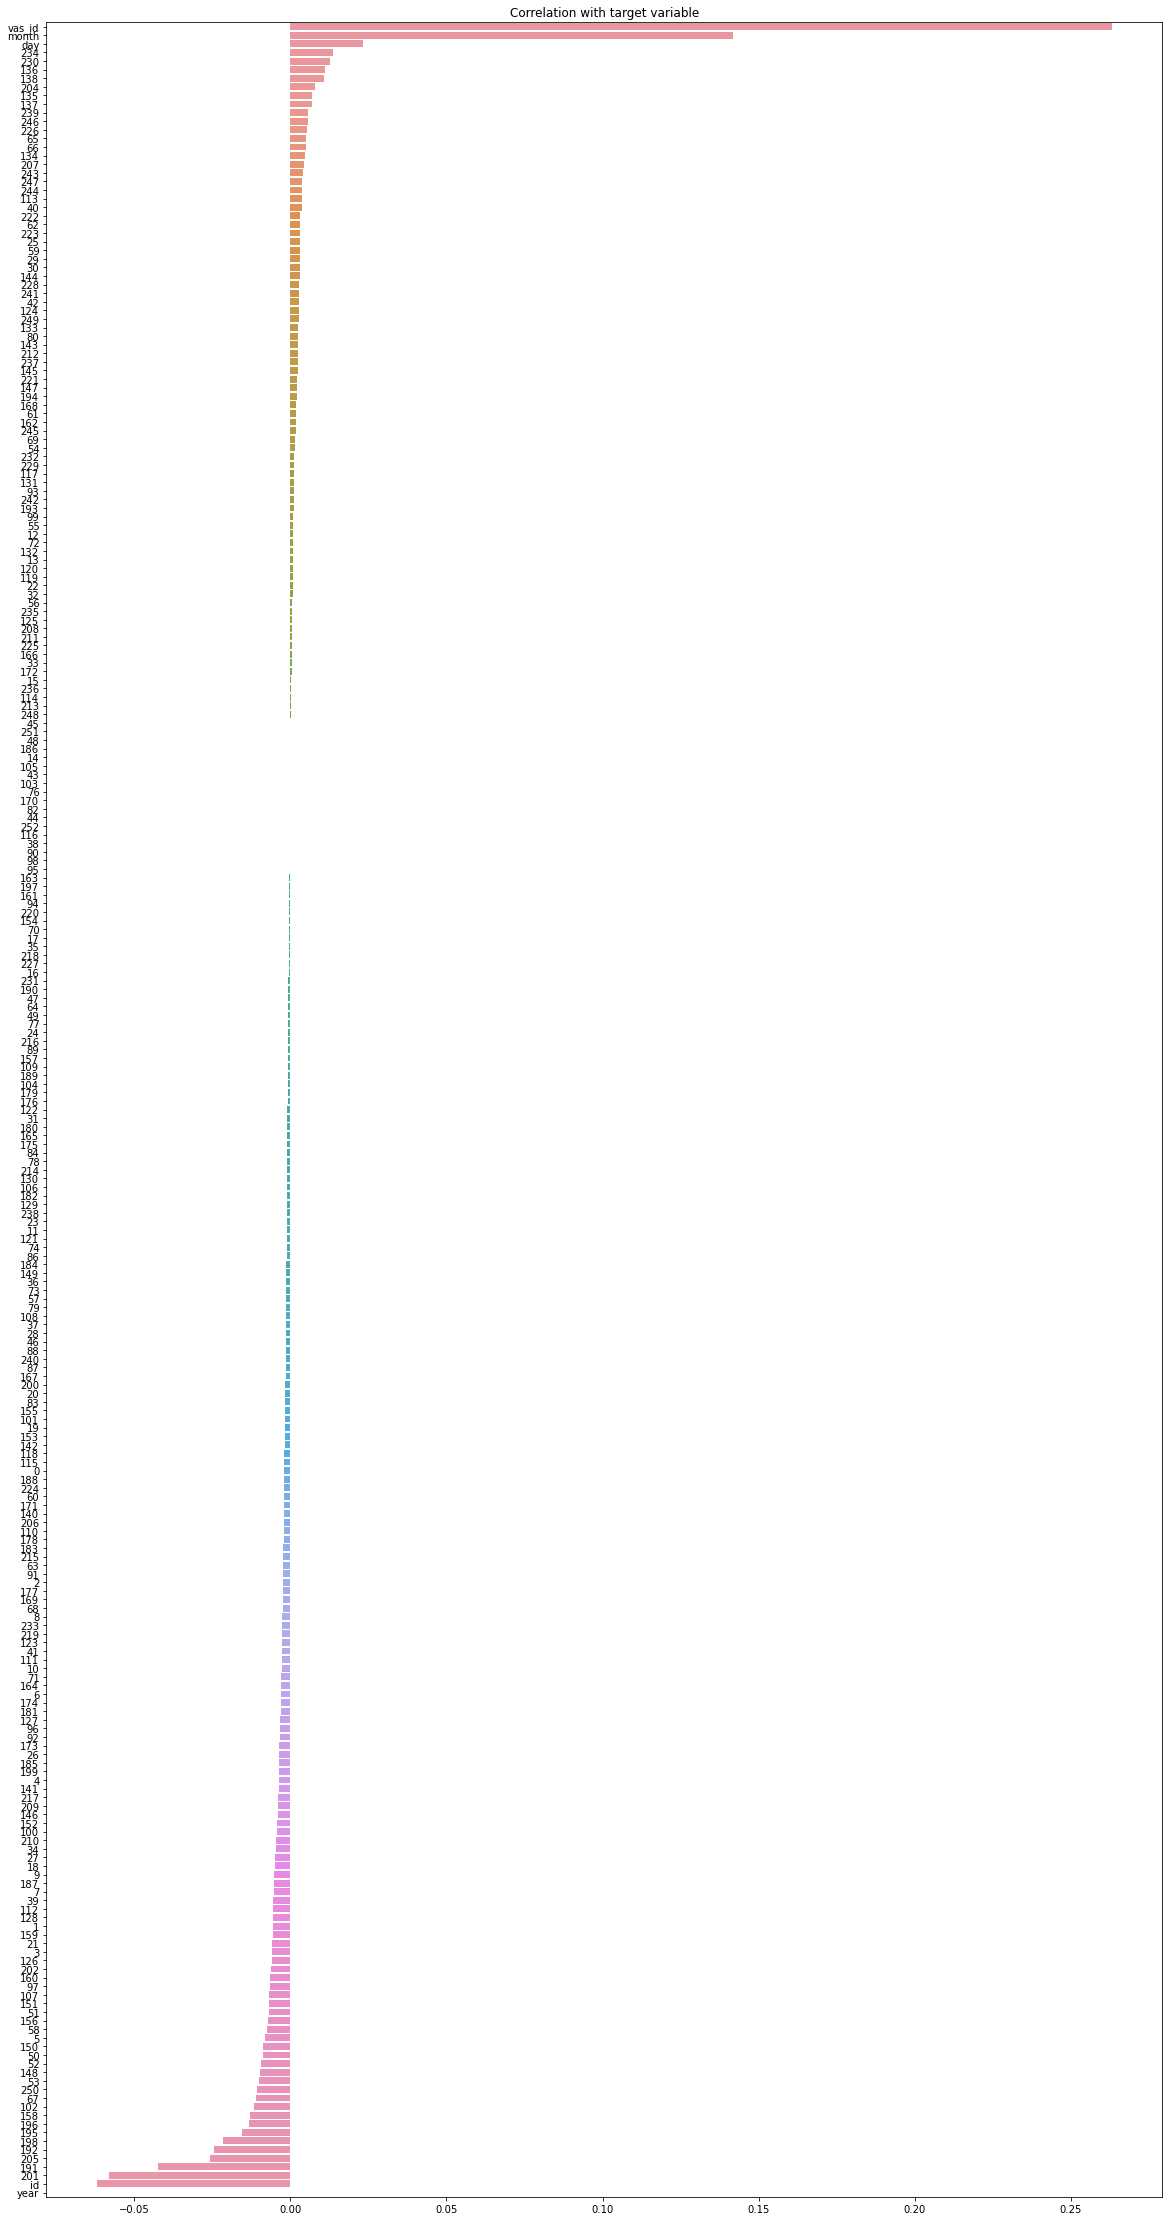

In [56]:
# Строим матрицу корреляции целевой переменной с признаками тренировочного датасета
corr_with_target = pd.concat([X, y], axis=1).corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(20, 40))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Корреляция признаков с целевой переменной очень слабая

Оценка признака feature = 58


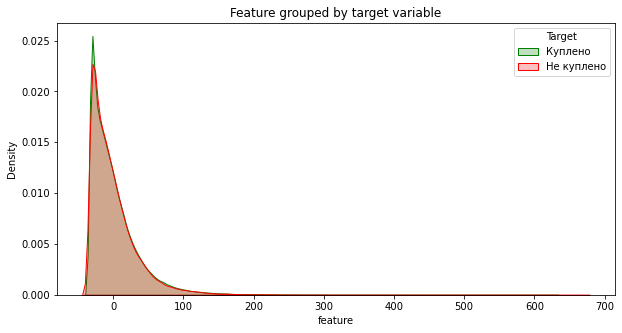

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.7973100543022156, pvalue=0.0)


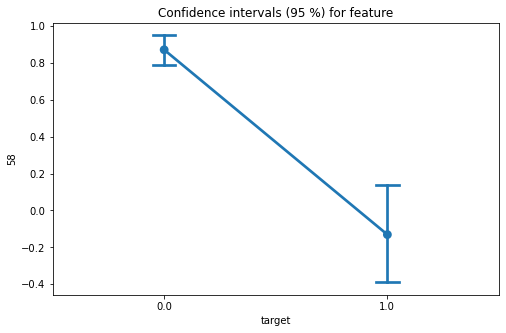

Оценка признака feature = 89


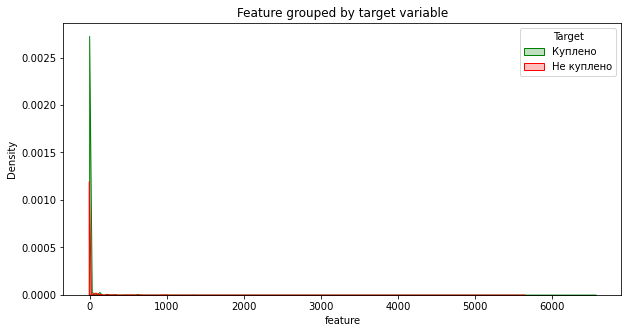

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.010298192501068115, pvalue=0.0)


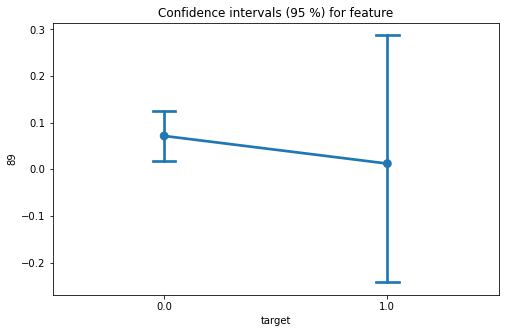

Оценка признака feature = 39


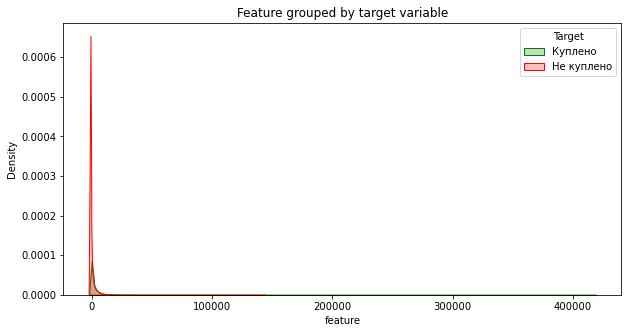

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.30666840076446533, pvalue=0.0)


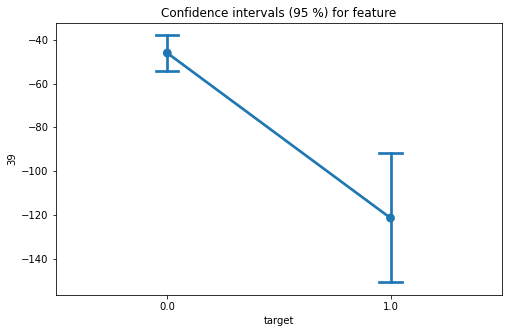

Оценка признака feature = 48


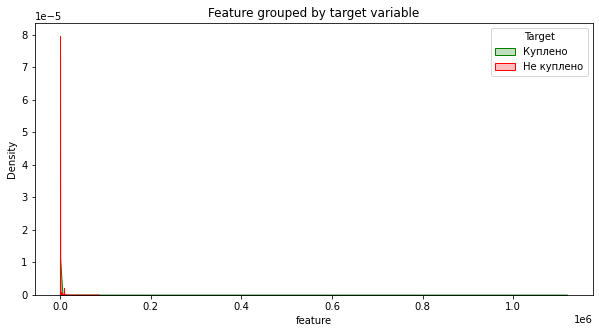

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0010852217674255371, pvalue=0.0)


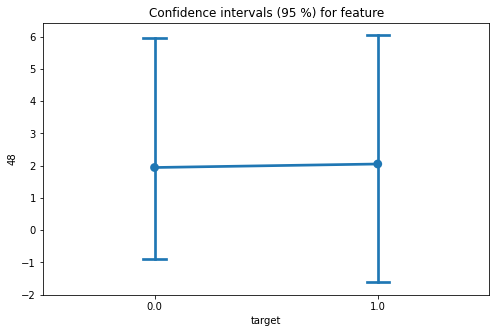

Оценка признака feature = 106


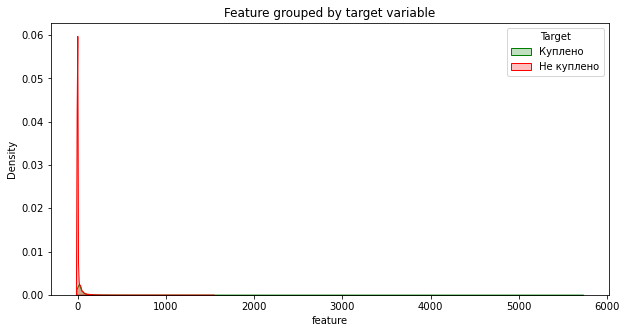

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.22961914539337158, pvalue=0.0)


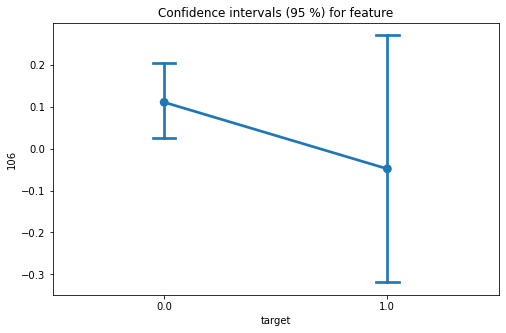

Оценка признака feature = 164


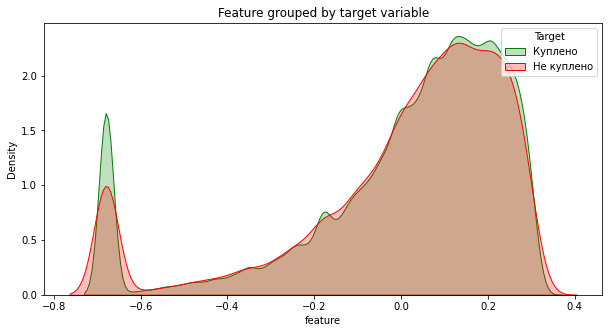

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.8443357944488525, pvalue=0.0)


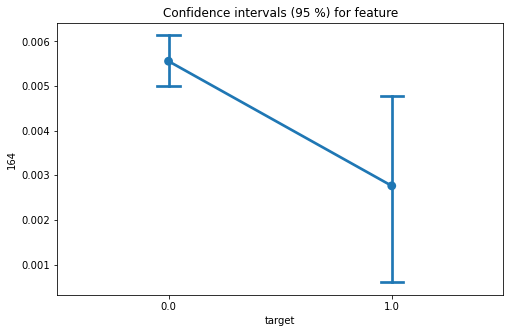

Оценка признака feature = 70


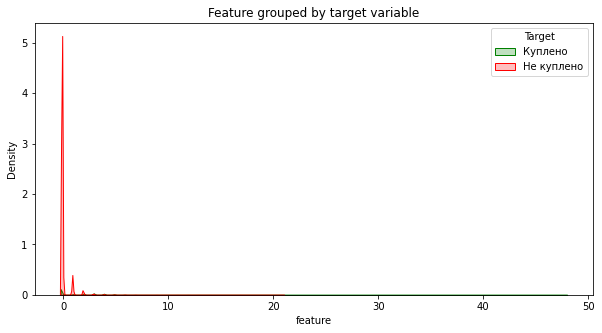

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.24171864986419678, pvalue=0.0)


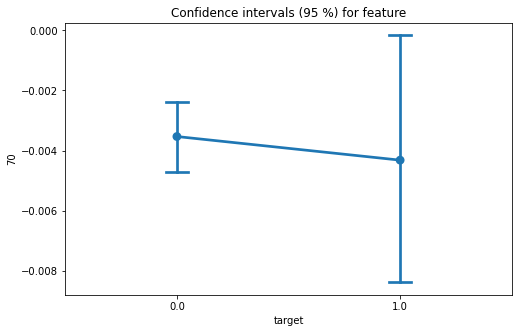

Оценка признака feature = 64


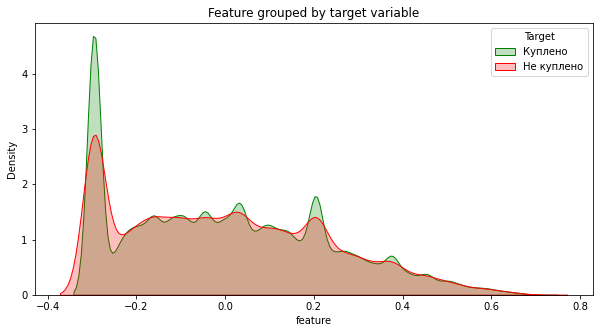

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.9457603693008423, pvalue=0.0)


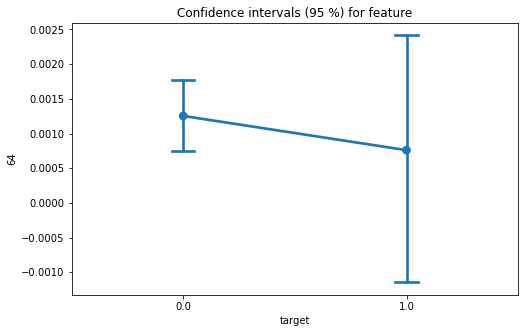

Оценка признака feature = 78


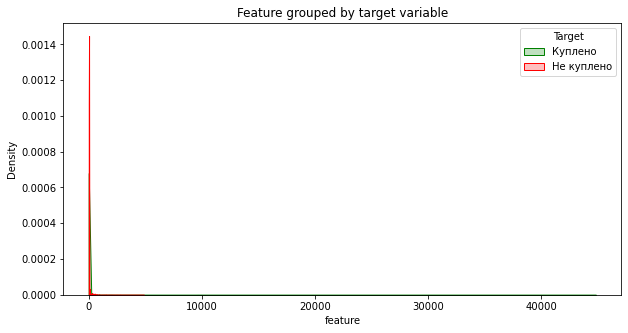

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0025959014892578125, pvalue=0.0)


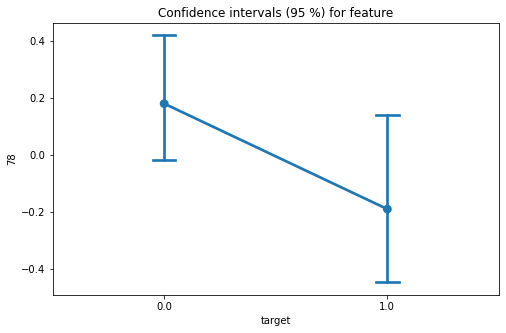

Оценка признака feature = 243


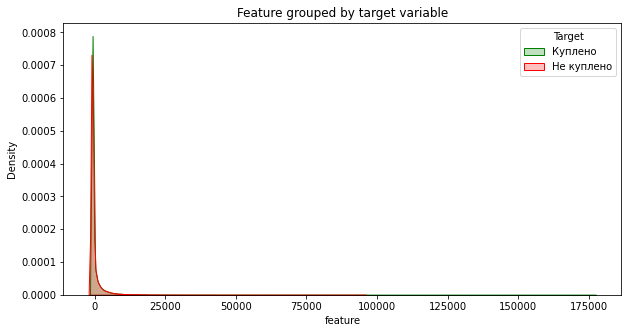

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.30591410398483276, pvalue=0.0)


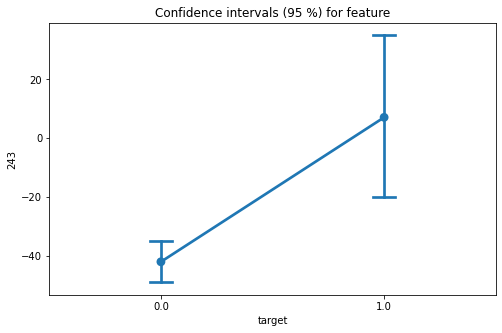

Оценка признака feature = 234


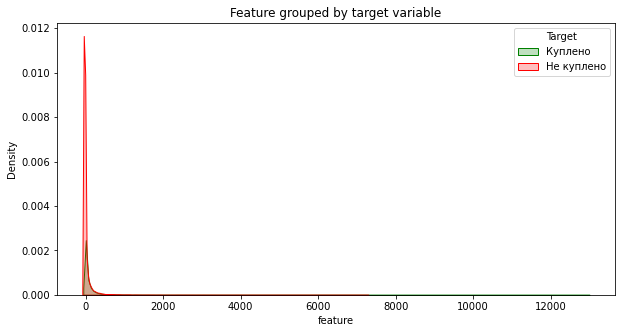

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.24868649244308472, pvalue=0.0)


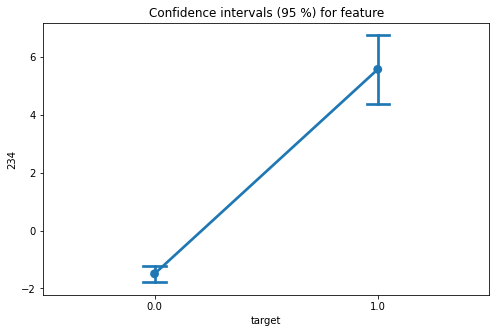

Оценка признака feature = 25


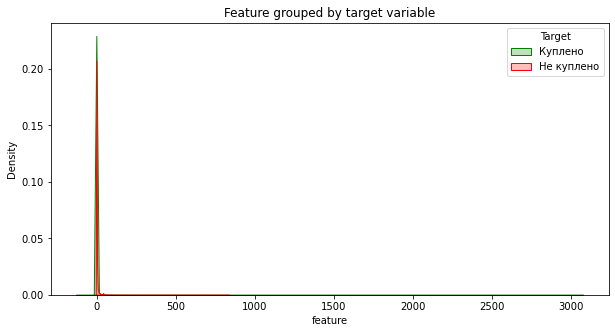

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.11623257398605347, pvalue=0.0)


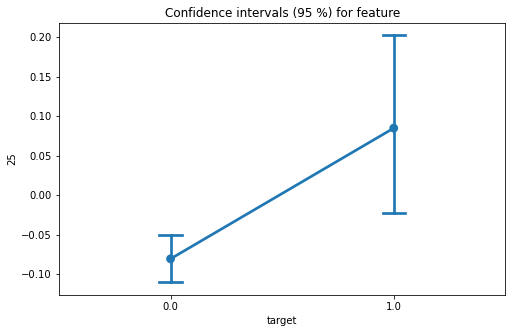

Оценка признака feature = 91


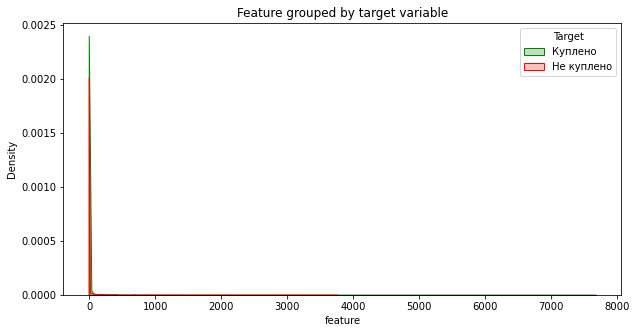

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.00764232873916626, pvalue=0.0)


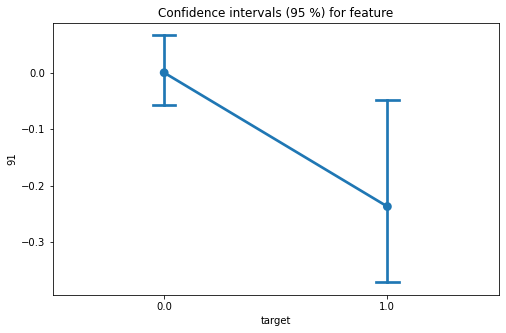

Оценка признака feature = 1


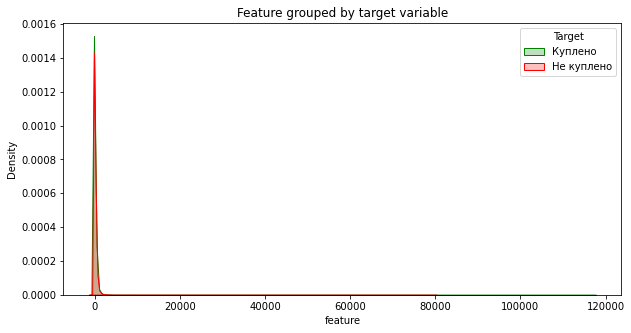

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.5222781896591187, pvalue=0.0)


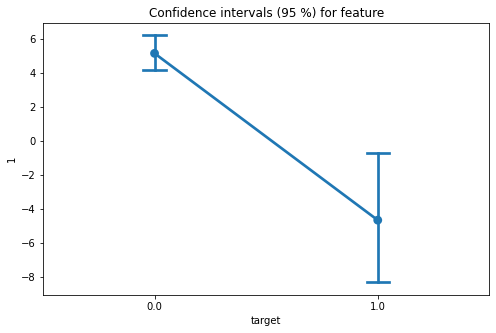

Оценка признака feature = 43


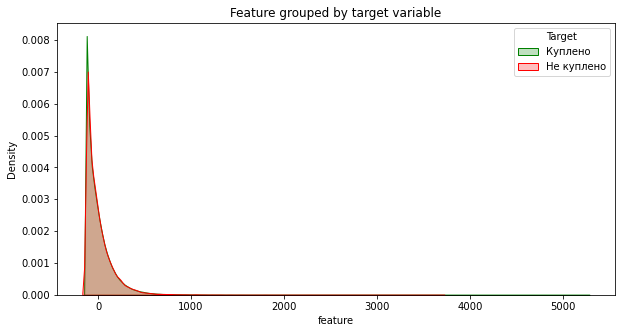

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.7397060394287109, pvalue=0.0)


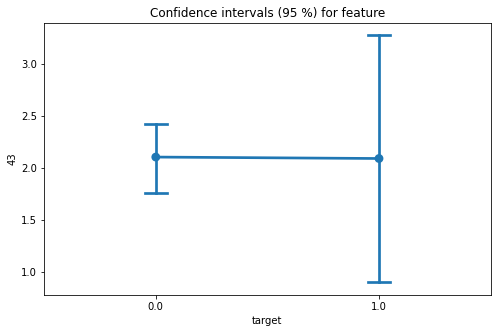

Оценка признака feature = 165


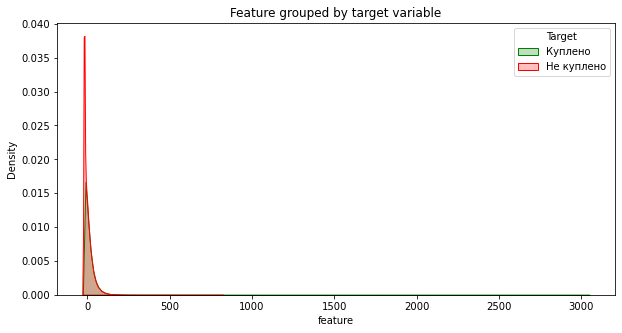

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.695084810256958, pvalue=0.0)


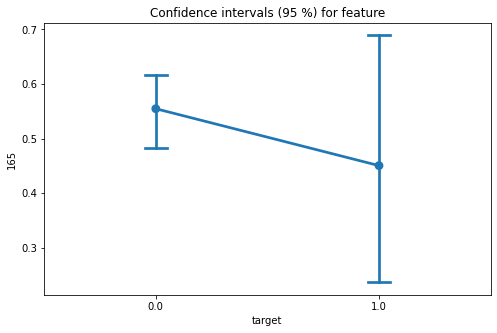

Оценка признака feature = 237


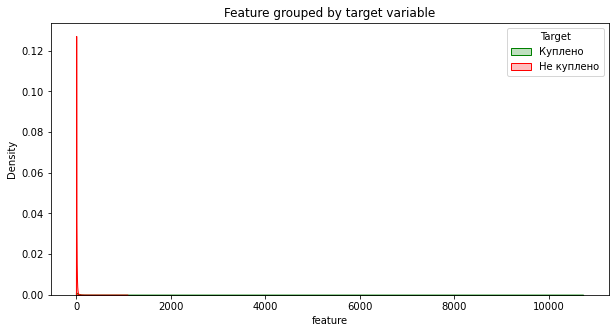

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.10941582918167114, pvalue=0.0)


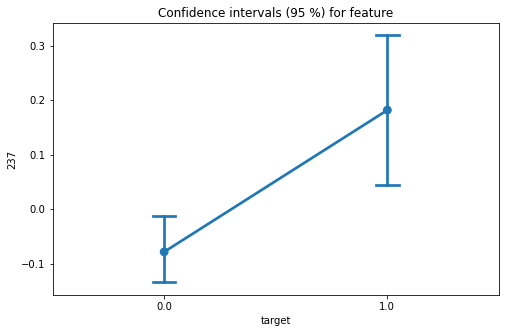

Оценка признака feature = 238


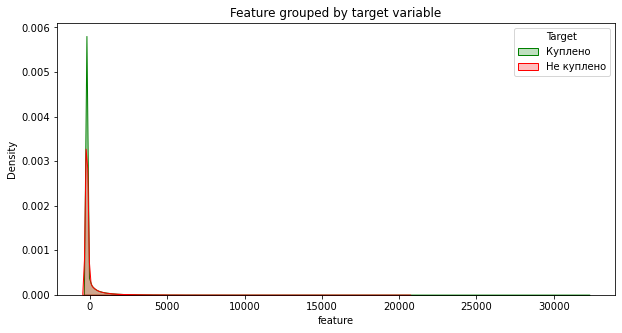

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.3612494468688965, pvalue=0.0)


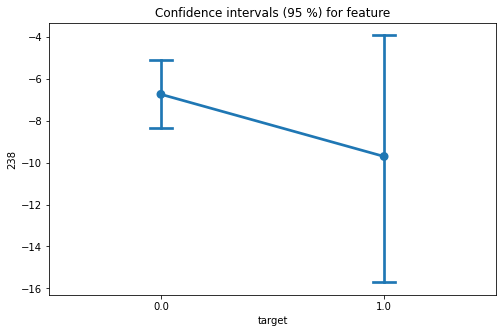

Оценка признака feature = 179


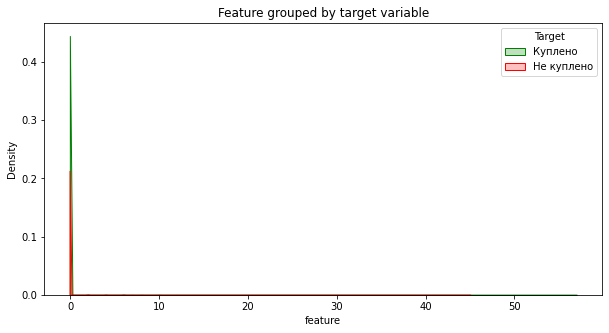

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0018464922904968262, pvalue=0.0)


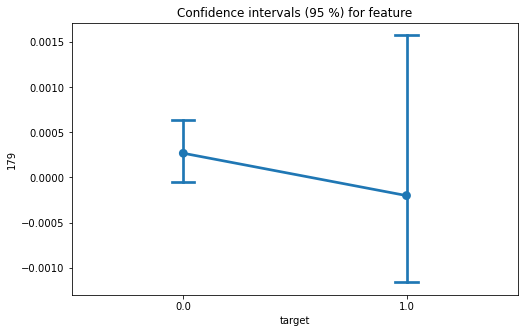

Оценка признака feature = 16


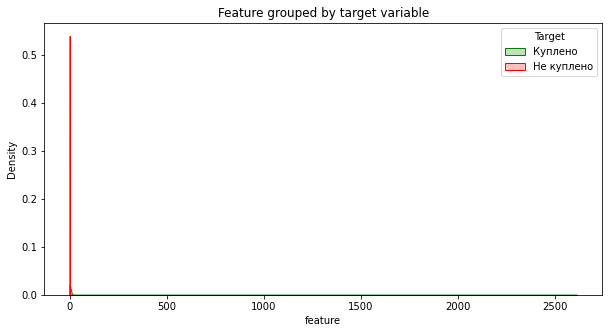

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=9.489059448242188e-05, pvalue=0.0)


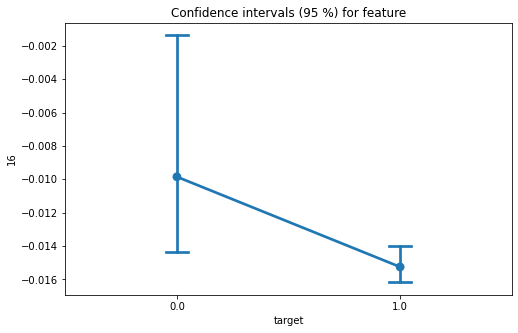

Оценка признака feature = 37


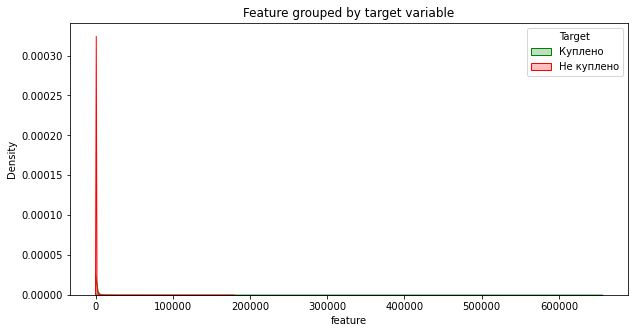

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.054033875465393066, pvalue=0.0)


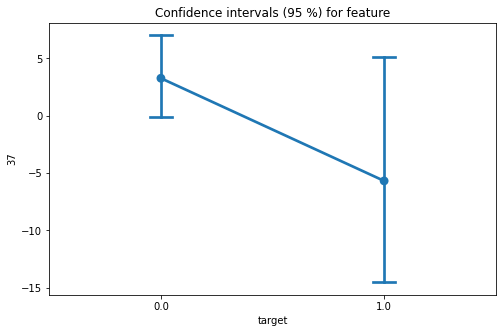

Оценка признака feature = 185


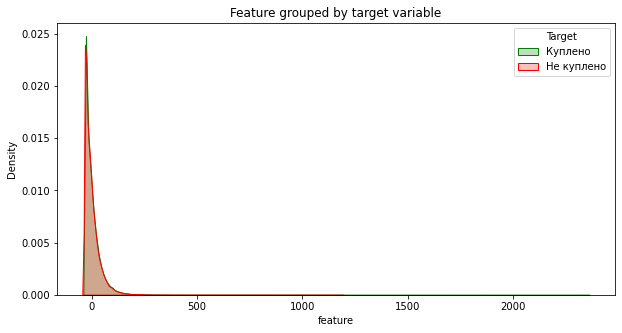

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.7202445268630981, pvalue=0.0)


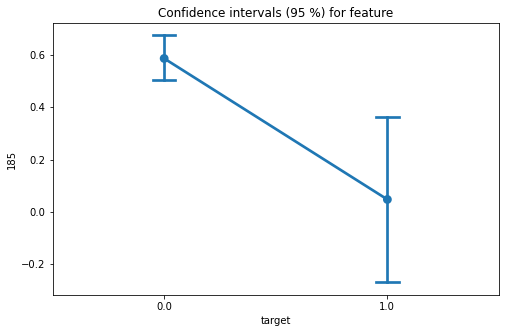

Оценка признака feature = 79


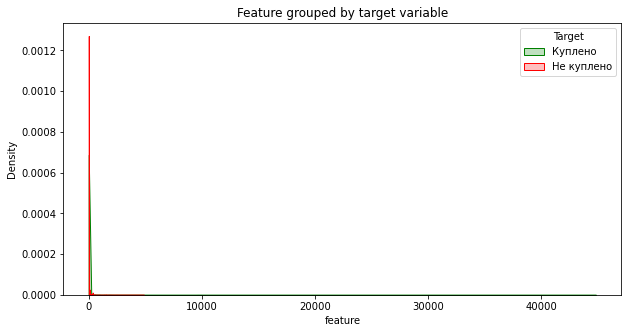

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0020142197608947754, pvalue=0.0)


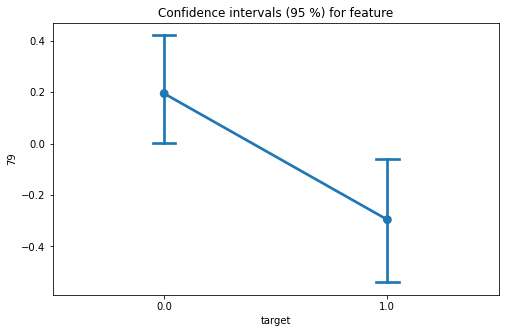

Оценка признака feature = 5


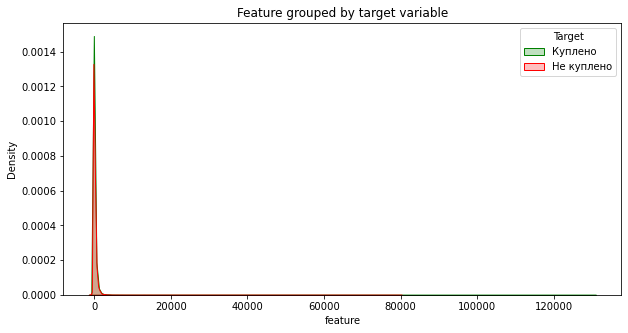

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.48917990922927856, pvalue=0.0)


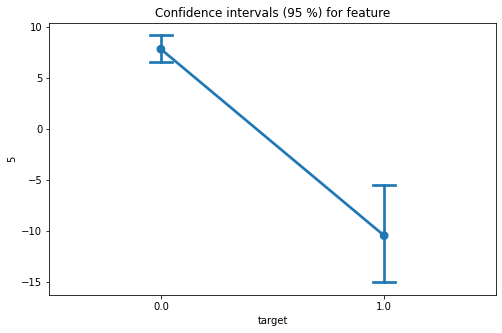

Оценка признака feature = 236


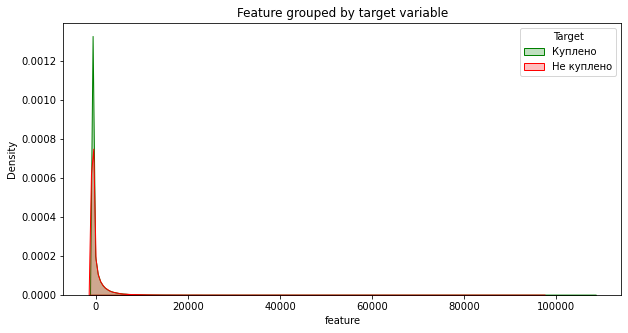

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.42370736598968506, pvalue=0.0)


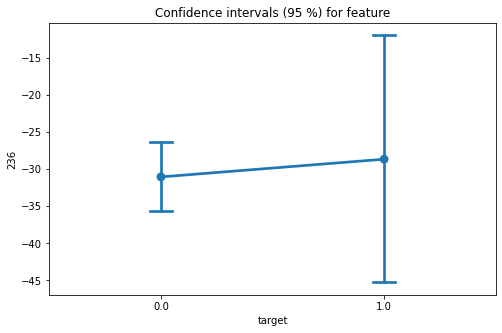

Оценка признака feature = 224


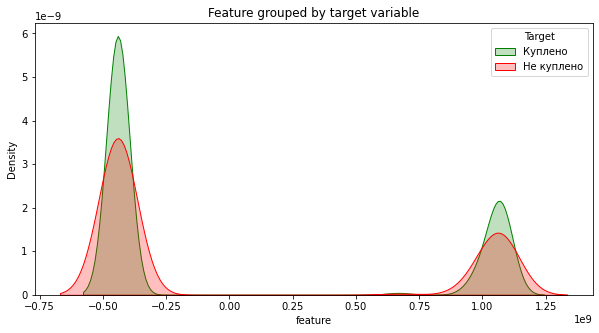

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.5950738787651062, pvalue=0.0)


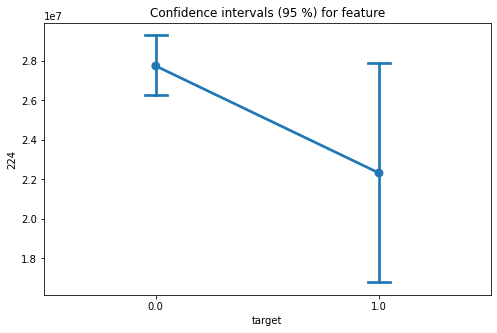

Оценка признака feature = 84


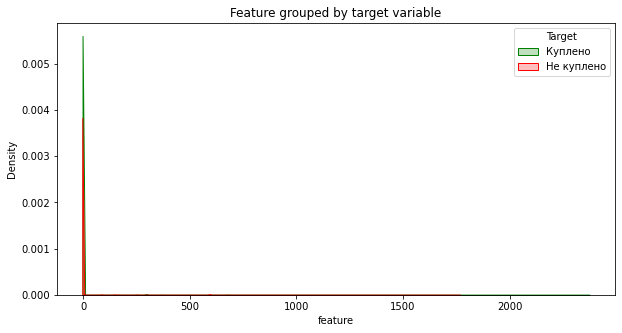

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0025110840797424316, pvalue=0.0)


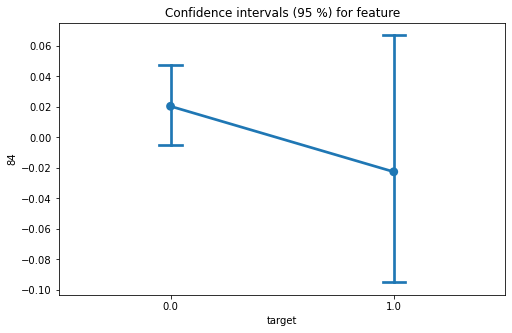

Оценка признака feature = 171


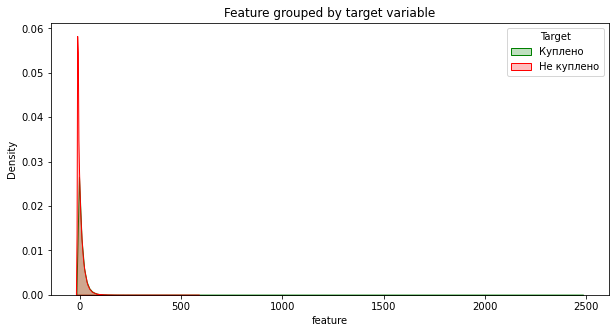

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.6708114147186279, pvalue=0.0)


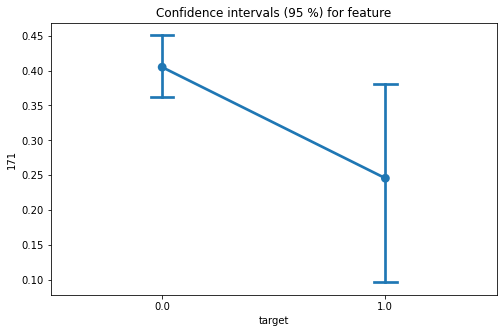

Оценка признака feature = 24


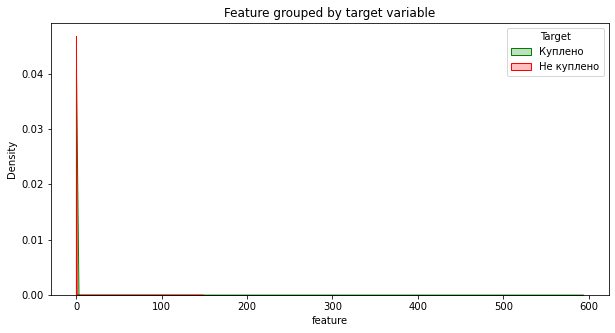

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0005137920379638672, pvalue=0.0)


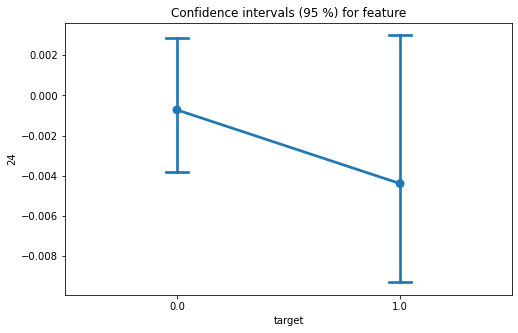

Оценка признака feature = 53


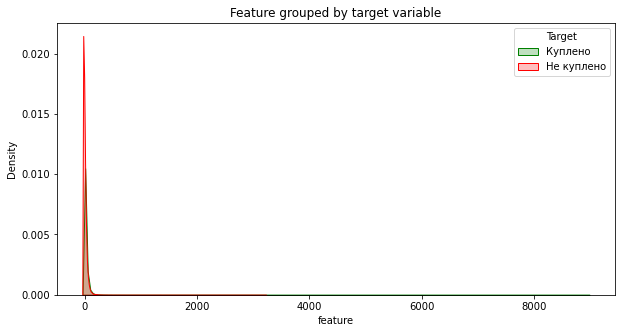

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.4516289234161377, pvalue=0.0)


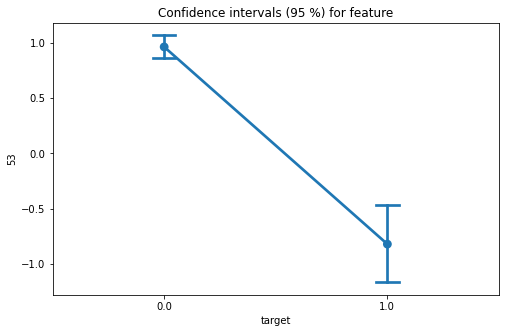

Оценка признака feature = 173


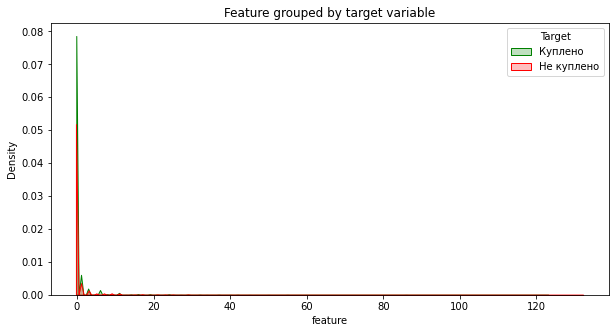

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.015907585620880127, pvalue=0.0)


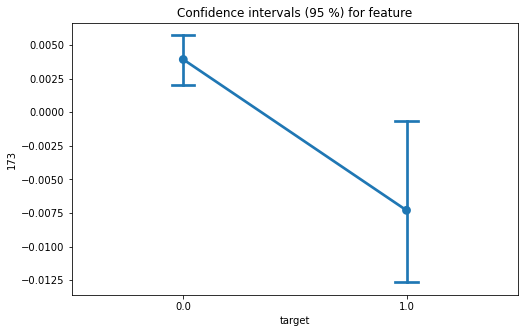

Оценка признака feature = 213


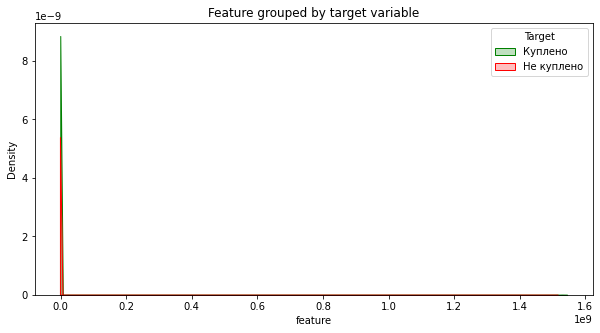

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0004691481590270996, pvalue=0.0)


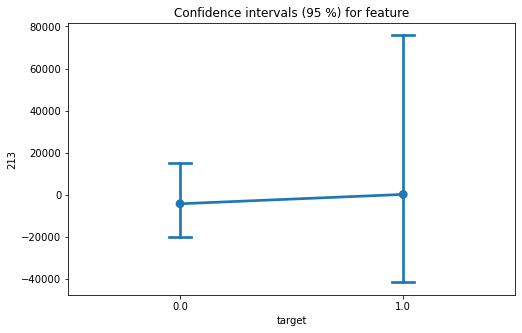

Оценка признака feature = 11


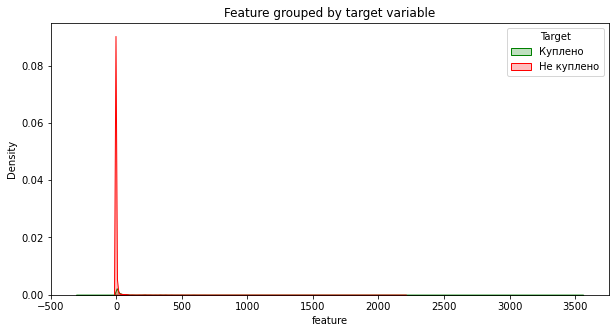

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.08052802085876465, pvalue=0.0)


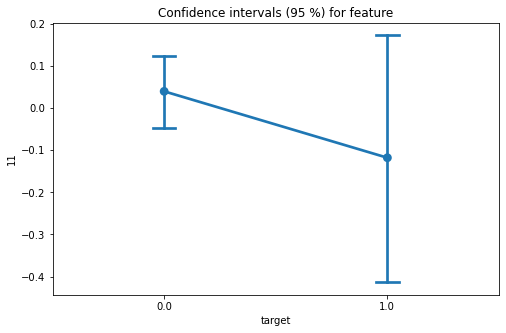

Оценка признака feature = 77


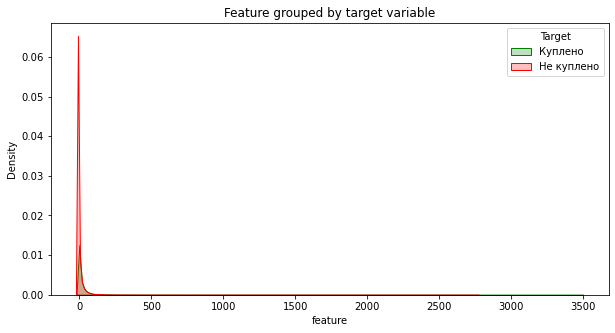

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.25487393140792847, pvalue=0.0)


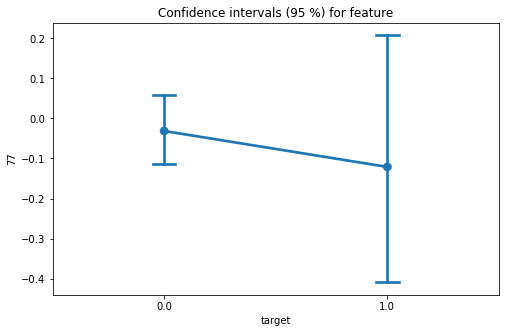

Оценка признака feature = 109


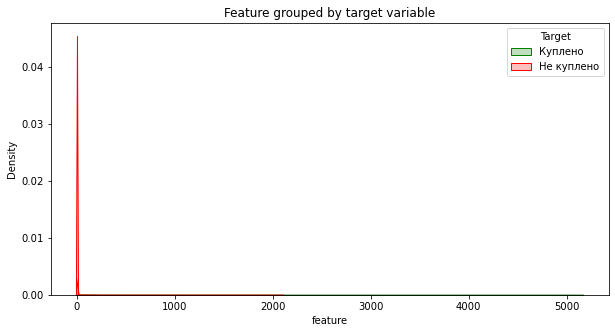

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.020608961582183838, pvalue=0.0)


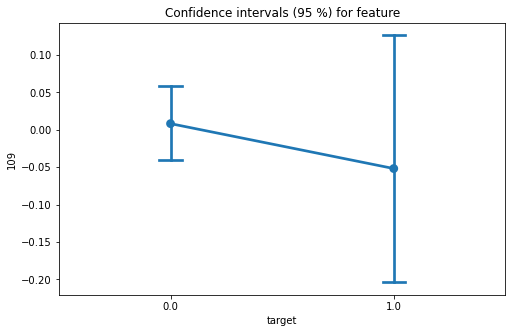

Оценка признака feature = 107


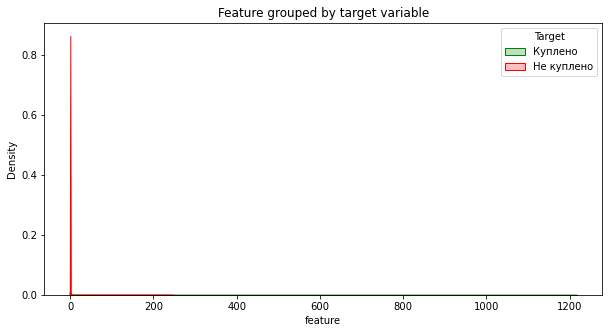

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.013823449611663818, pvalue=0.0)


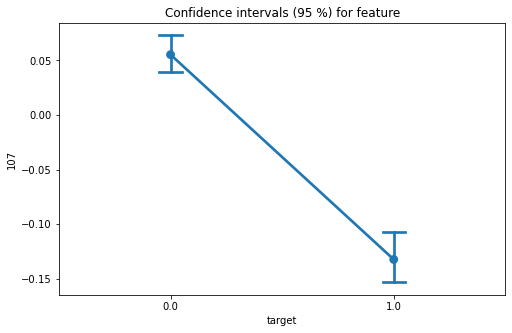

Оценка признака feature = 251


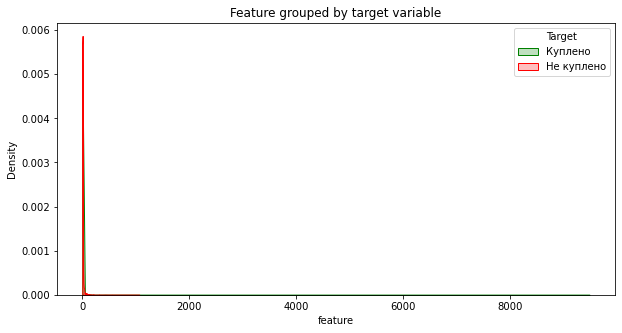

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.011870145797729492, pvalue=0.0)


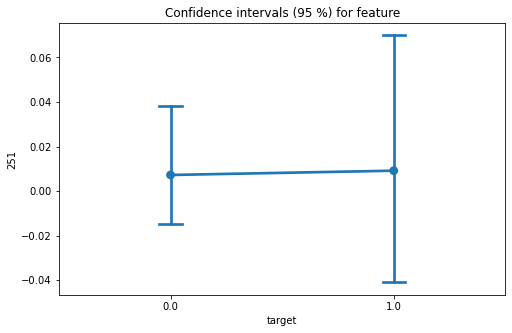

Оценка признака feature = 167


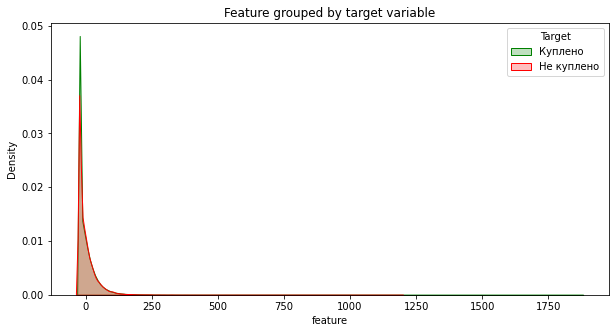

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.6784431338310242, pvalue=0.0)


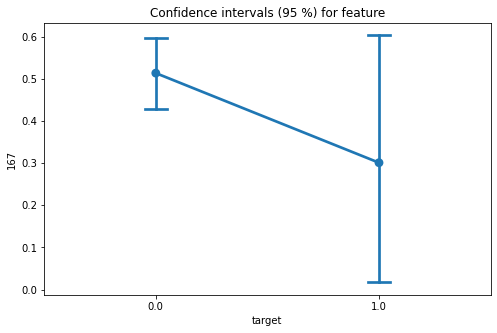

Оценка признака feature = 41


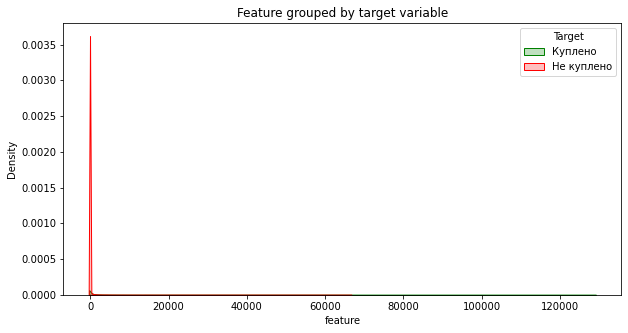

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.06085234880447388, pvalue=0.0)


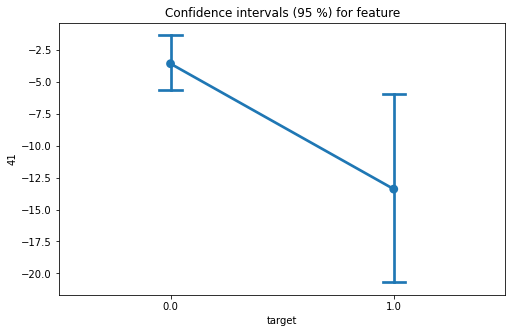

Оценка признака feature = 133


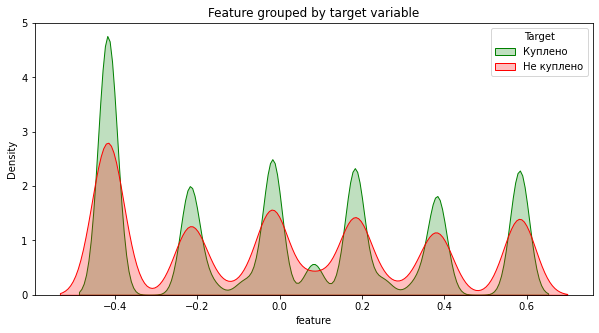

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.8945146799087524, pvalue=0.0)


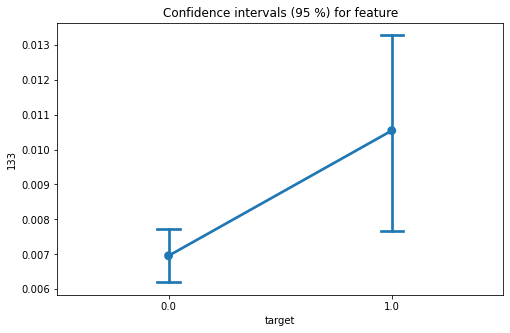

Оценка признака feature = 140


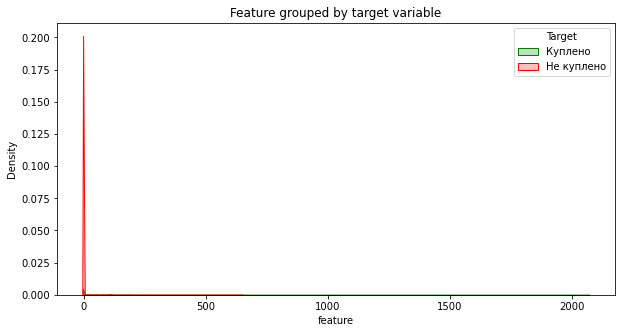

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.06648999452590942, pvalue=0.0)


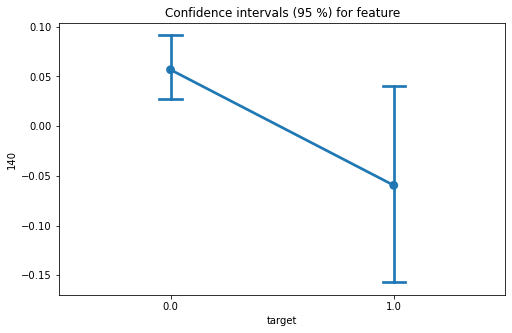

Оценка признака feature = 157


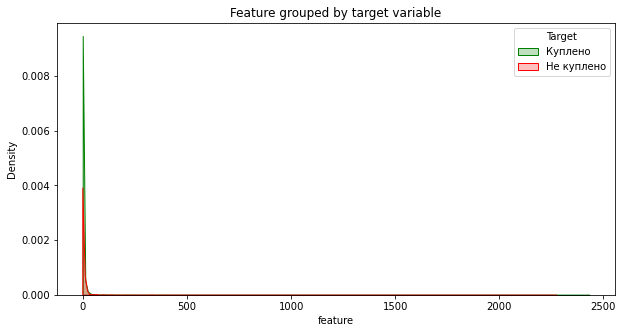

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.012864470481872559, pvalue=0.0)


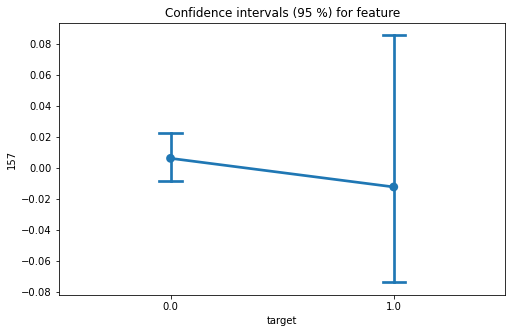

Оценка признака feature = 222


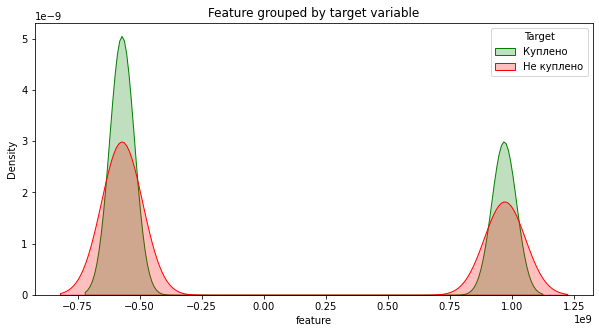

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.6169599294662476, pvalue=0.0)


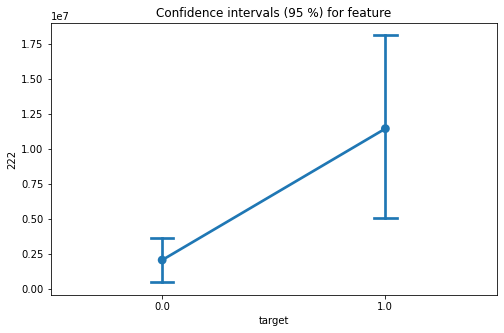

Оценка признака feature = 230


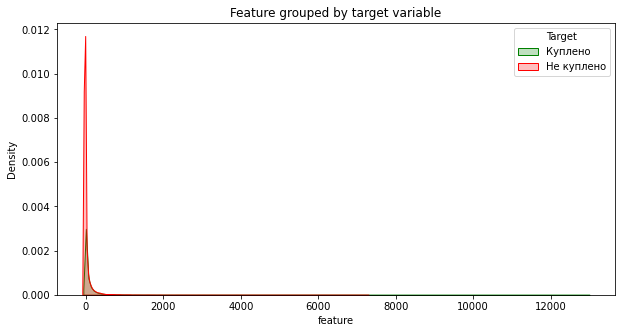

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.259803831577301, pvalue=0.0)


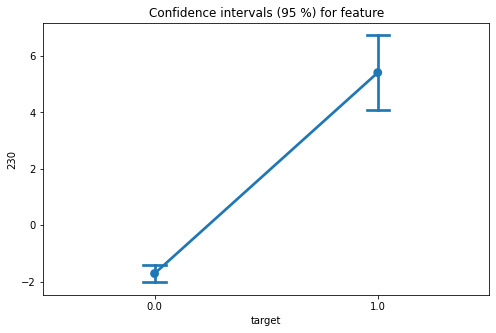

Оценка признака feature = 158


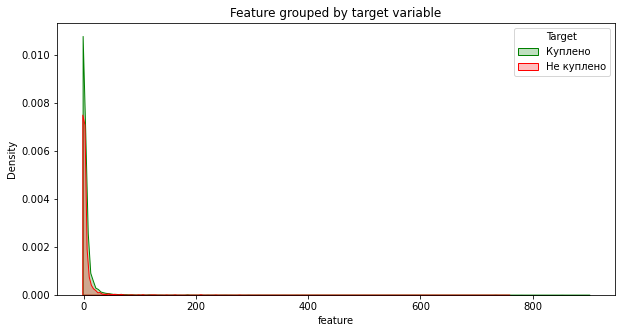

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0682138204574585, pvalue=0.0)


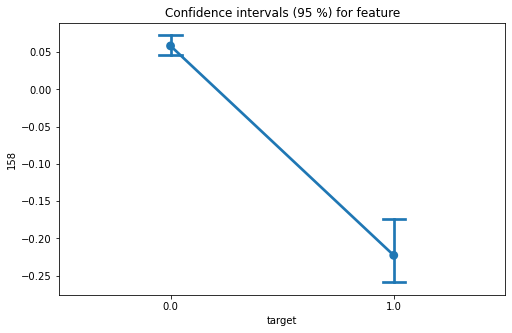

Оценка признака feature = 0


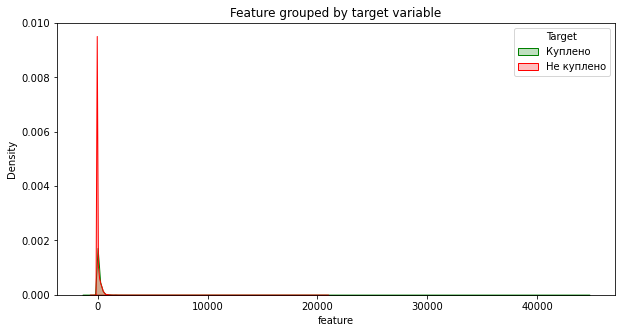

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.44828641414642334, pvalue=0.0)


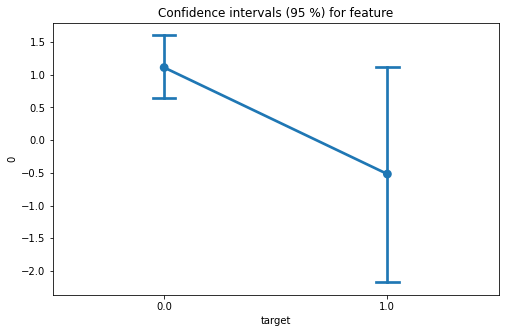

Оценка признака feature = 104


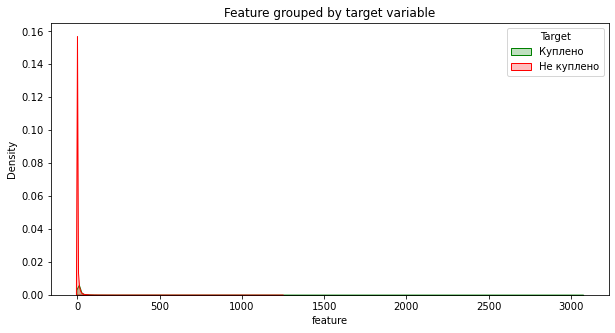

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.19883674383163452, pvalue=0.0)


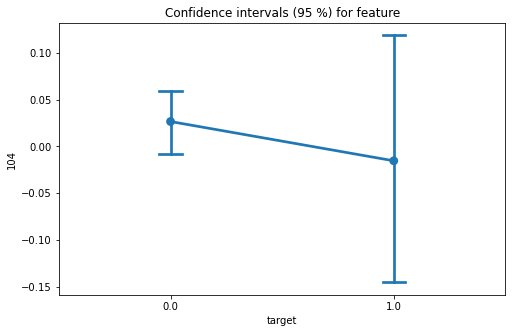

Оценка признака feature = 187


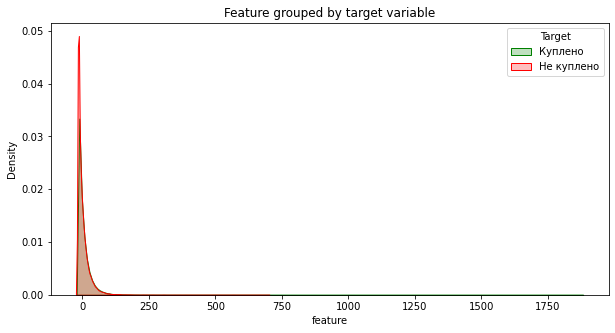

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.6332687139511108, pvalue=0.0)


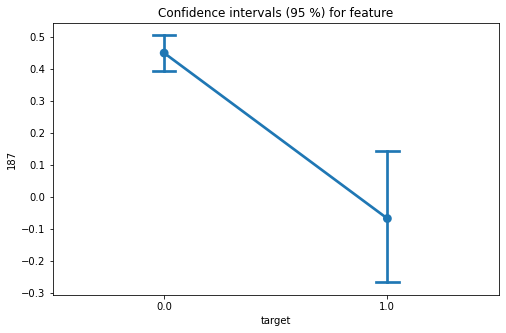

Оценка признака feature = 219


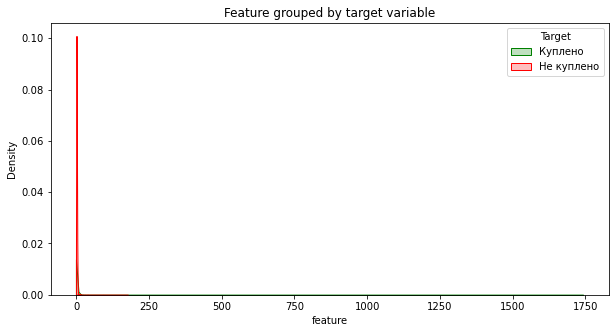

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0933956503868103, pvalue=0.0)


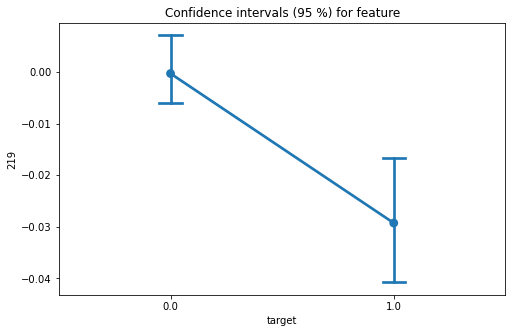

Оценка признака feature = 105


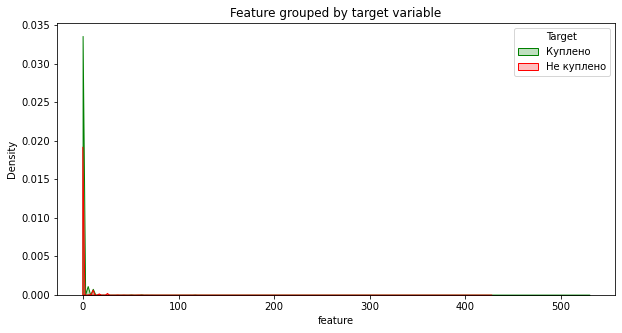

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.005734860897064209, pvalue=0.0)


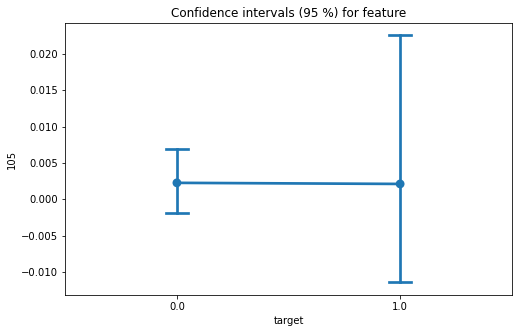

Оценка признака feature = 211


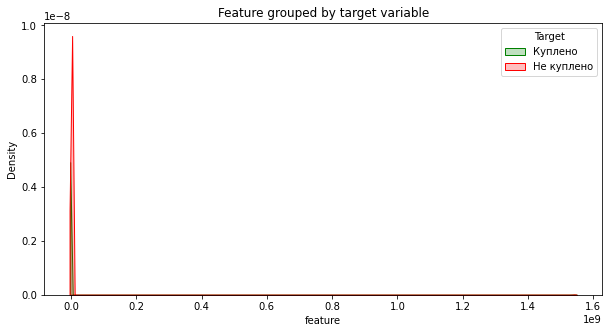

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0009127259254455566, pvalue=0.0)


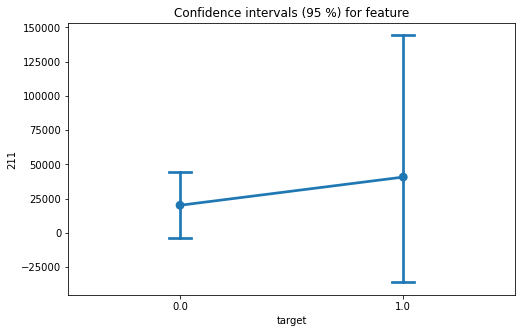

Оценка признака feature = id


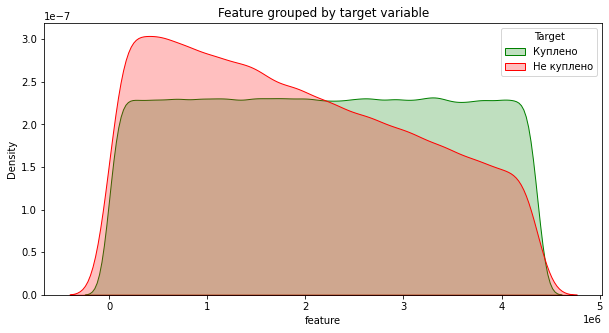

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.9555305242538452, pvalue=0.0)


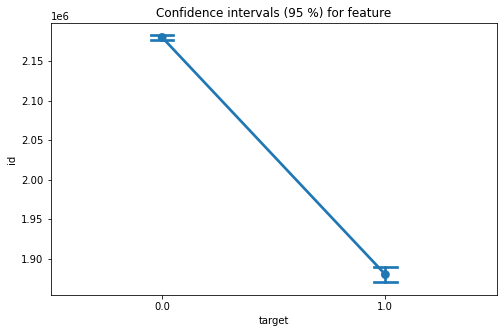

Оценка признака feature = 93


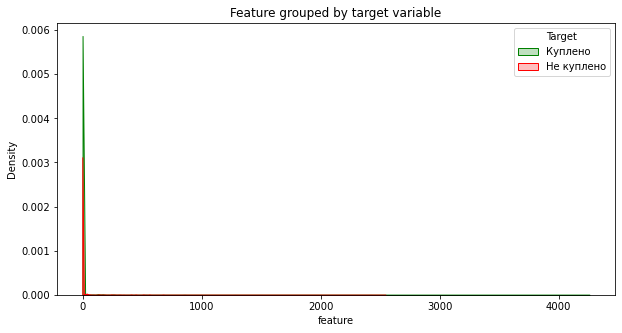

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.003274261951446533, pvalue=0.0)


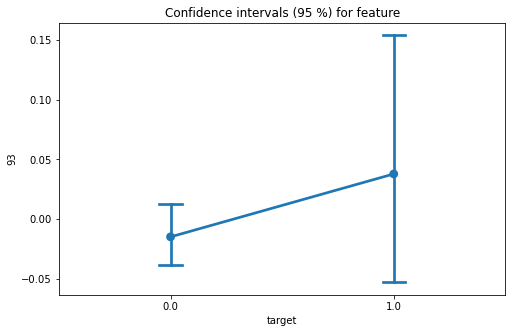

Оценка признака feature = 181


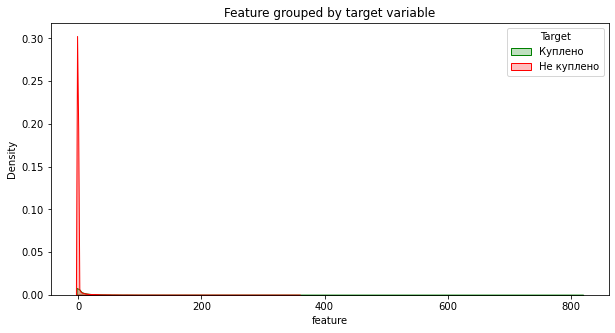

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.15348702669143677, pvalue=0.0)


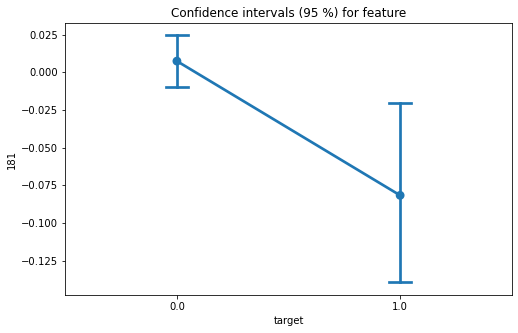

Оценка признака feature = month


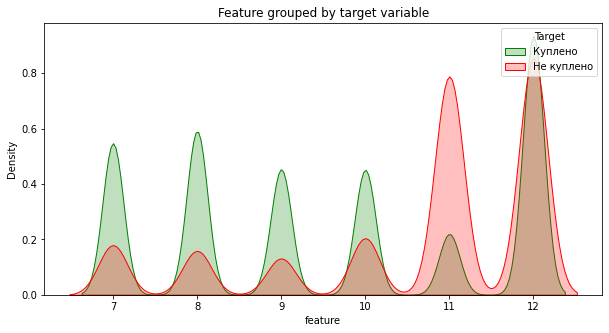

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.8641883134841919, pvalue=0.0)


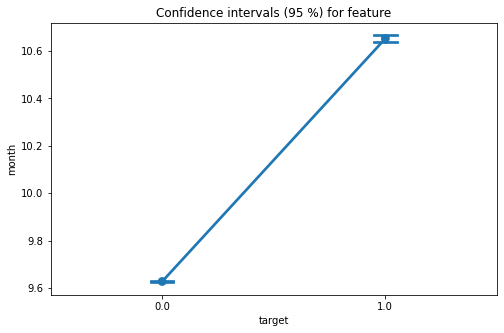

Оценка признака feature = 221


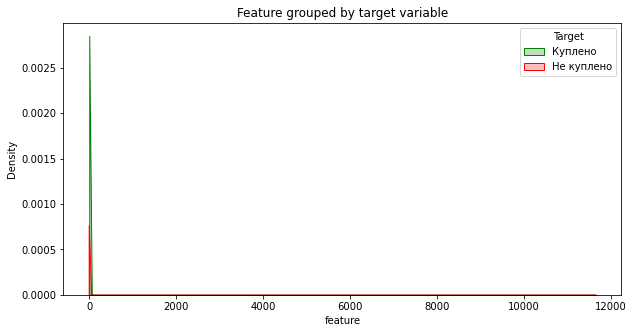

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.00041604042053222656, pvalue=0.0)


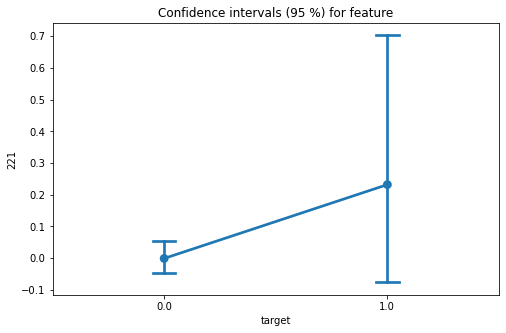

Оценка признака feature = 150


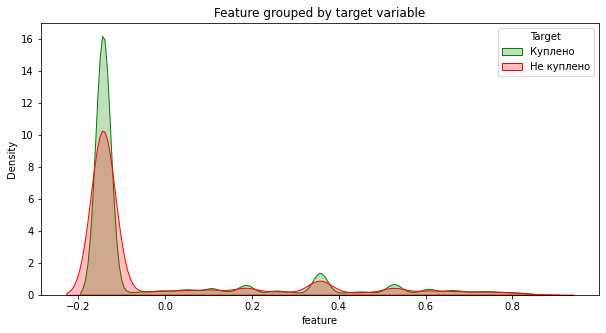

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.6149606704711914, pvalue=0.0)


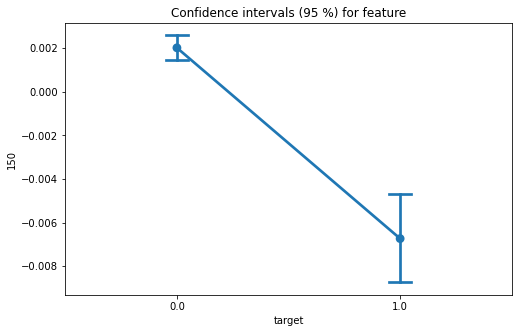

Оценка признака feature = 3


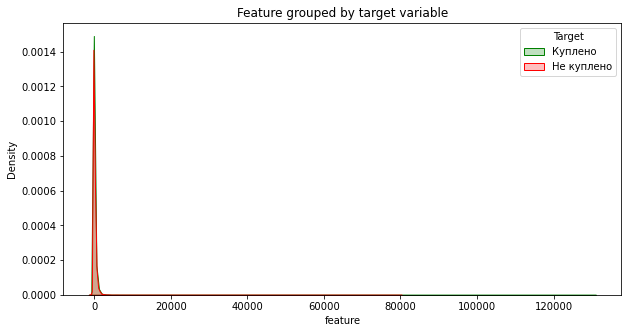

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.5124707221984863, pvalue=0.0)


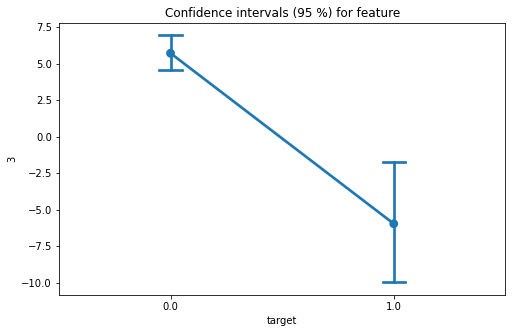

Оценка признака feature = 96


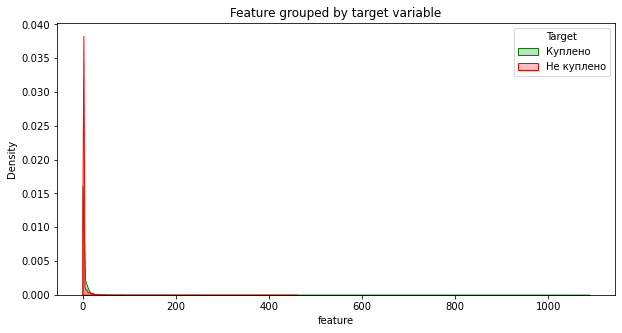

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.03290963172912598, pvalue=0.0)


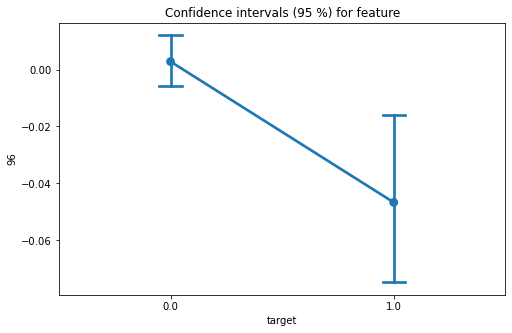

Оценка признака feature = 102


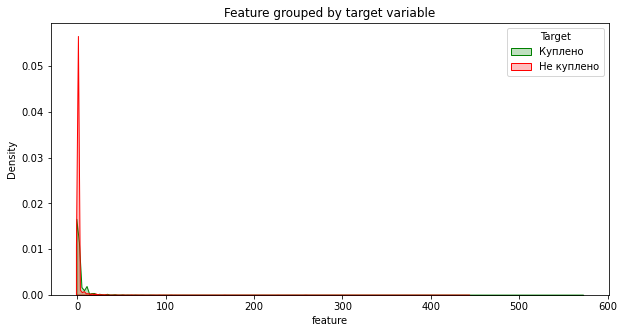

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.05678379535675049, pvalue=0.0)


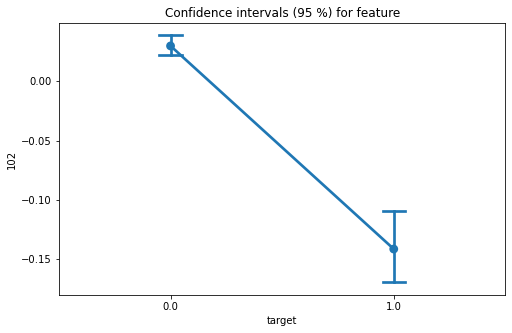

Оценка признака feature = 136


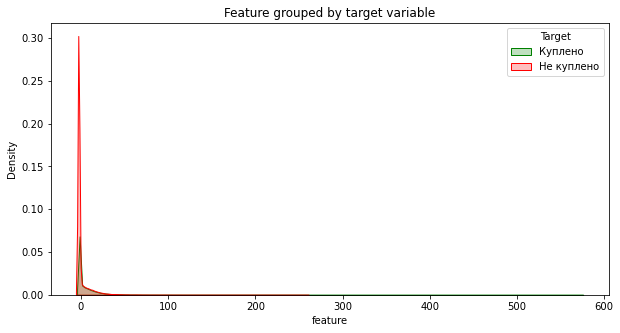

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.37462353706359863, pvalue=0.0)


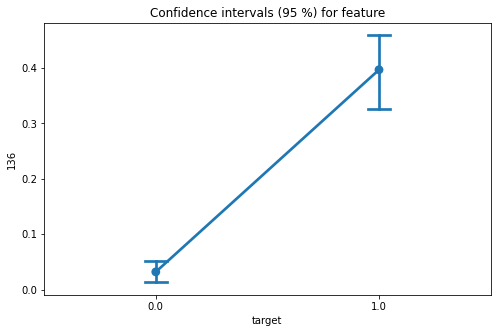

Оценка признака feature = 170


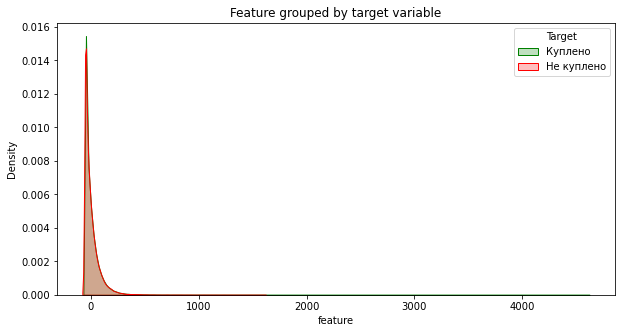

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.6761859655380249, pvalue=0.0)


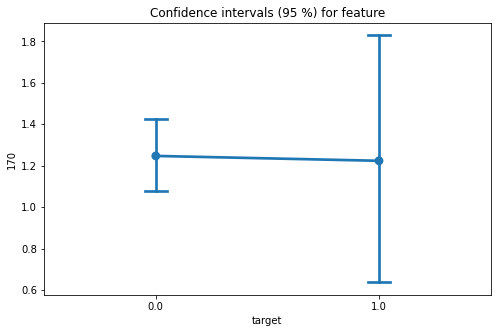

Оценка признака feature = 208


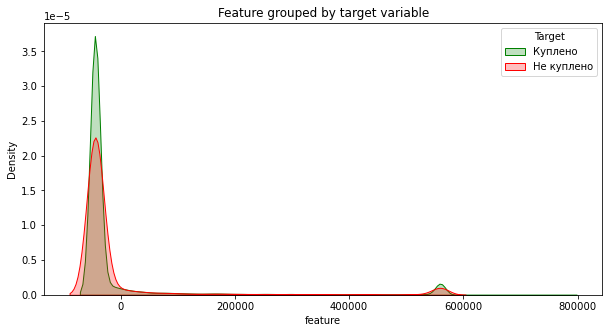

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.3561081886291504, pvalue=0.0)


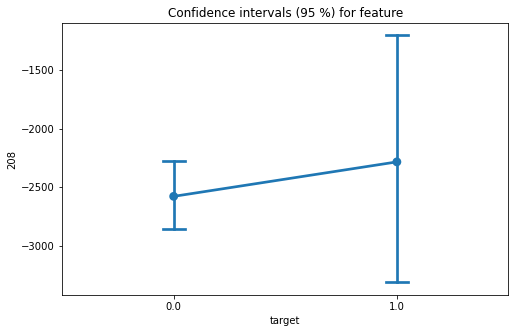

Оценка признака feature = 242


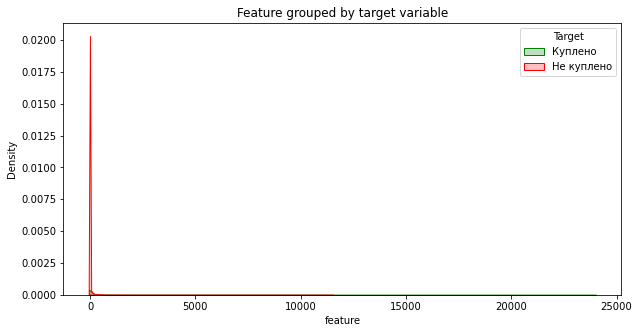

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0853227972984314, pvalue=0.0)


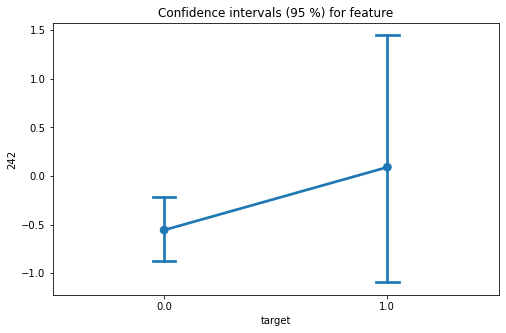

Оценка признака feature = 49


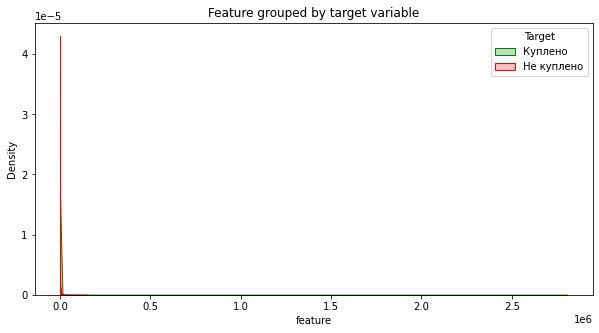

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0011539459228515625, pvalue=0.0)


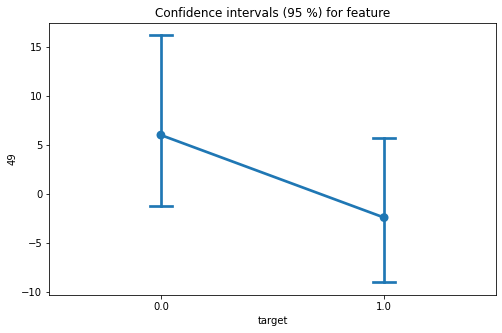

Оценка признака feature = 76


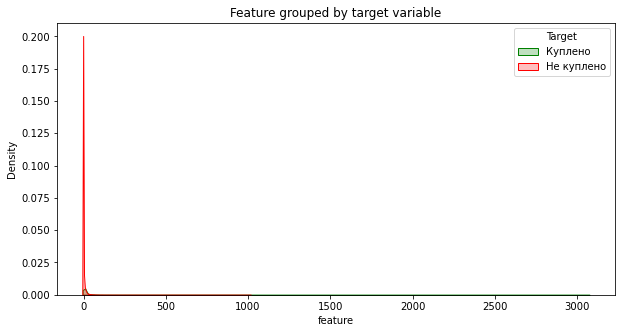

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.17807042598724365, pvalue=0.0)


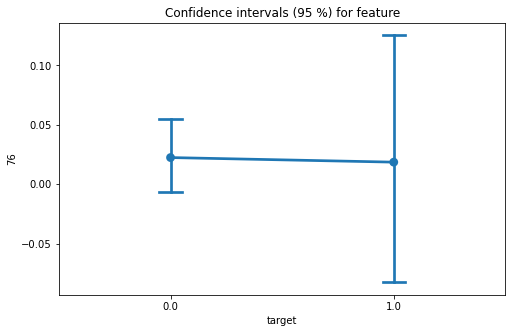

Оценка признака feature = 252


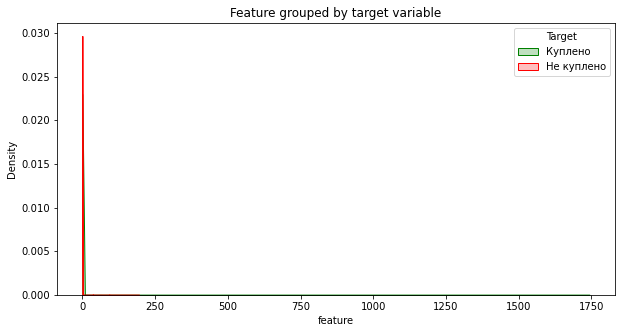

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.02828538417816162, pvalue=0.0)


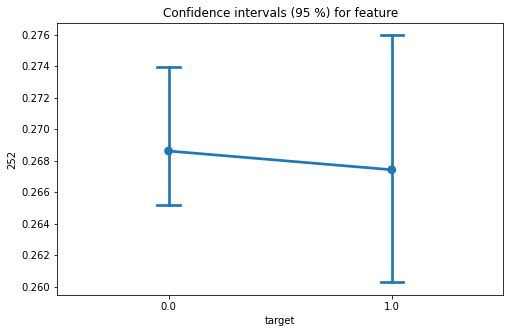

Оценка признака feature = 244


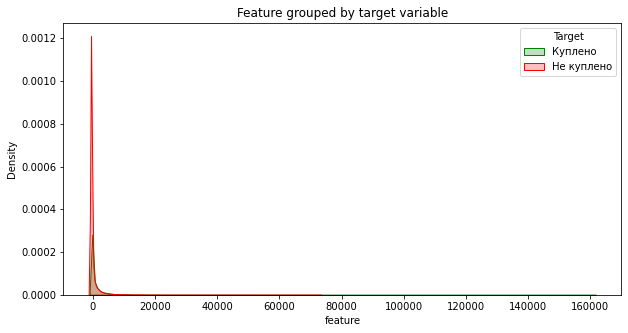

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.27736109495162964, pvalue=0.0)


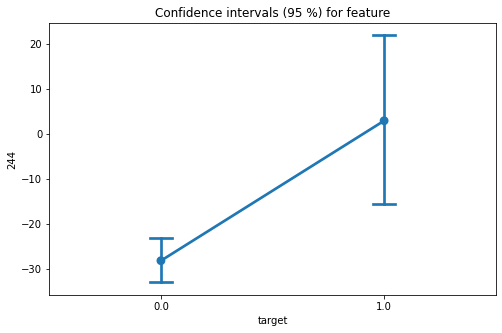

Оценка признака feature = 240


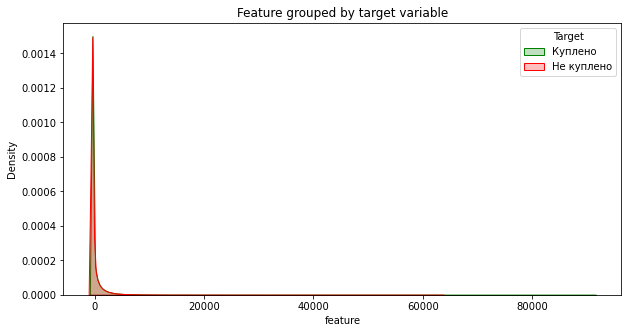

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.30908024311065674, pvalue=0.0)


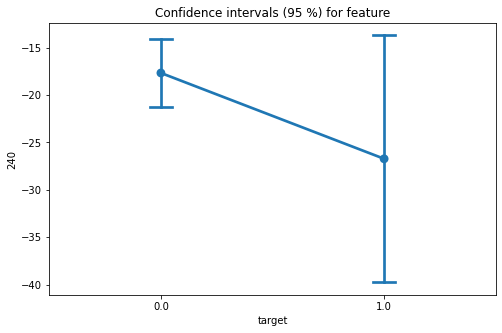

Оценка признака feature = 101


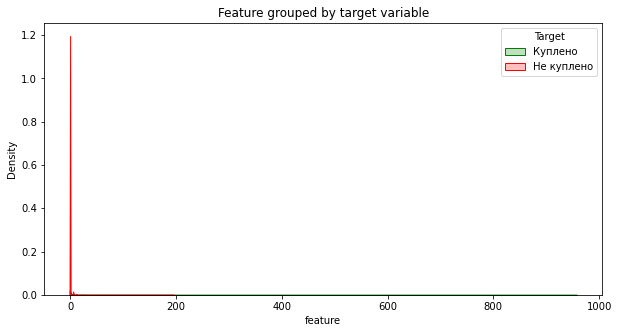

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.045316338539123535, pvalue=0.0)


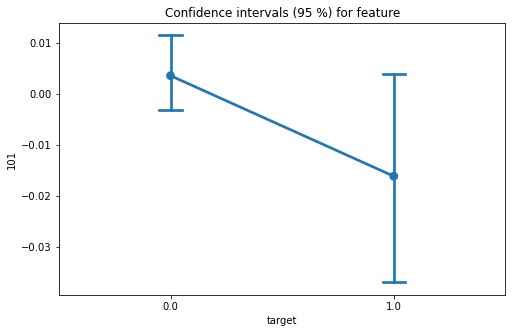

Оценка признака feature = 123


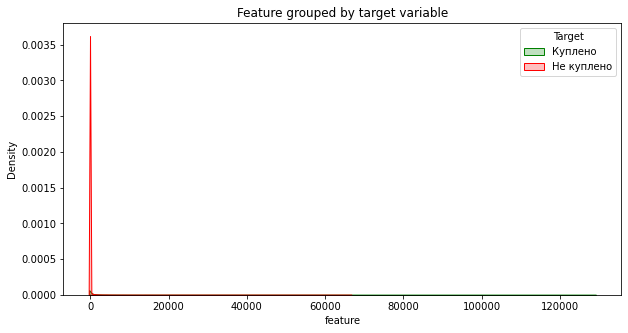

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.06058698892593384, pvalue=0.0)


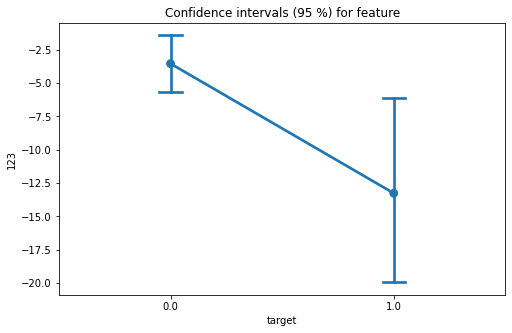

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


Оценка признака feature = year


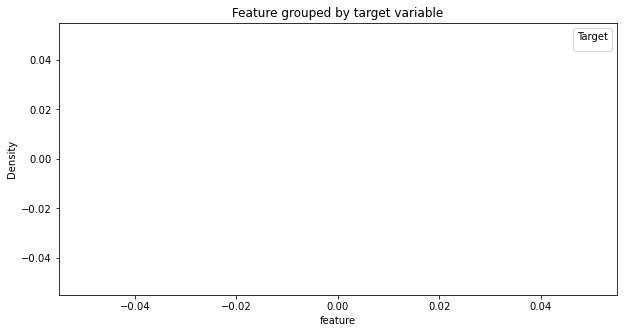

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=1.0, pvalue=1.0)


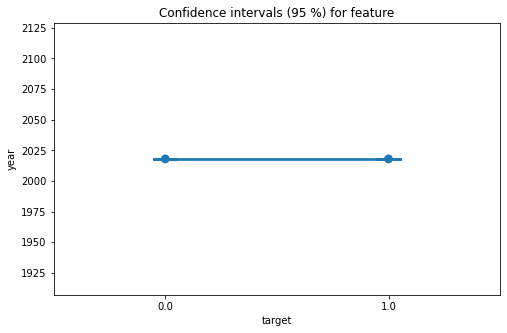

Оценка признака feature = 90


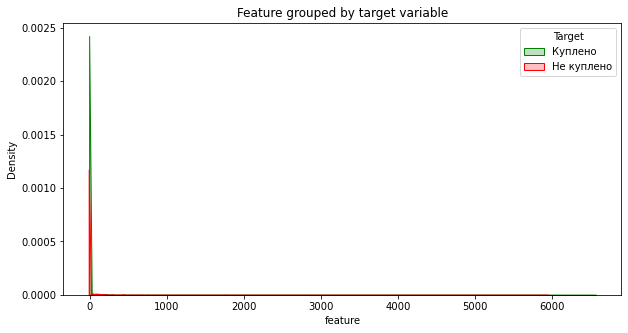

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.007685184478759766, pvalue=0.0)


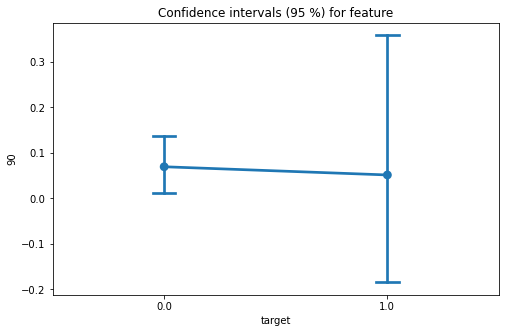

Оценка признака feature = 182


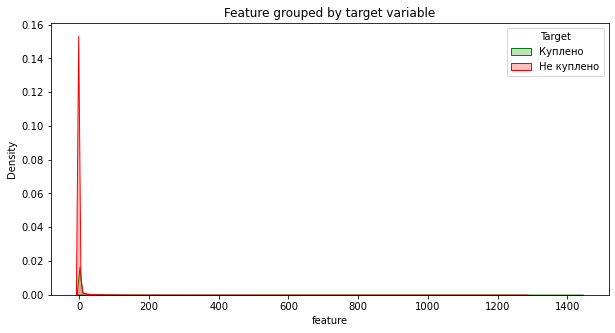

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.12001770734786987, pvalue=0.0)


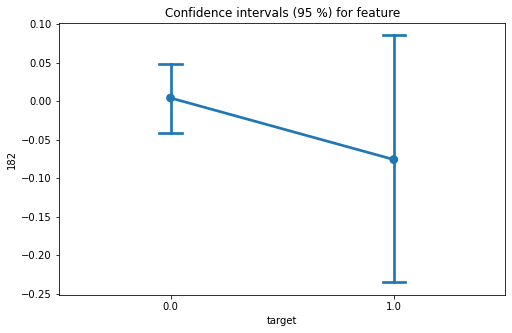

Оценка признака feature = 103


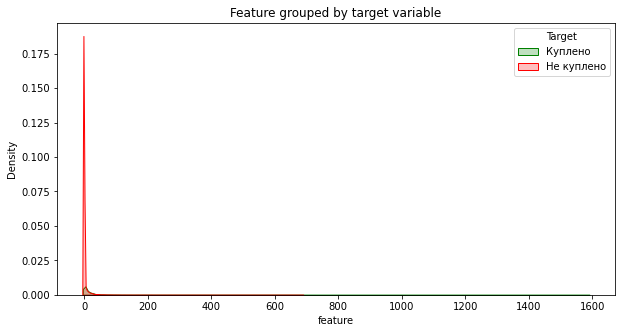

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.14931511878967285, pvalue=0.0)


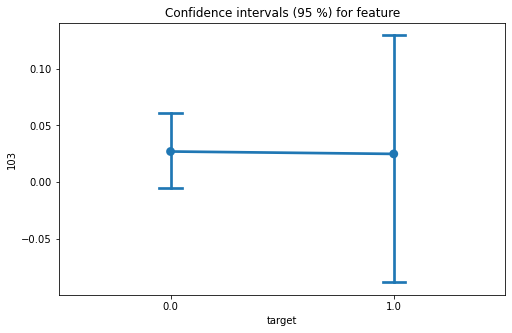

Оценка признака feature = 250


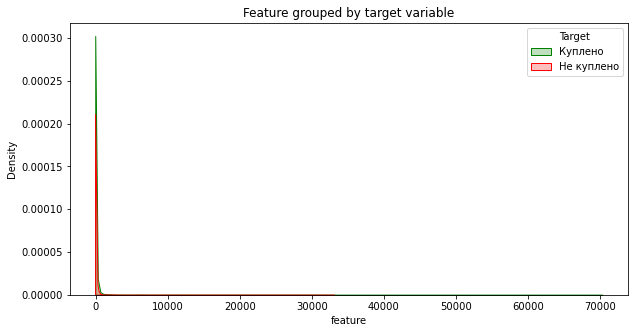

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.036021411418914795, pvalue=0.0)


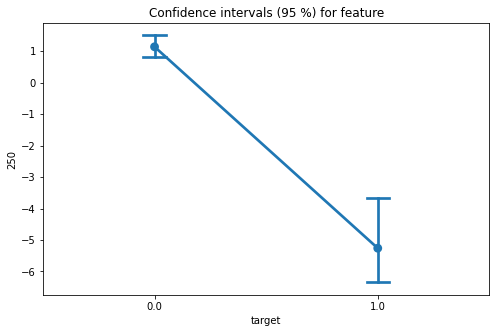

Оценка признака feature = day


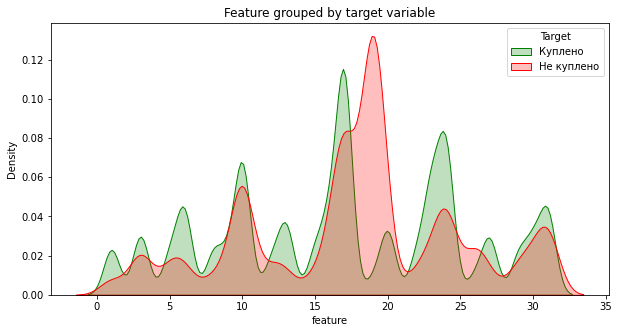

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.9648379683494568, pvalue=0.0)


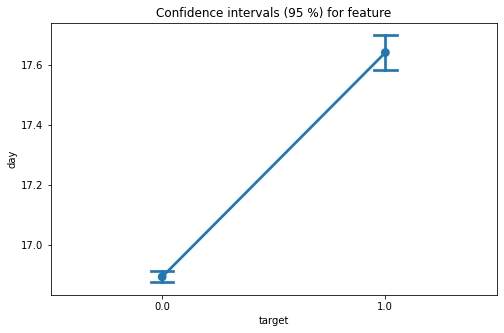

Оценка признака feature = 233


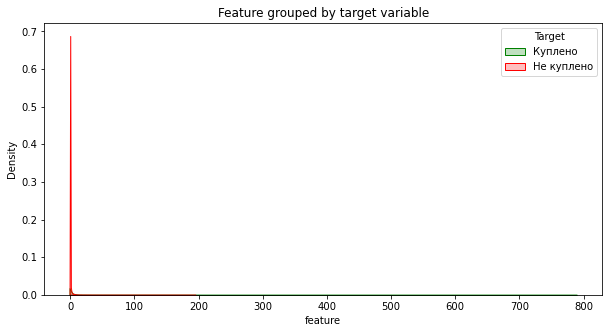

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.03156787157058716, pvalue=0.0)


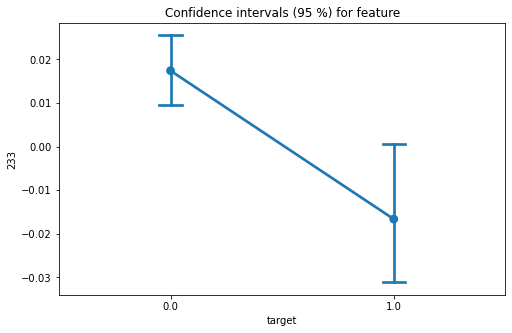

Оценка признака feature = 111


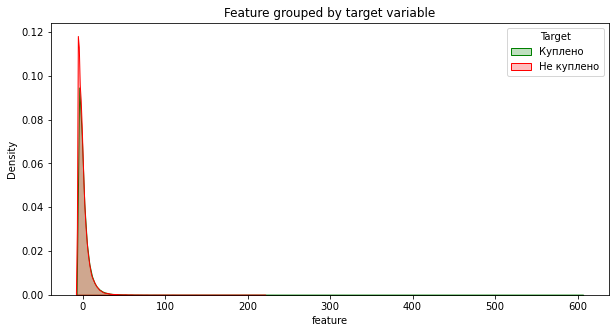

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.6887340545654297, pvalue=0.0)


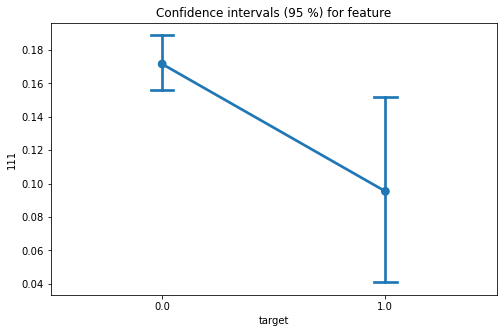

Оценка признака feature = 159


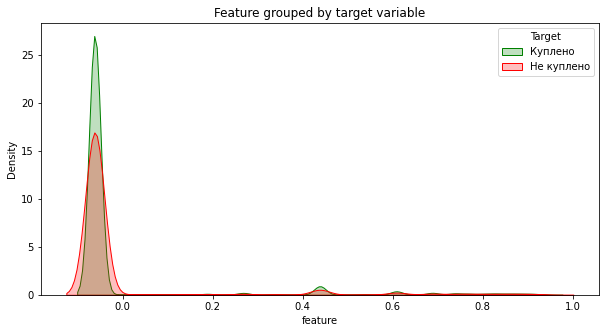

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.35758912563323975, pvalue=0.0)


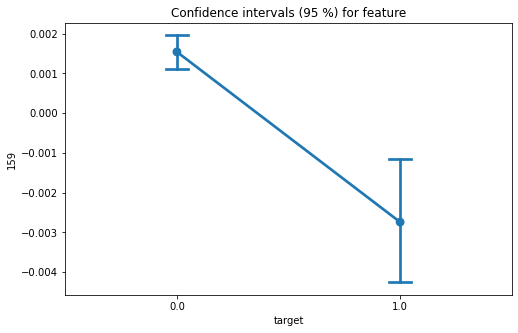

Оценка признака feature = 13


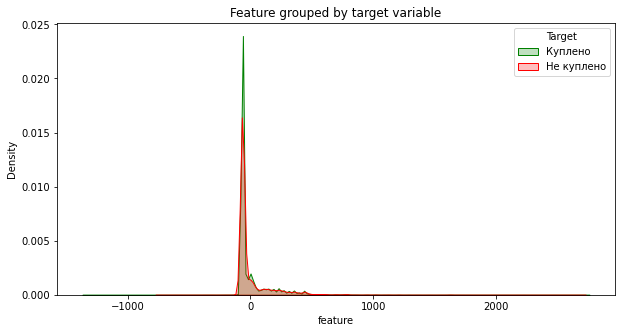

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.5050311088562012, pvalue=0.0)


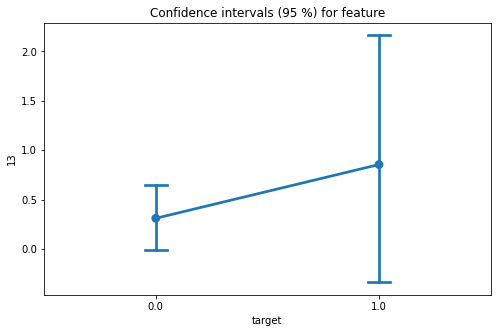

Оценка признака feature = 172


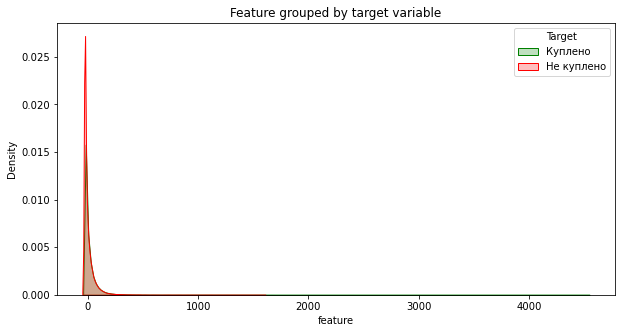

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.5300018787384033, pvalue=0.0)


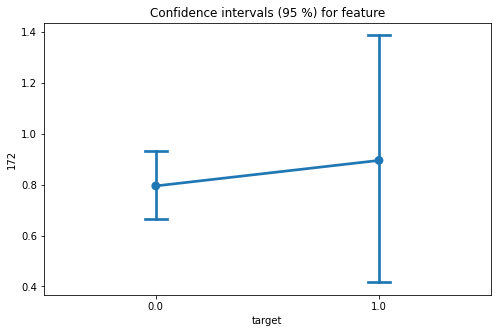

Оценка признака feature = 112


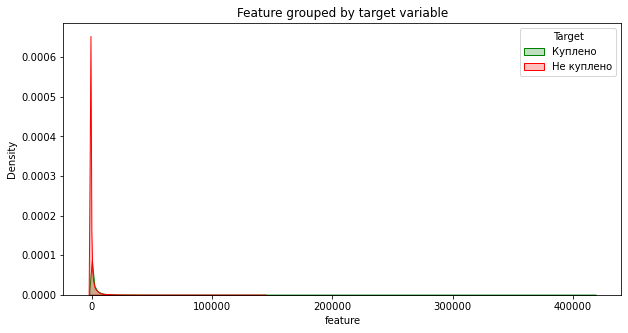

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.30669498443603516, pvalue=0.0)


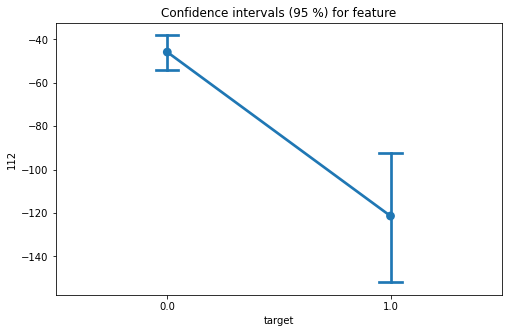

Оценка признака feature = 8


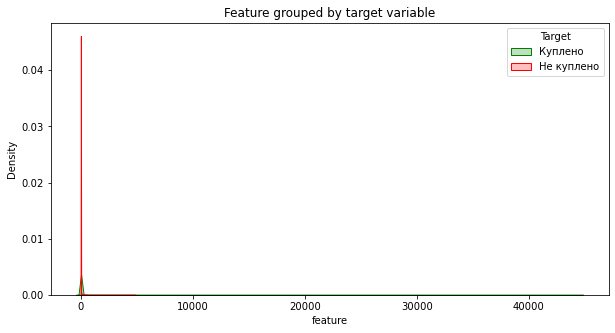

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.03072178363800049, pvalue=0.0)


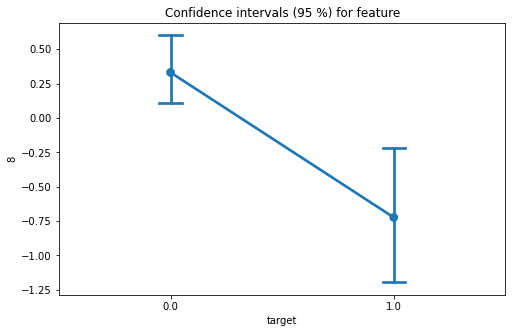

Оценка признака feature = 127


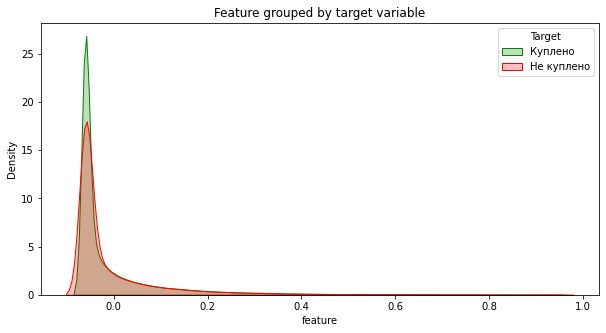

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.5545133352279663, pvalue=0.0)


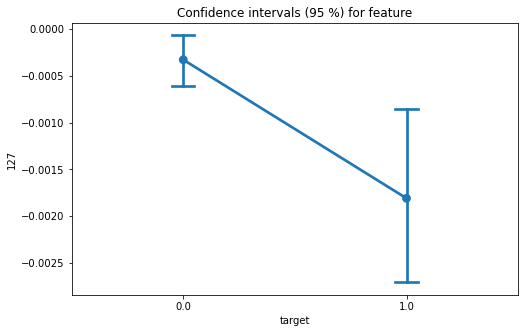

Оценка признака feature = 215


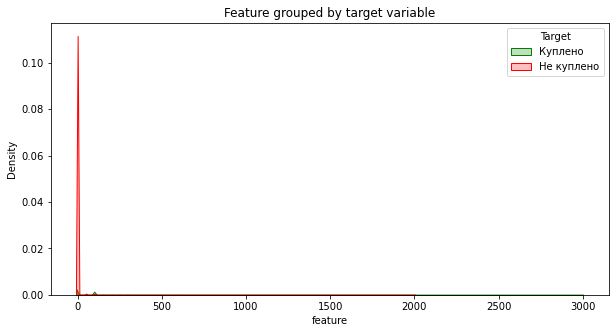

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.05666142702102661, pvalue=0.0)


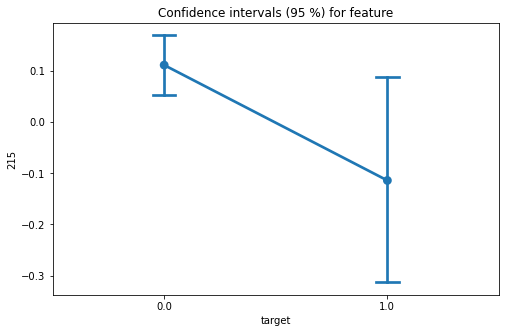

Оценка признака feature = 121


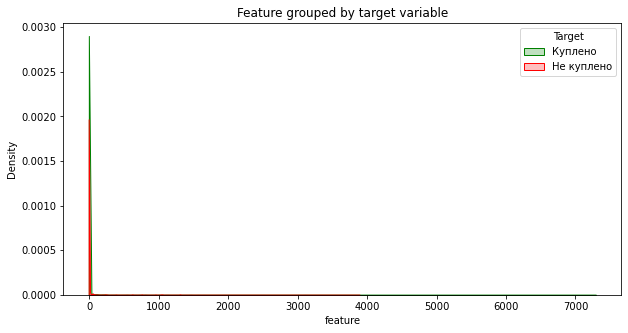

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0045683979988098145, pvalue=0.0)


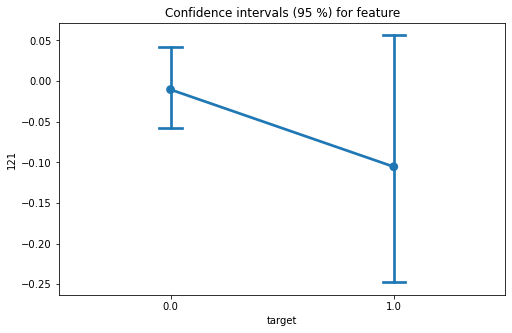

Оценка признака feature = 249


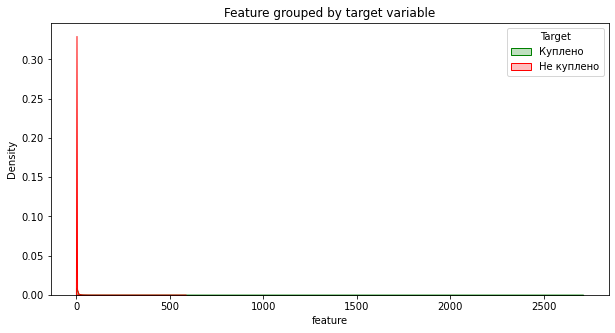

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.059318363666534424, pvalue=0.0)


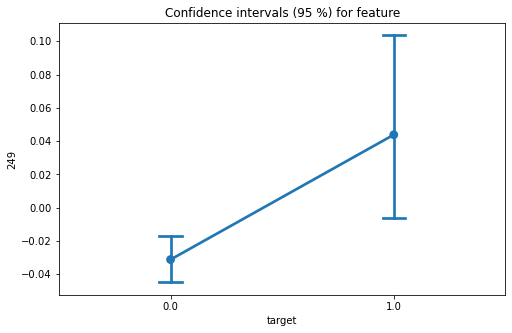

Оценка признака feature = 175


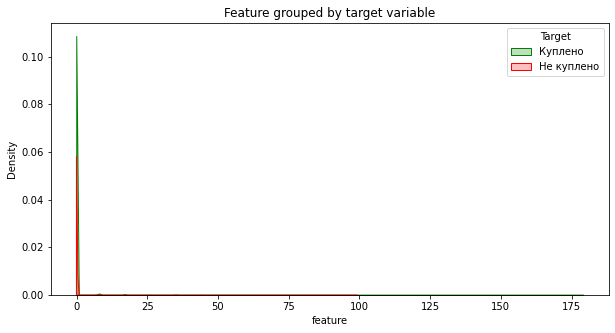

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.011595070362091064, pvalue=0.0)


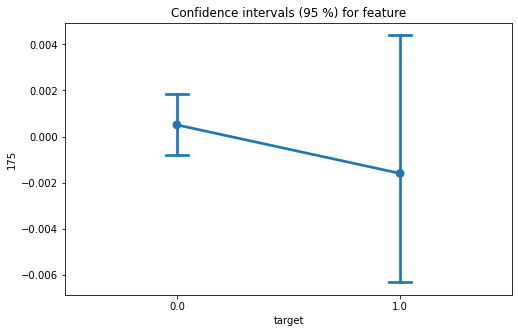

Оценка признака feature = 115


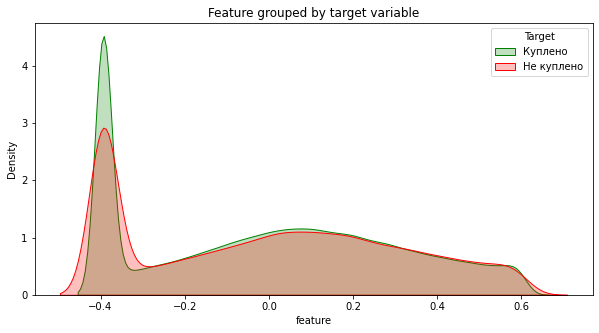

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.9285051822662354, pvalue=0.0)


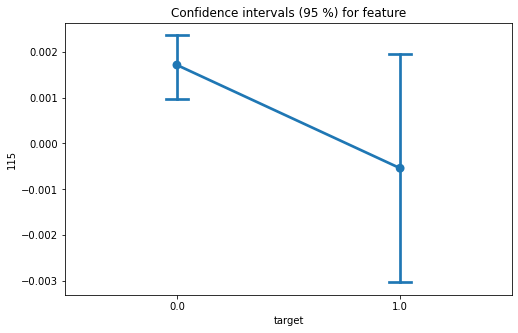

Оценка признака feature = 38


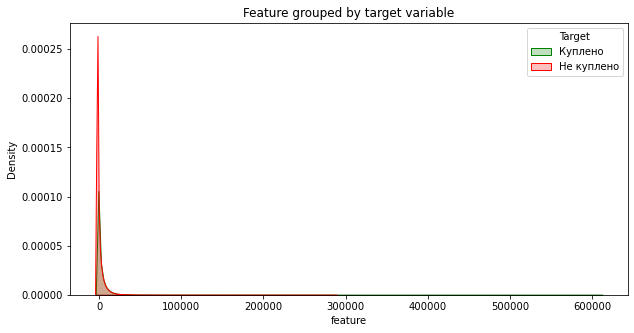

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.43439191579818726, pvalue=0.0)


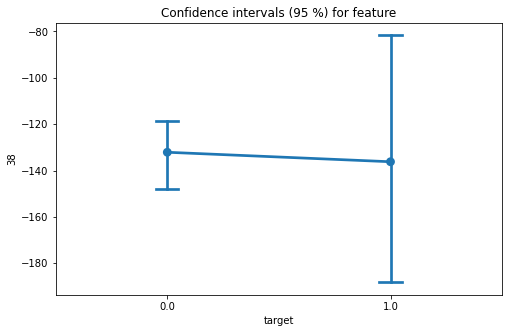

Оценка признака feature = 71


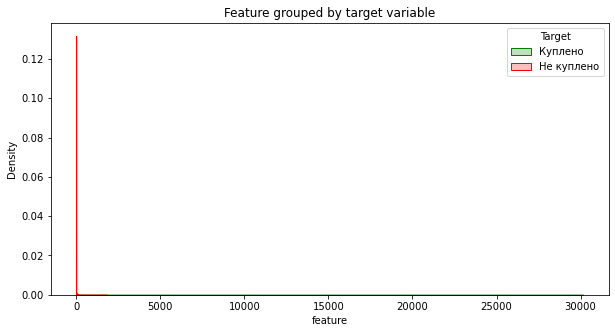

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.028284192085266113, pvalue=0.0)


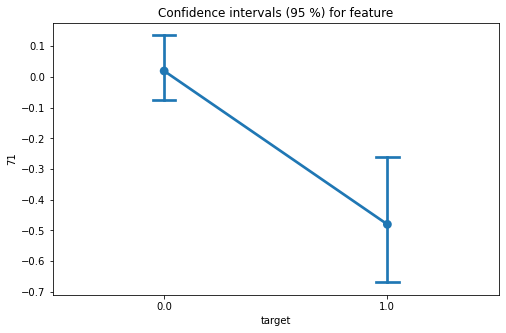

Оценка признака feature = 54


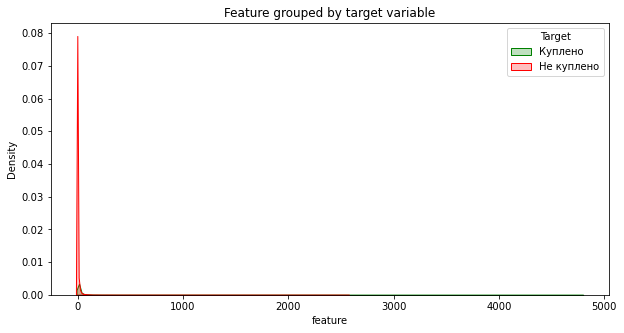

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.1495649814605713, pvalue=0.0)


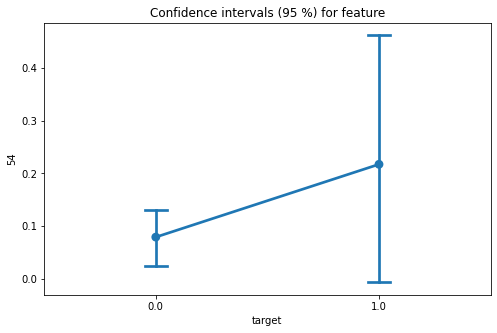

Оценка признака feature = 45


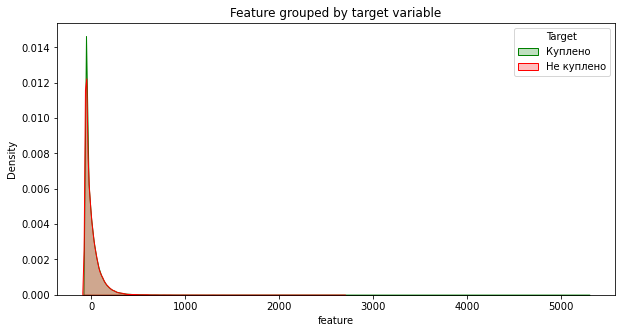

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.6749447584152222, pvalue=0.0)


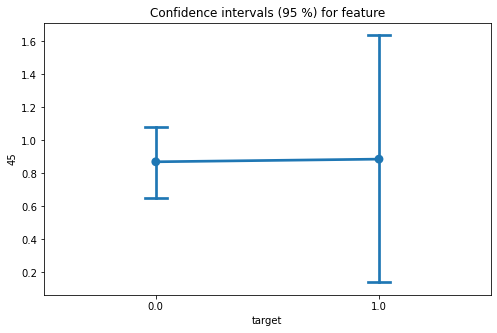

Оценка признака feature = 134


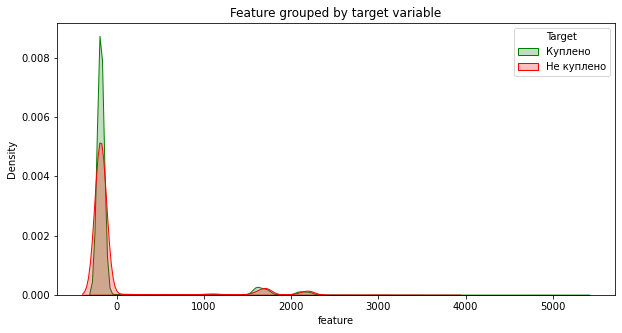

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.37677520513534546, pvalue=0.0)


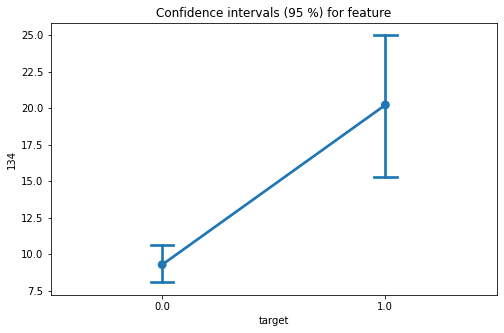

Оценка признака feature = 184


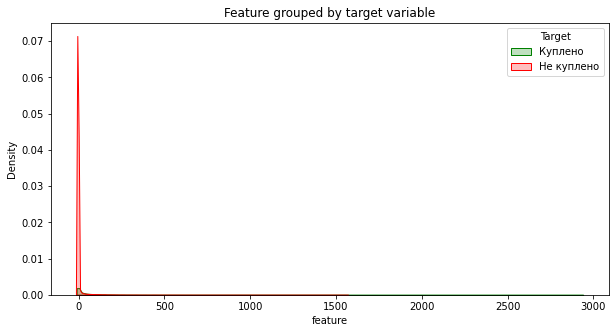

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.13113611936569214, pvalue=0.0)


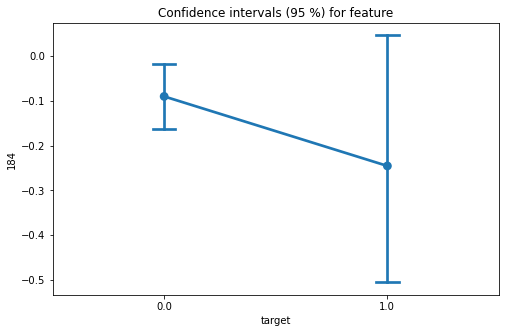

Оценка признака feature = 61


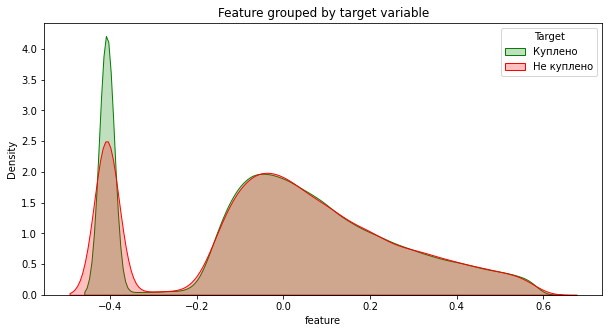

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.9533180594444275, pvalue=0.0)


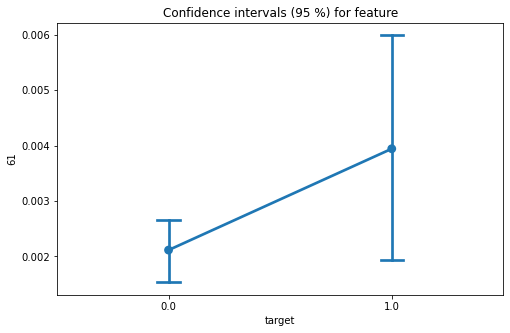

Оценка признака feature = 209


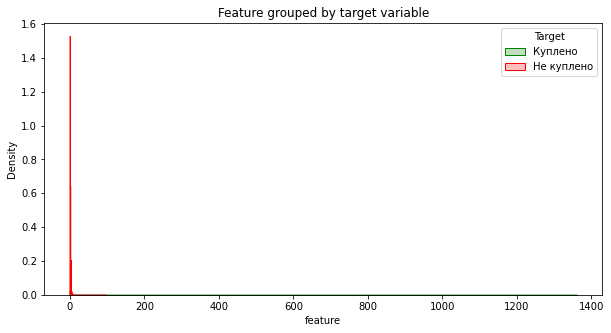

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.17128539085388184, pvalue=0.0)


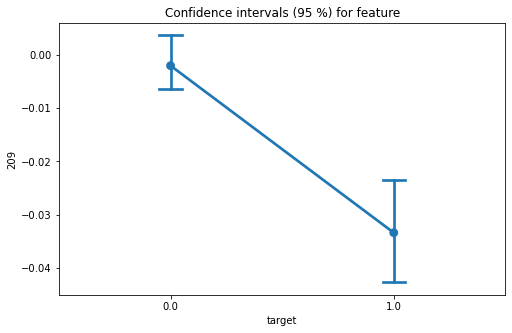

Оценка признака feature = 248


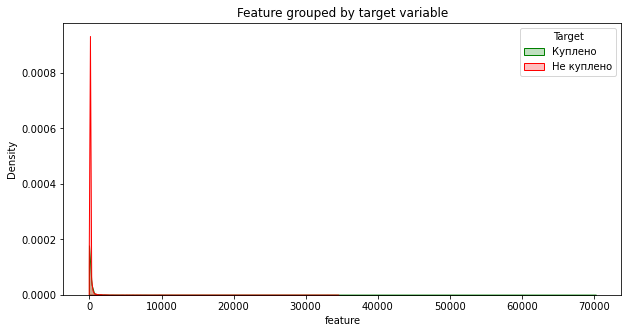

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.05835682153701782, pvalue=0.0)


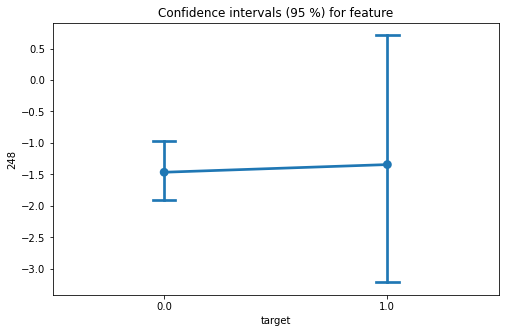

Оценка признака feature = 98


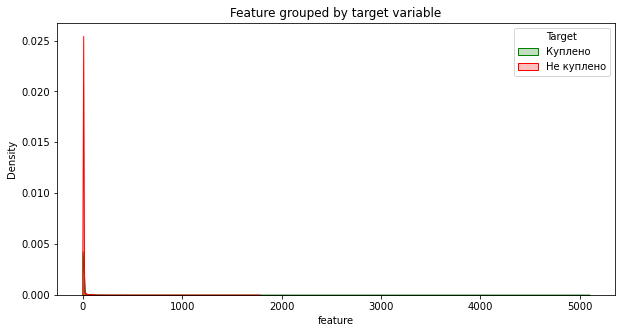

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.02798295021057129, pvalue=0.0)


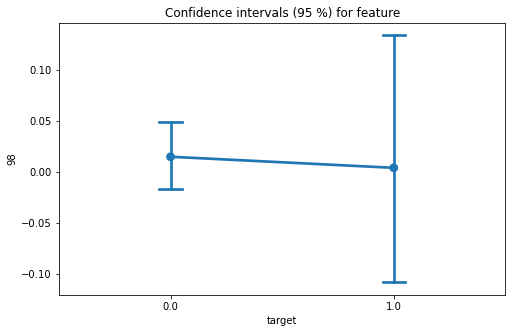

Оценка признака feature = 223


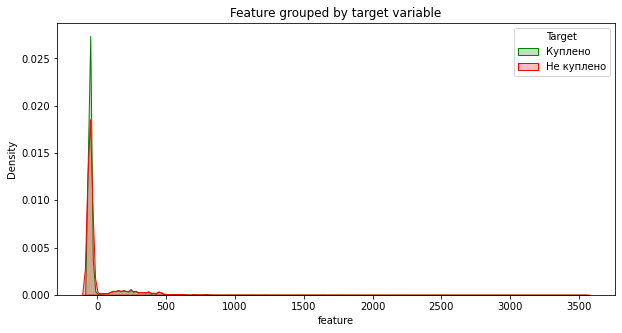

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.4414719343185425, pvalue=0.0)


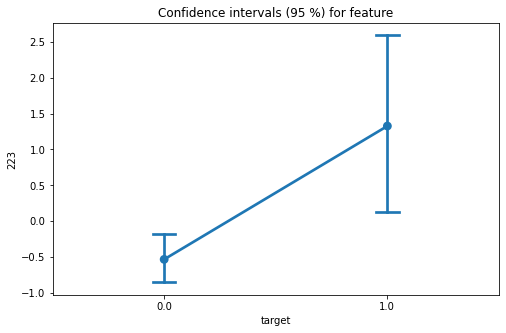

Оценка признака feature = 119


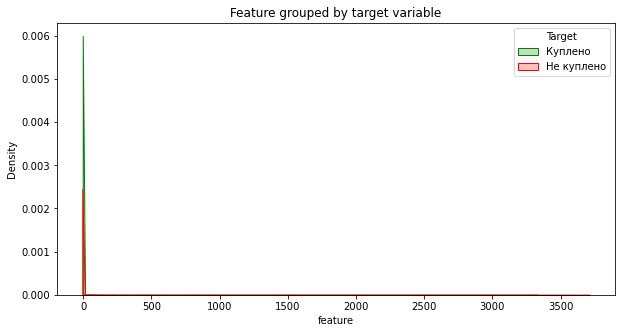

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0013278722763061523, pvalue=0.0)


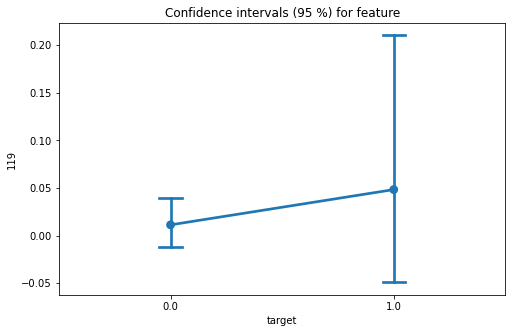

Оценка признака feature = 239


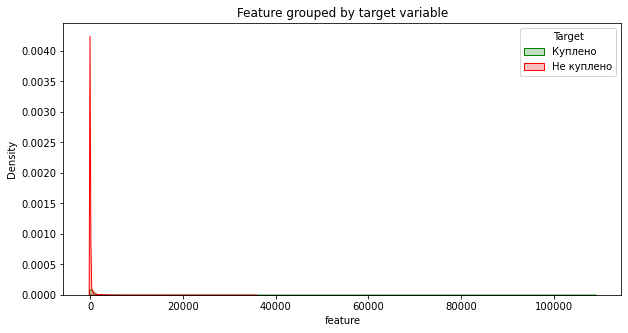

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.13549131155014038, pvalue=0.0)


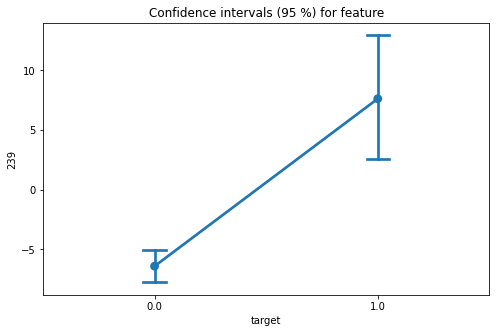

Оценка признака feature = 188


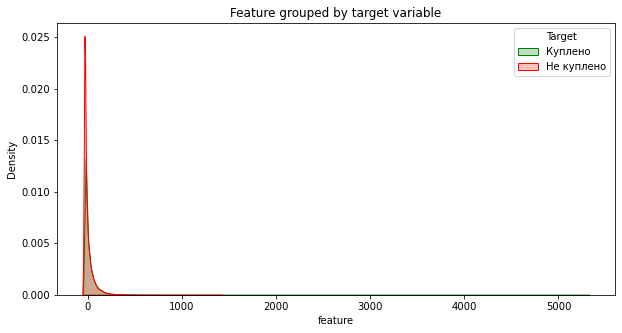

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.523794412612915, pvalue=0.0)


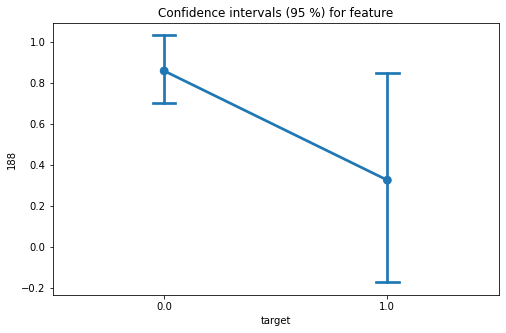

Оценка признака feature = 65


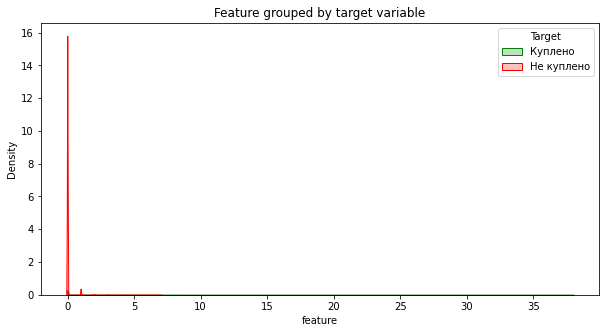

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.1099553108215332, pvalue=0.0)


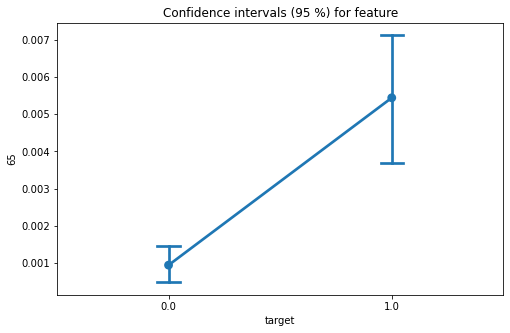

Оценка признака feature = 169


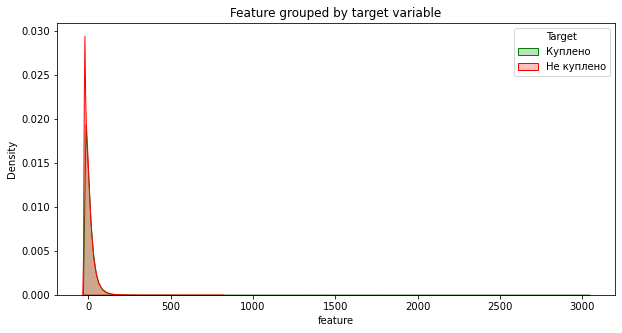

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.735660195350647, pvalue=0.0)


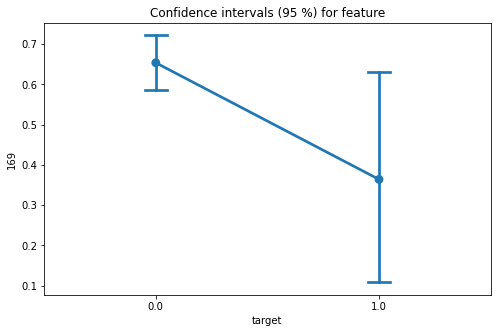

Оценка признака feature = 86


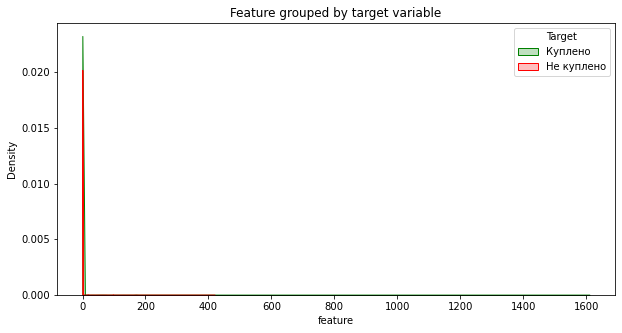

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.002096891403198242, pvalue=0.0)


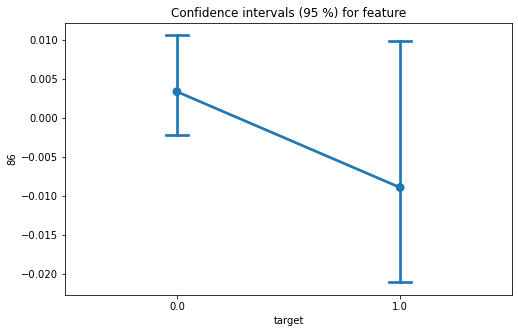

Оценка признака feature = 10


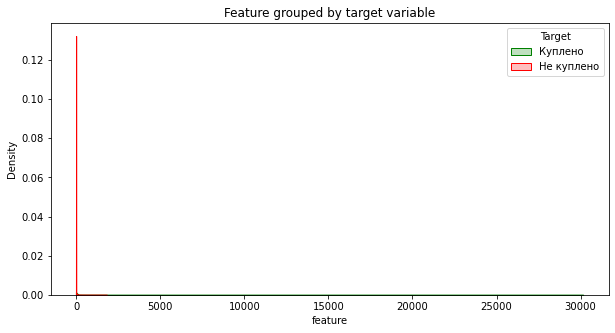

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.027649223804473877, pvalue=0.0)


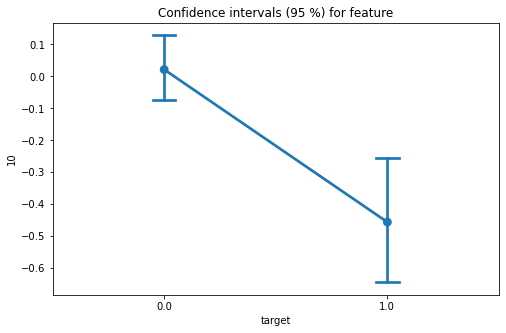

Оценка признака feature = 6


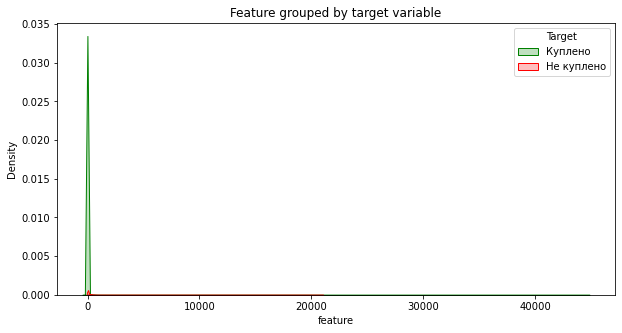

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.07971084117889404, pvalue=0.0)


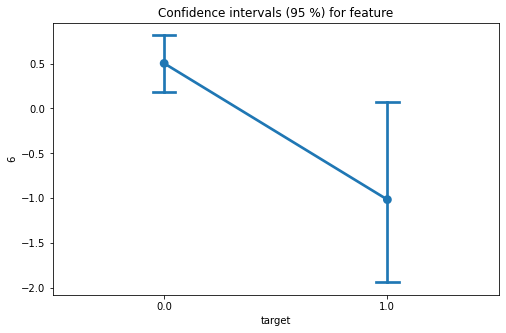

Оценка признака feature = 168


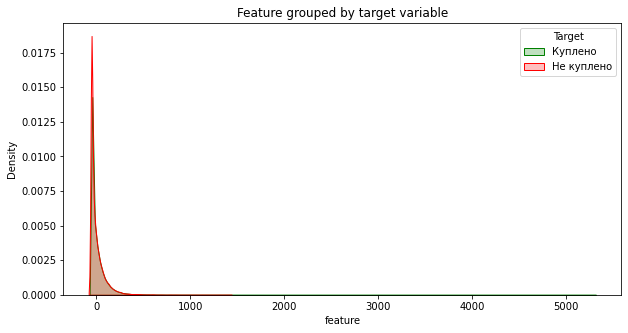

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.6256618499755859, pvalue=0.0)


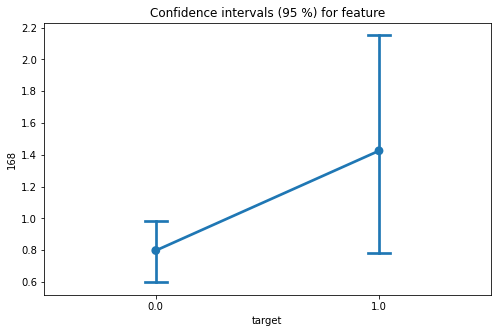

Оценка признака feature = 4


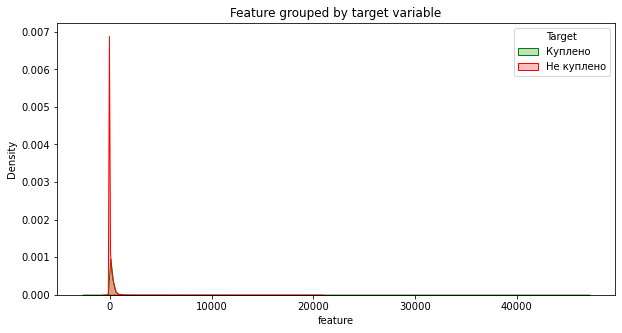

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.45170480012893677, pvalue=0.0)


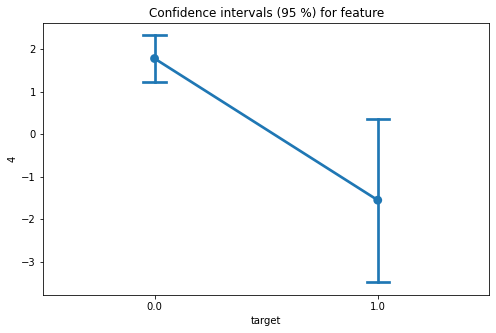

Оценка признака feature = 151


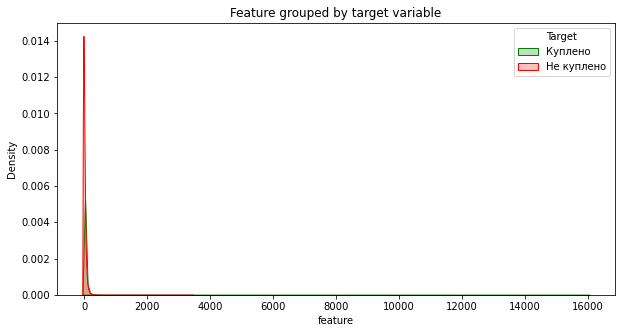

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.43057888746261597, pvalue=0.0)


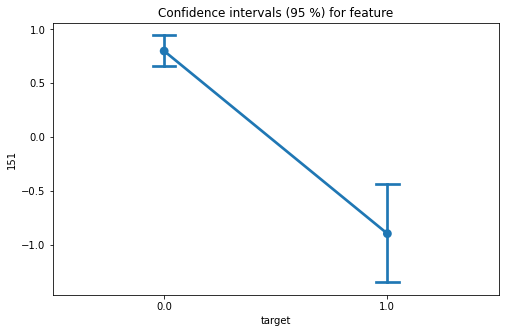

Оценка признака feature = 22


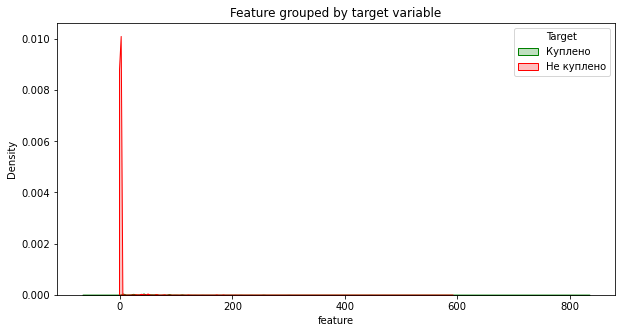

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.010082006454467773, pvalue=0.0)


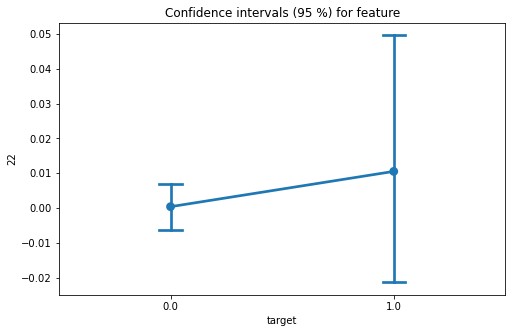

Оценка признака feature = 74


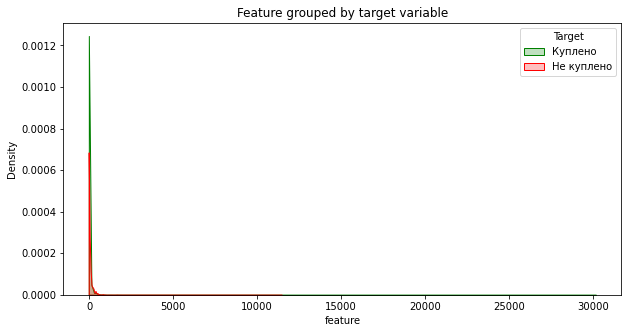

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.04266631603240967, pvalue=0.0)


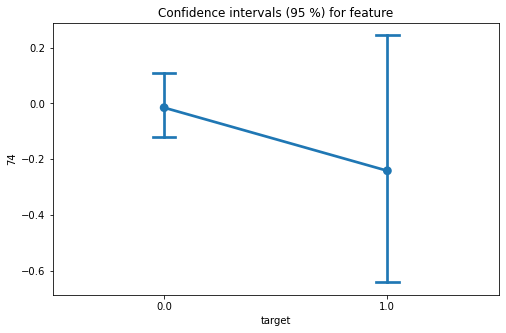

Оценка признака feature = 67


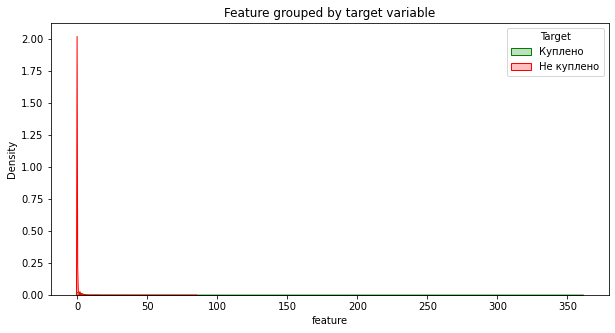

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.09097921848297119, pvalue=0.0)


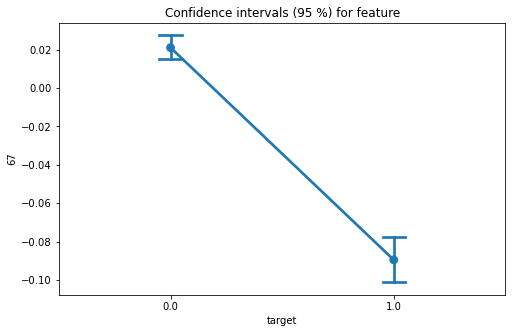

Оценка признака feature = 161


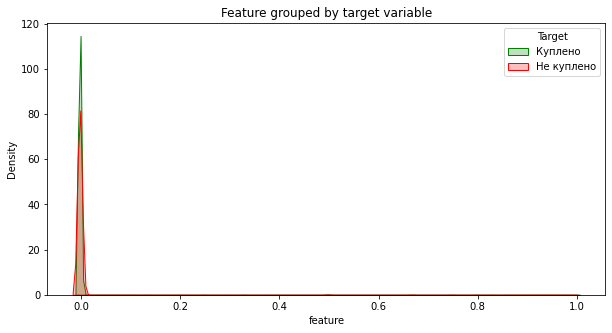

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.034205079078674316, pvalue=0.0)


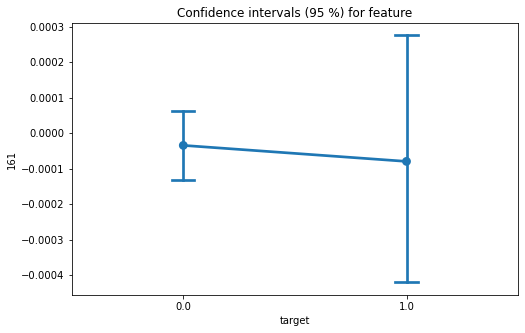

Оценка признака feature = 108


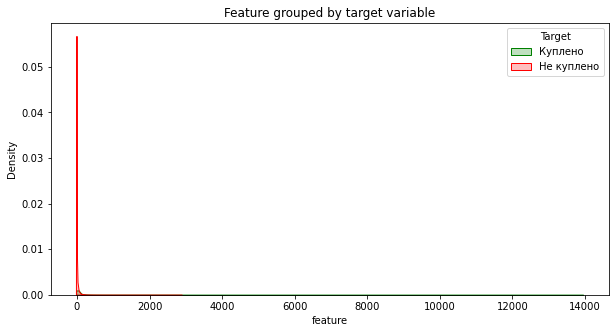

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.22759324312210083, pvalue=0.0)


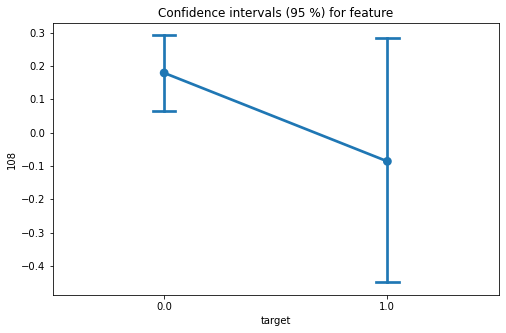

Оценка признака feature = 130


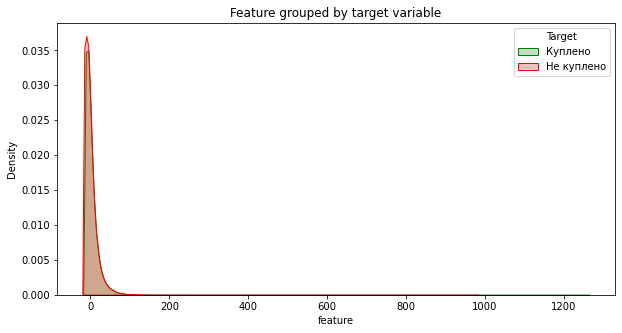

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.7369163632392883, pvalue=0.0)


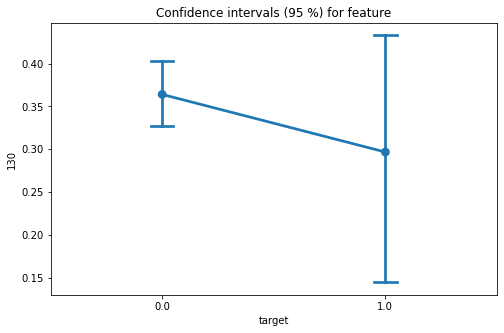

Оценка признака feature = 87


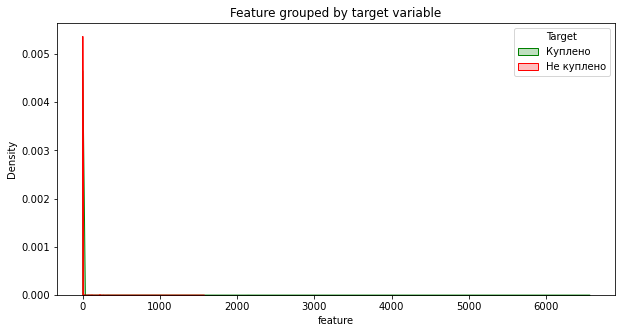

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0017091631889343262, pvalue=0.0)


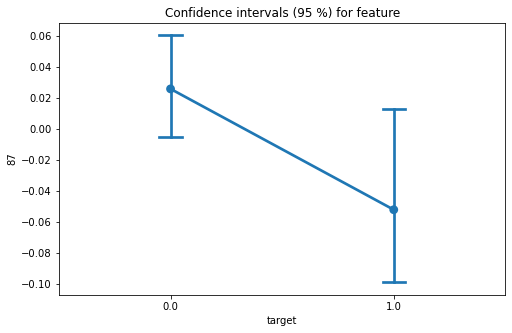

Оценка признака feature = 147


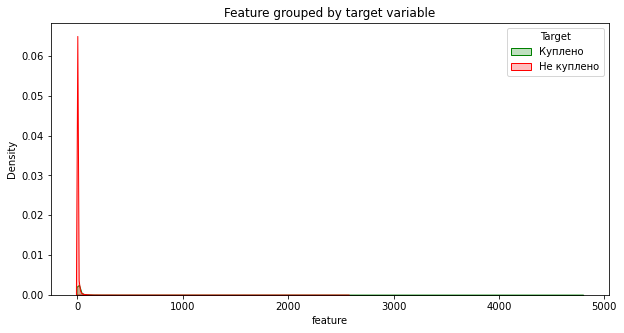

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.1351509690284729, pvalue=0.0)


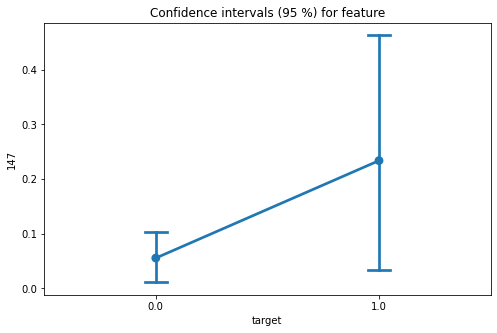

Оценка признака feature = 152


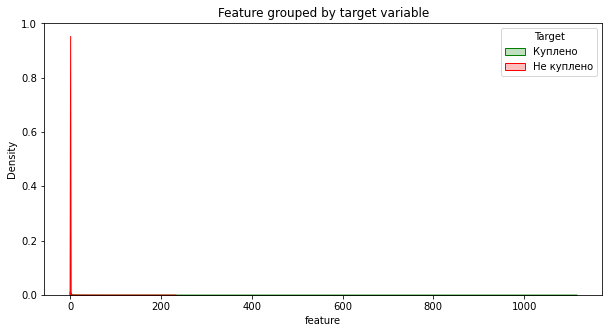

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.021580219268798828, pvalue=0.0)


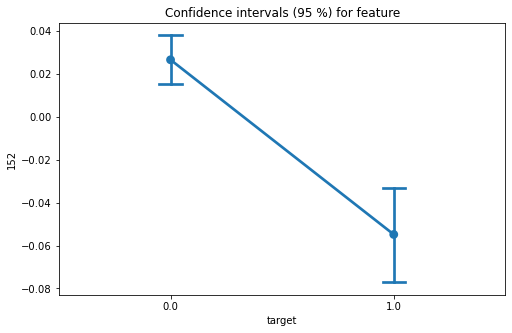

Оценка признака feature = 246


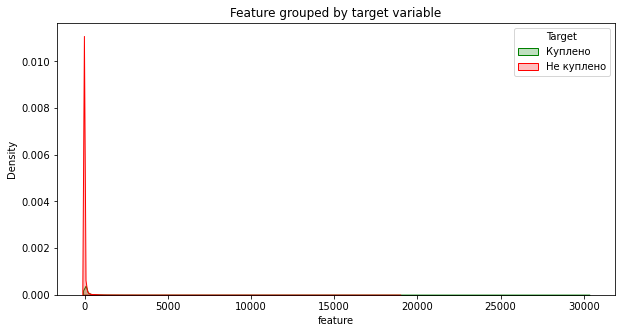

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.09726274013519287, pvalue=0.0)


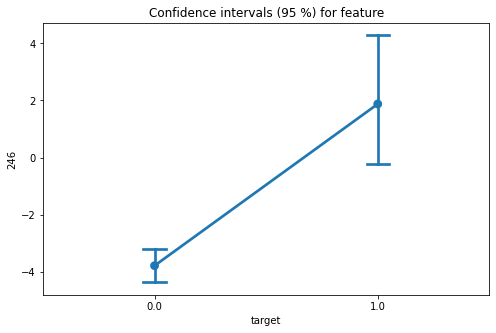

Оценка признака feature = 128


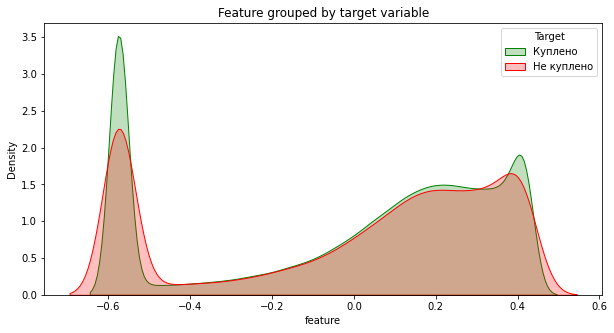

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.8495986461639404, pvalue=0.0)


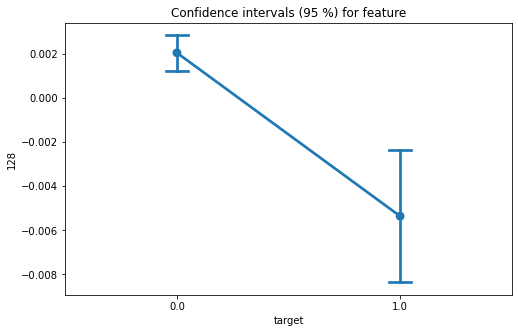

Оценка признака feature = 92


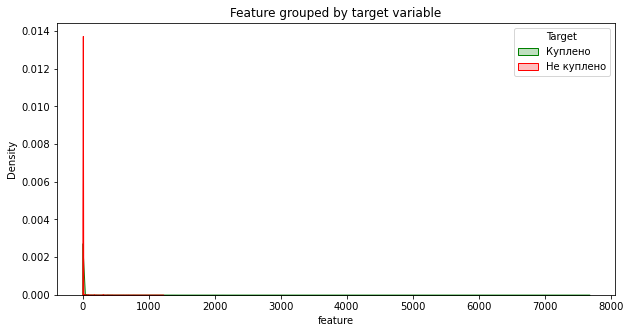

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.005830824375152588, pvalue=0.0)


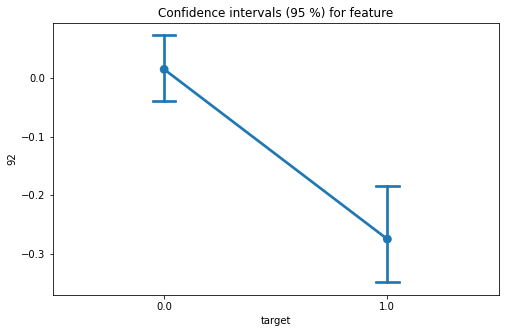

Оценка признака feature = 241


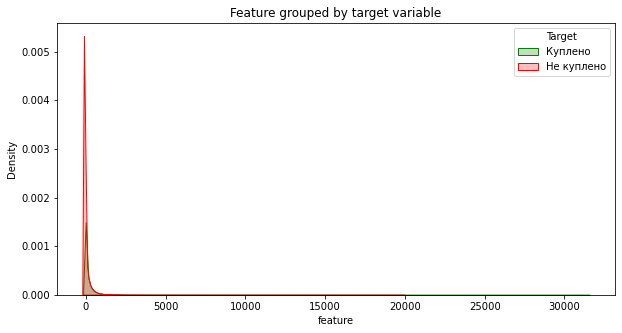

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.2612939476966858, pvalue=0.0)


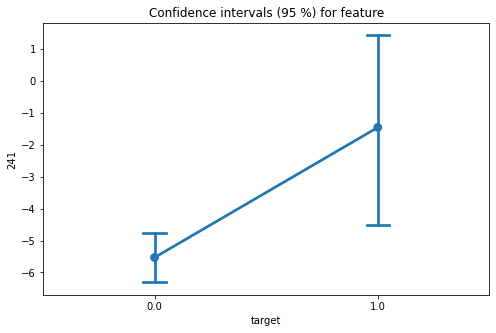

Оценка признака feature = 2


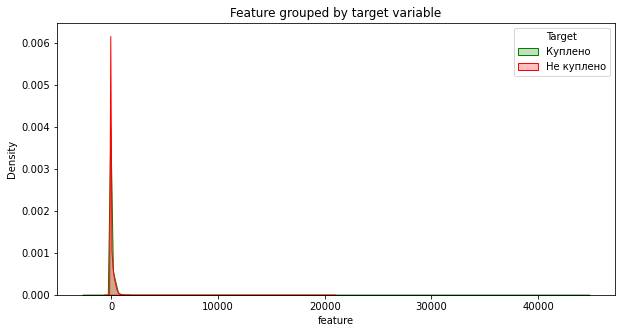

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.4727781414985657, pvalue=0.0)


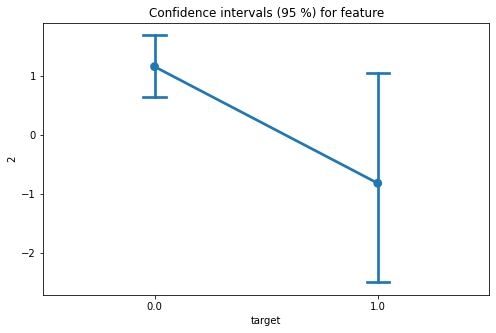

Оценка признака feature = 34


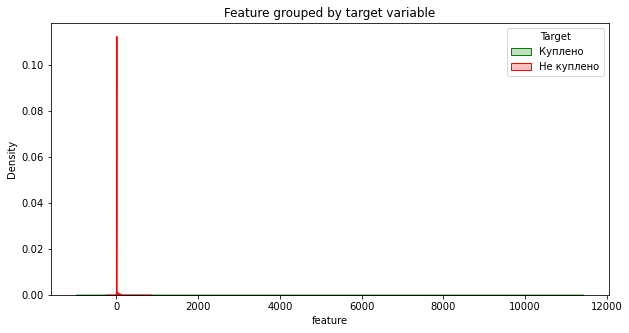

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.06862848997116089, pvalue=0.0)


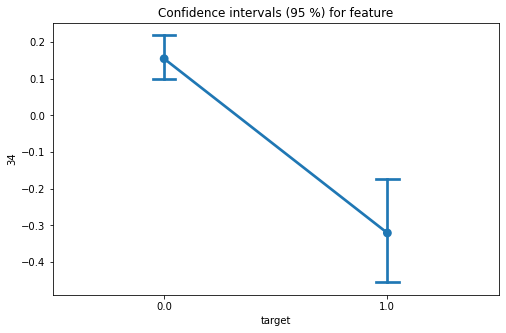

Оценка признака feature = 72


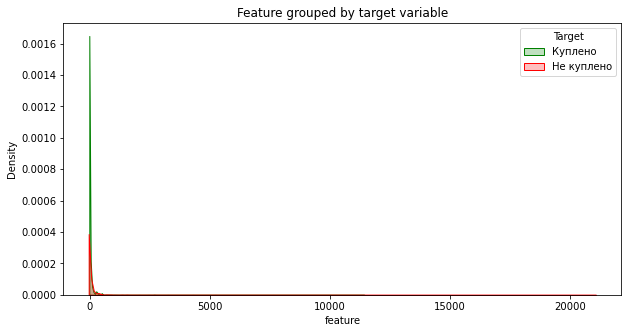

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.028420627117156982, pvalue=0.0)


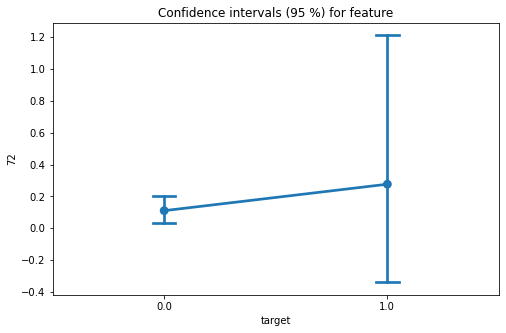

Оценка признака feature = 210


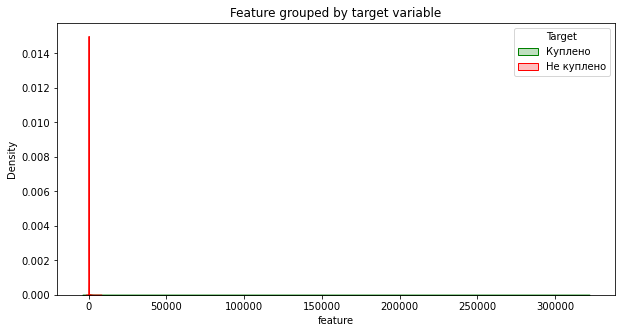

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.05040103197097778, pvalue=0.0)


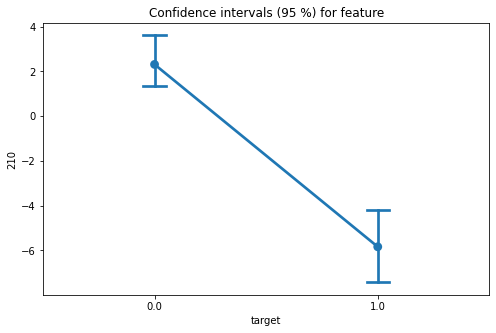

Оценка признака feature = 83


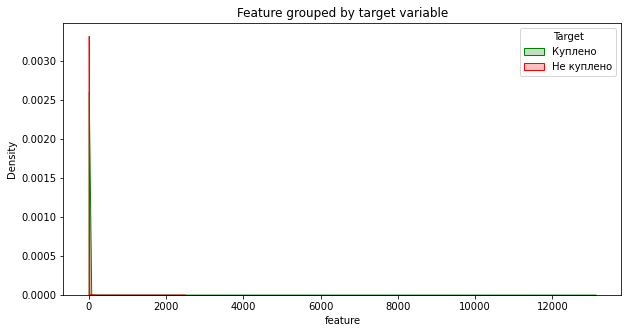

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0016483068466186523, pvalue=0.0)


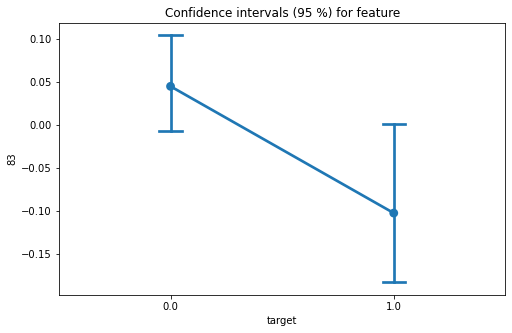

Оценка признака feature = 129


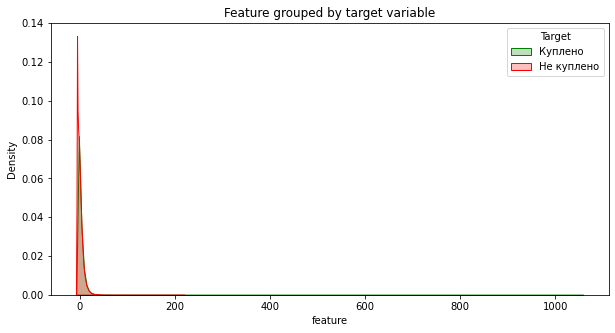

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.7298429012298584, pvalue=0.0)


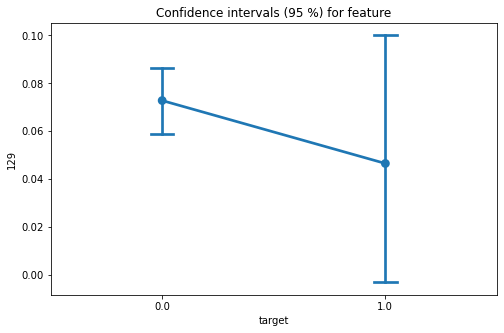

Оценка признака feature = 23


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


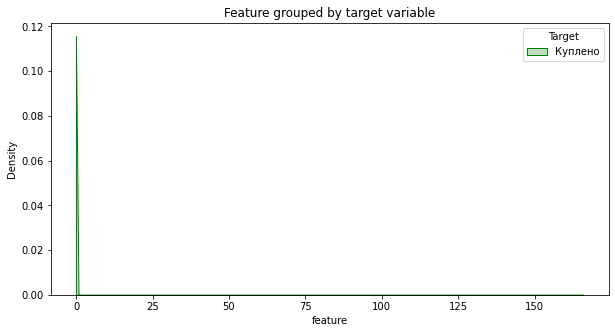

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0002785325050354004, pvalue=0.0)


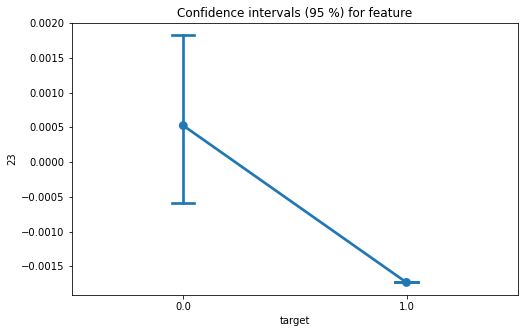

Оценка признака feature = 217


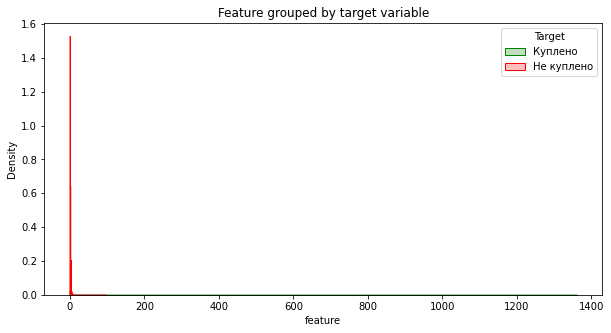

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.17128217220306396, pvalue=0.0)


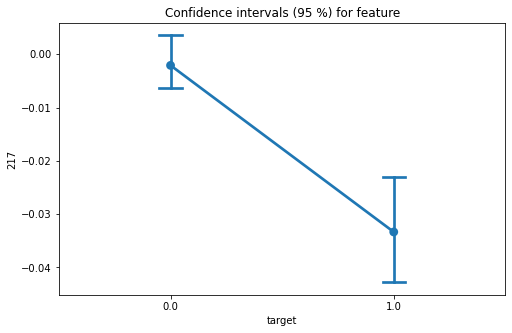

Оценка признака feature = 21


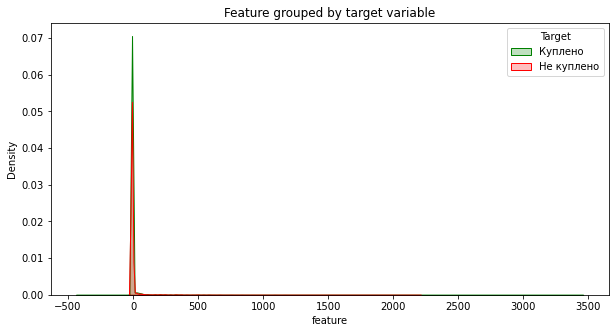

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.15200120210647583, pvalue=0.0)


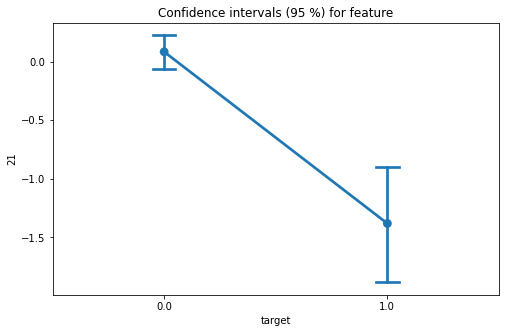

Оценка признака feature = 50


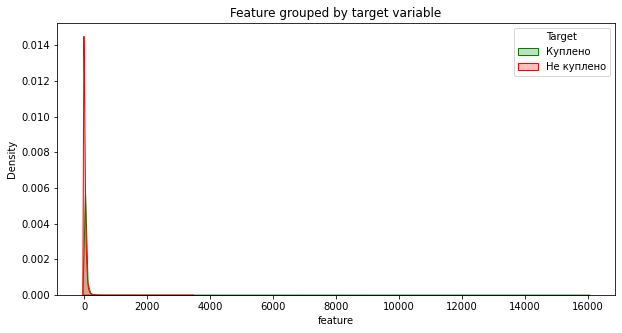

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.41959524154663086, pvalue=0.0)


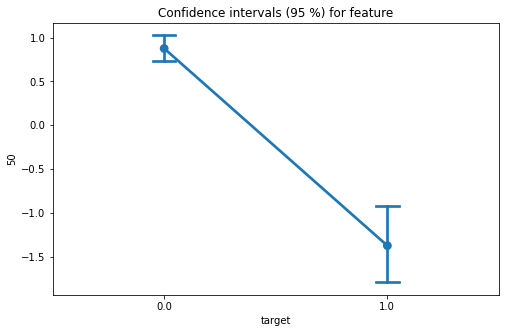

Оценка признака feature = 51


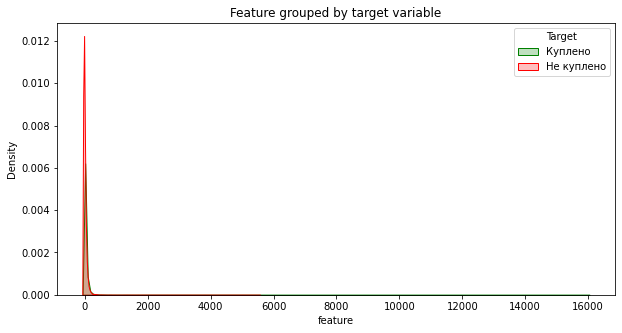

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.3997727632522583, pvalue=0.0)


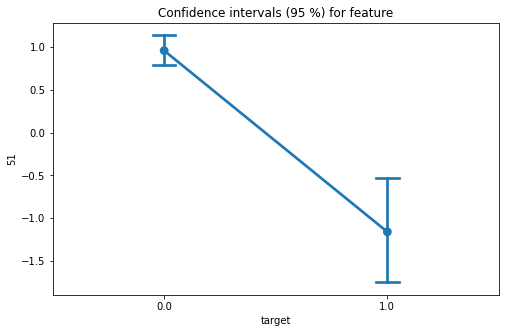

Оценка признака feature = 66


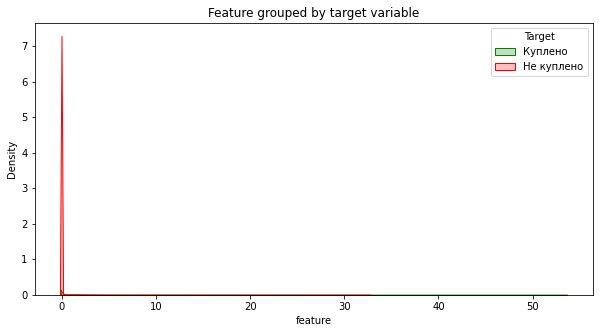

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.07801985740661621, pvalue=0.0)


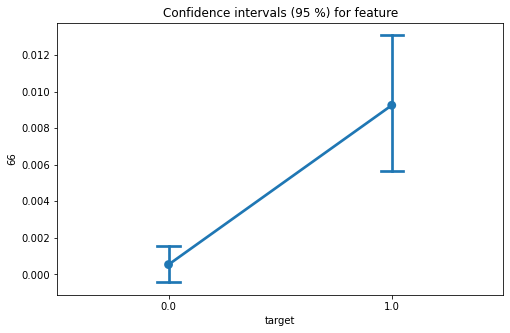

Оценка признака feature = 142


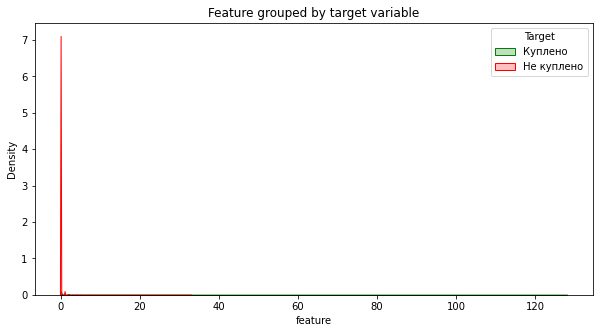

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.04952192306518555, pvalue=0.0)


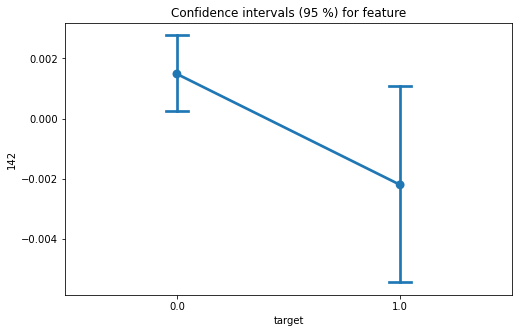

Оценка признака feature = 191


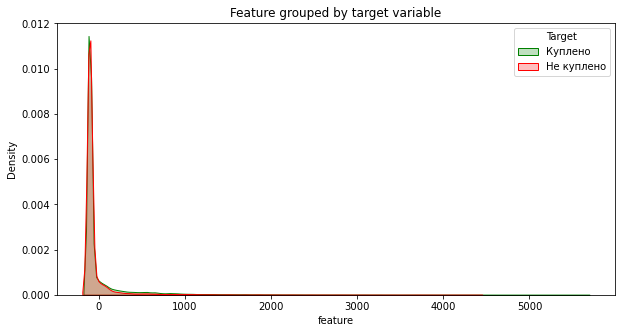

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.39327943325042725, pvalue=0.0)


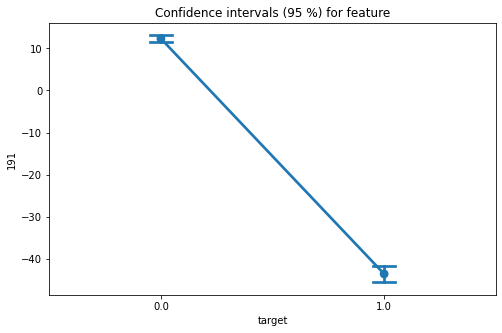

Оценка признака feature = 14


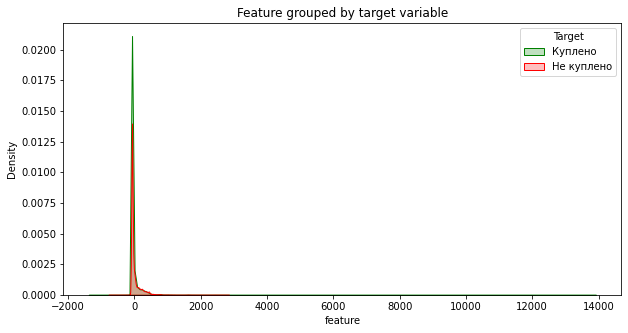

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.5486162900924683, pvalue=0.0)


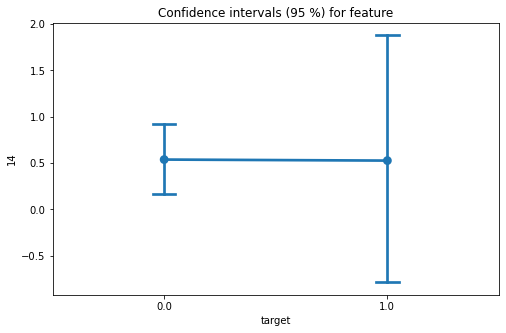

Оценка признака feature = 17


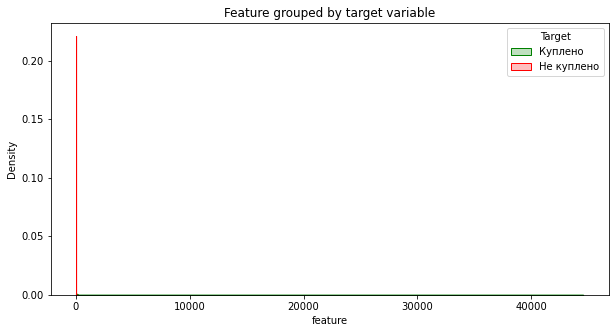

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=5.137920379638672e-05, pvalue=0.0)


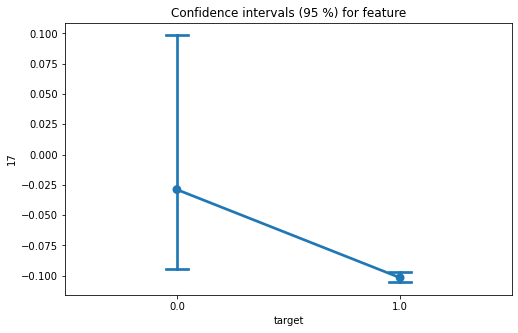

Оценка признака feature = 47


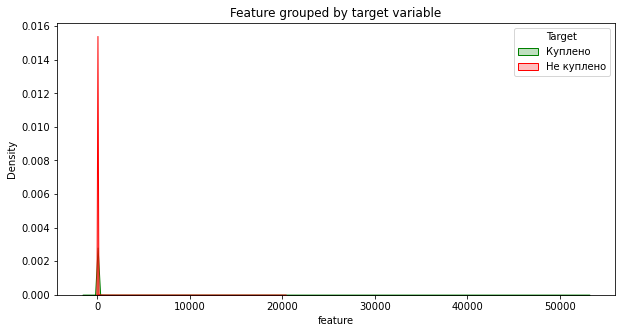

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.012123823165893555, pvalue=0.0)


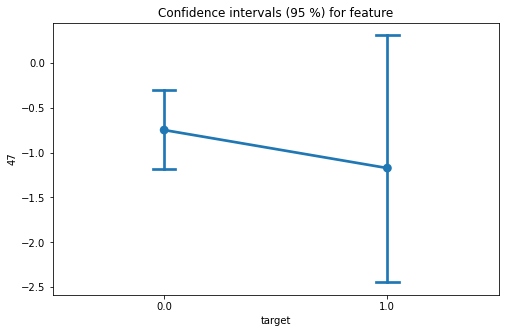

Оценка признака feature = 144


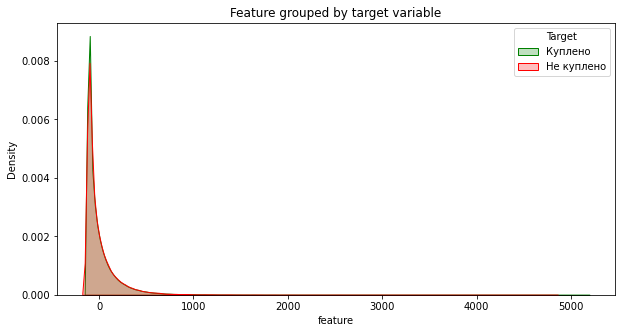

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.635966420173645, pvalue=0.0)


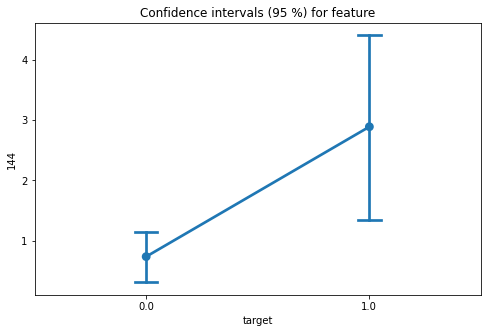

Оценка признака feature = 117


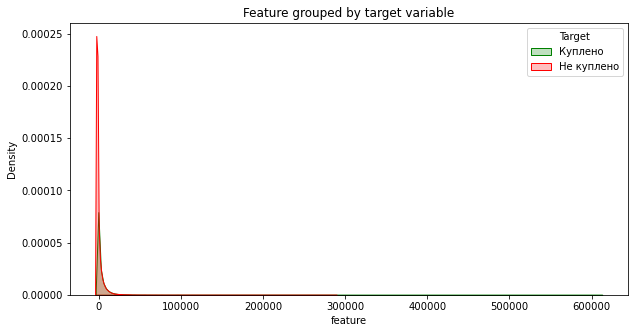

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.38937610387802124, pvalue=0.0)


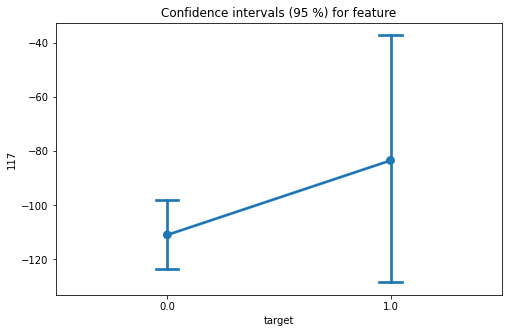

Оценка признака feature = 155


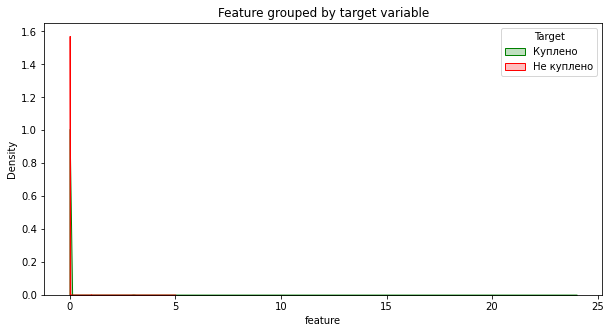

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0011643171310424805, pvalue=0.0)


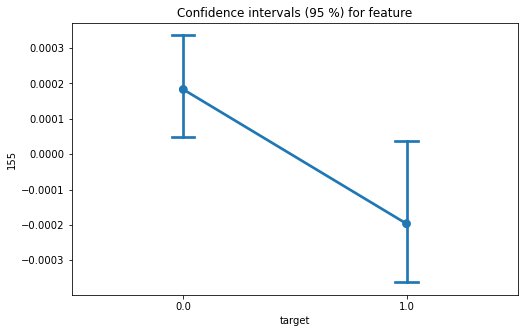

Оценка признака feature = 113


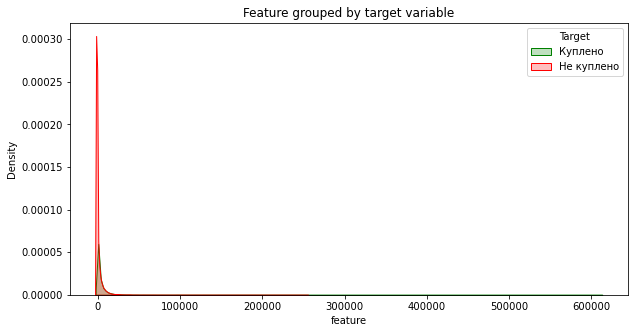

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.3309735059738159, pvalue=0.0)


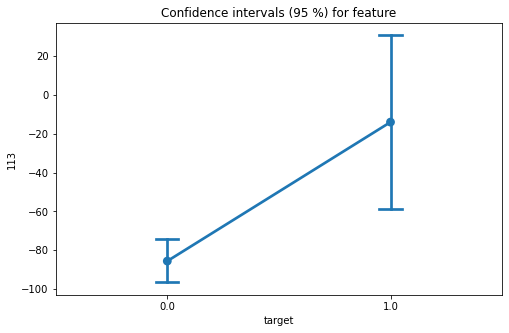

Оценка признака feature = 44


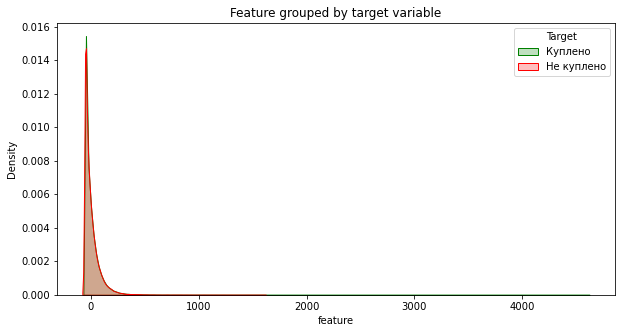

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.6763850450515747, pvalue=0.0)


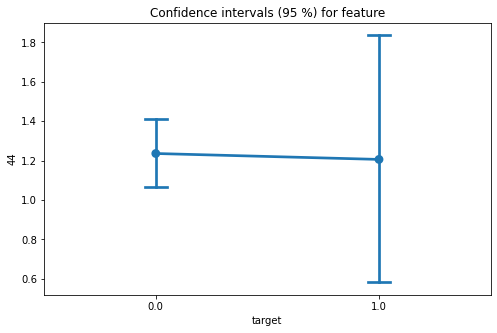

Оценка признака feature = 225


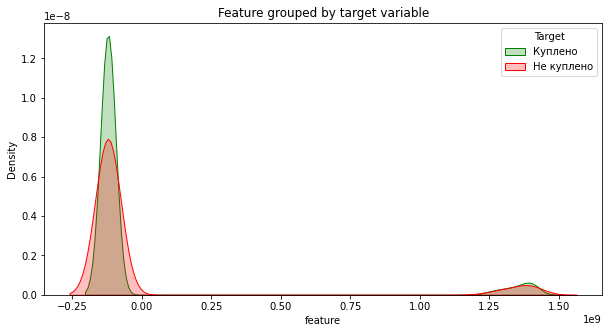

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.3172975182533264, pvalue=0.0)


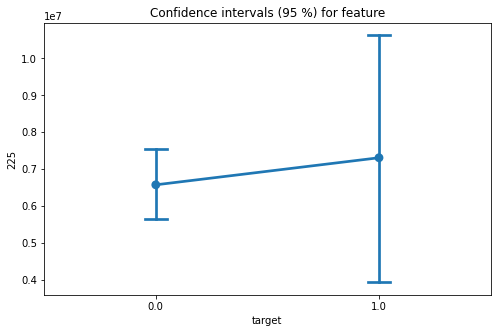

Оценка признака feature = 42


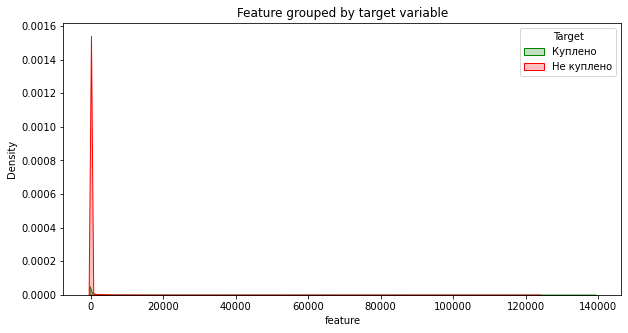

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.056455910205841064, pvalue=0.0)


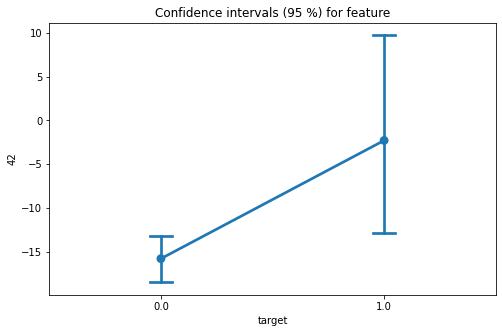

Оценка признака feature = 69


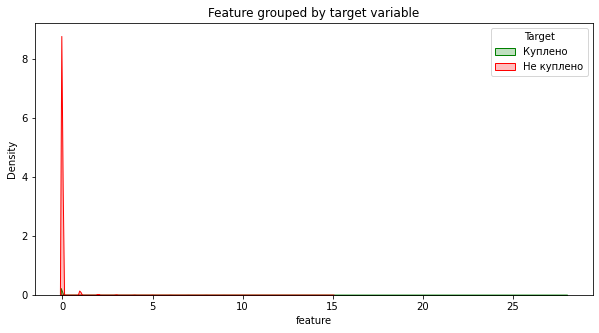

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.10748237371444702, pvalue=0.0)


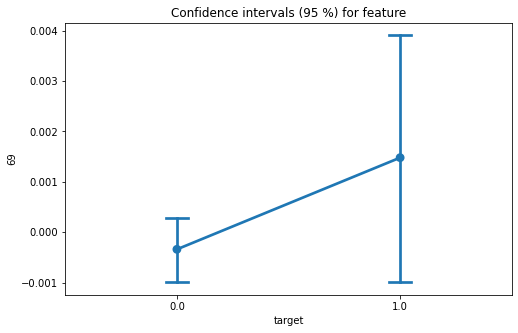

Оценка признака feature = 228


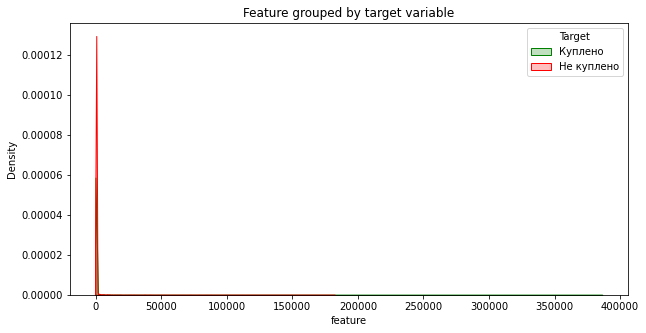

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.007531940937042236, pvalue=0.0)


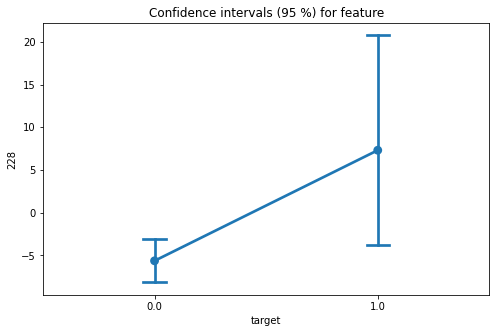

Оценка признака feature = 59


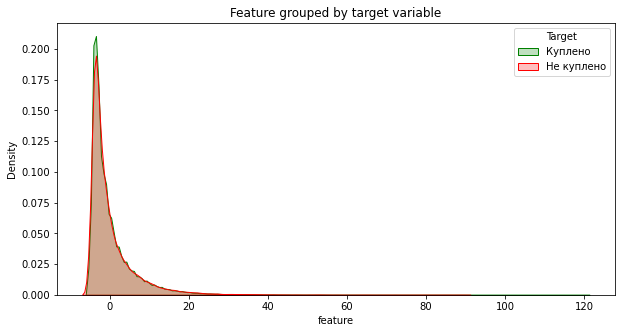

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.6901242733001709, pvalue=0.0)


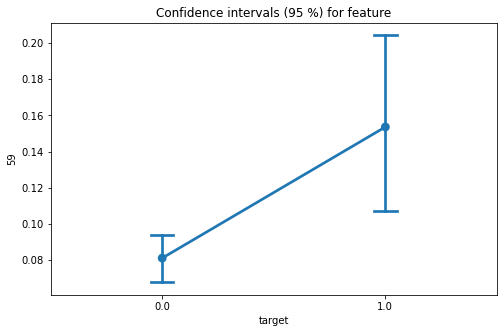

Оценка признака feature = 227


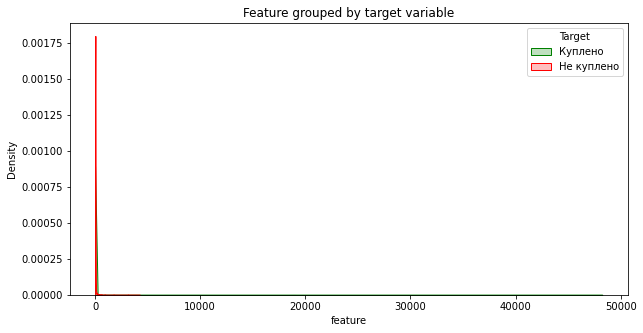

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.004412353038787842, pvalue=0.0)


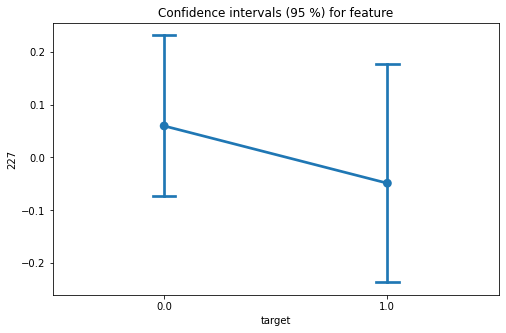

Оценка признака feature = 186


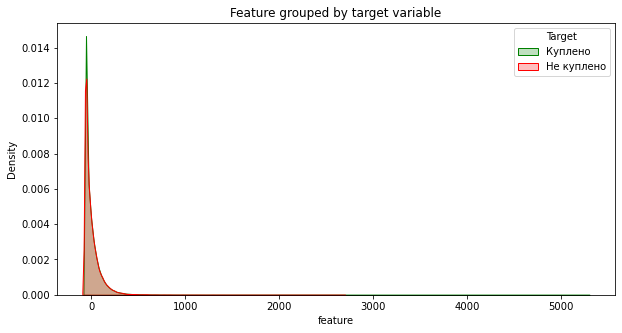

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.6747016906738281, pvalue=0.0)


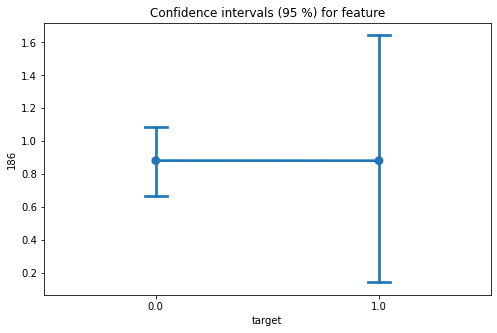

Оценка признака feature = 52


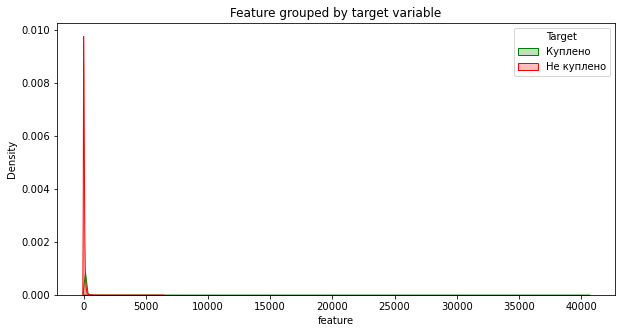

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.3390953540802002, pvalue=0.0)


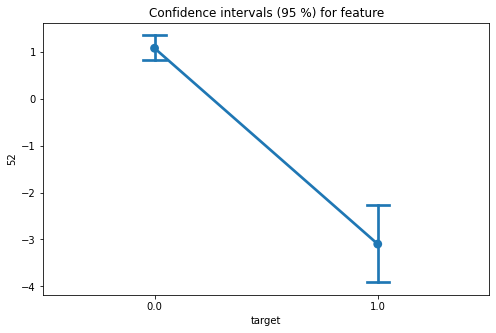

Оценка признака feature = 178


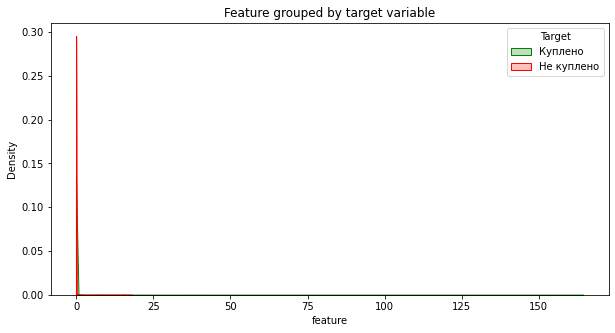

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0019605159759521484, pvalue=0.0)


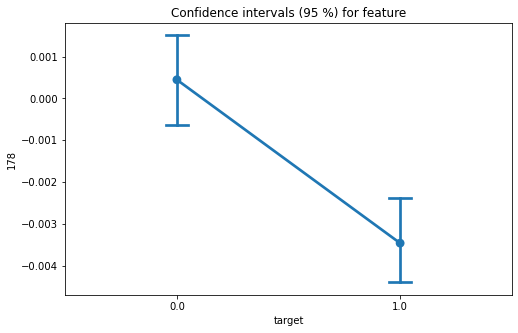

Оценка признака feature = 193


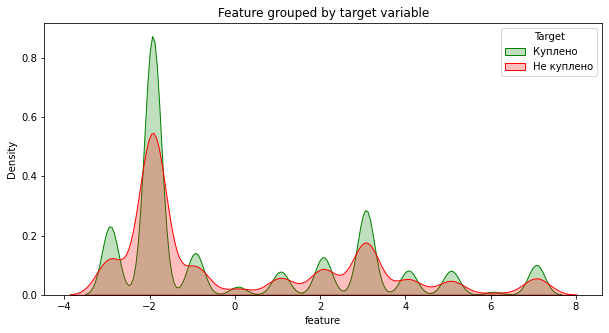

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.8161628842353821, pvalue=0.0)


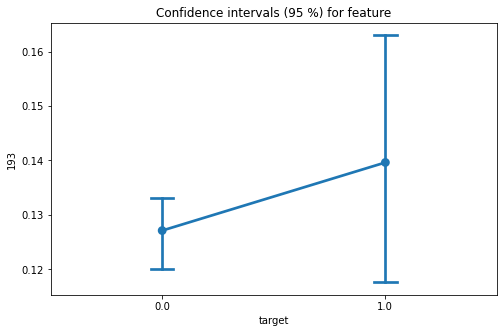

Оценка признака feature = 214


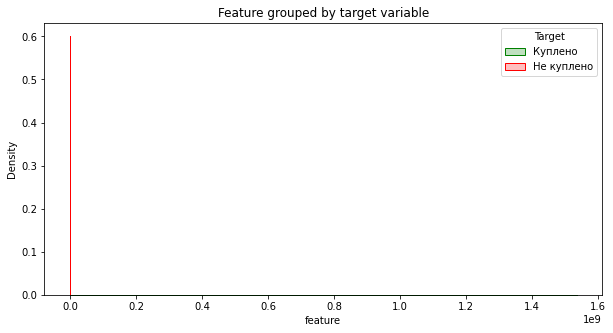

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.00025963783264160156, pvalue=0.0)


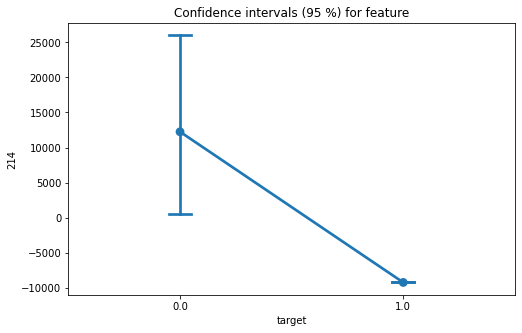

Оценка признака feature = 229


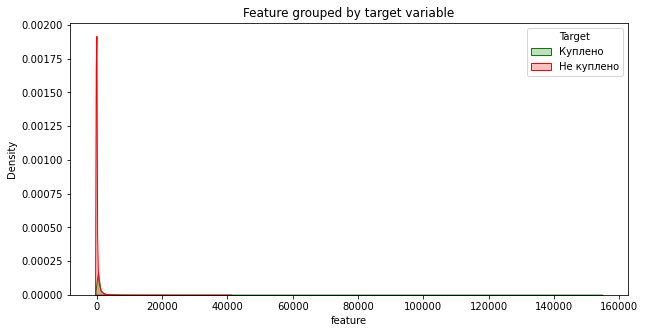

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.2438247799873352, pvalue=0.0)


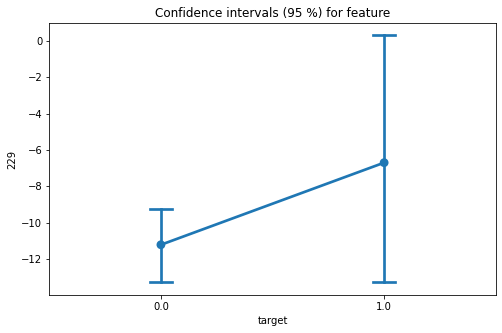

Оценка признака feature = 73


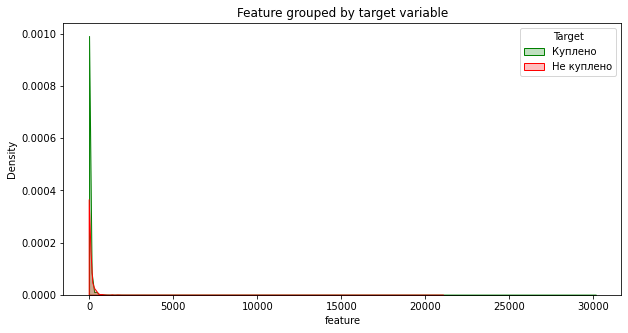

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.04627382755279541, pvalue=0.0)


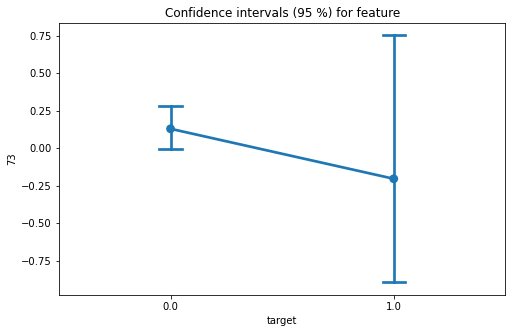

Оценка признака feature = 160


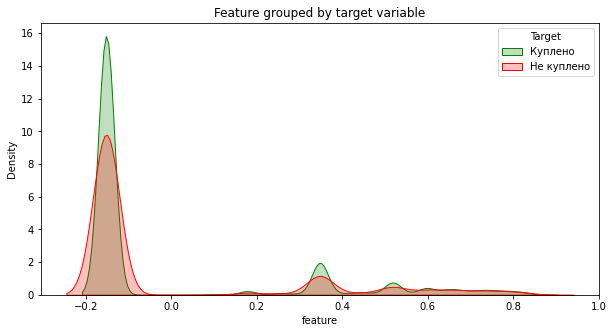

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.5860913991928101, pvalue=0.0)


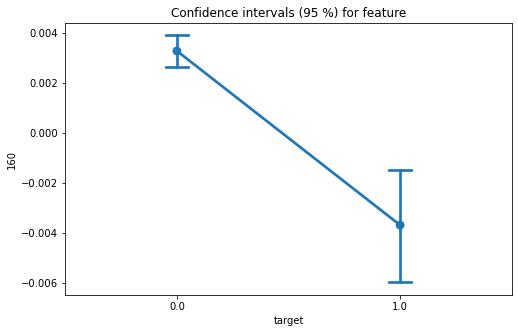

Оценка признака feature = 56


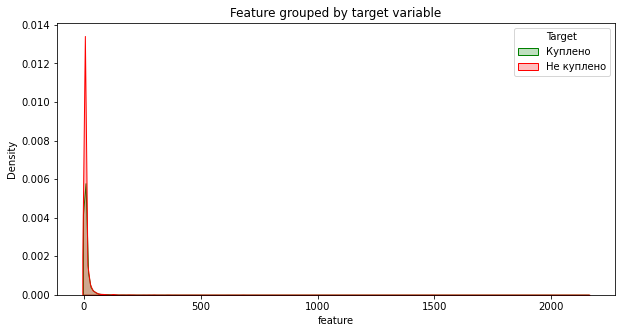

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.09342843294143677, pvalue=0.0)


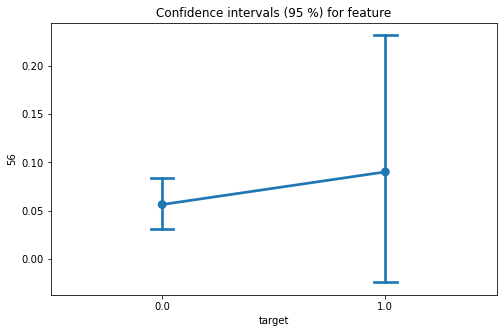

Оценка признака feature = 125


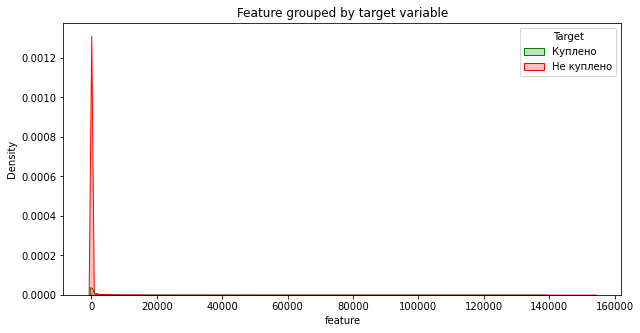

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.09093660116195679, pvalue=0.0)


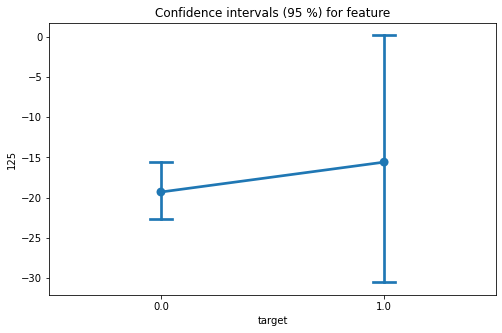

Оценка признака feature = 146


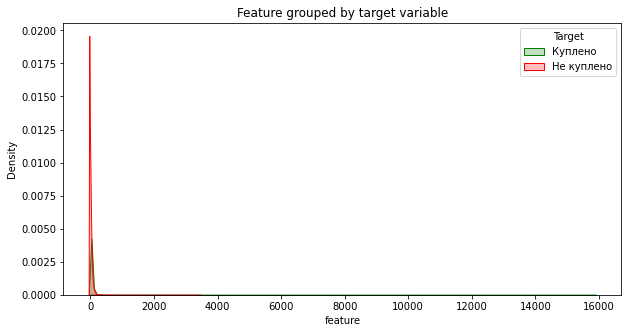

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.40725207328796387, pvalue=0.0)


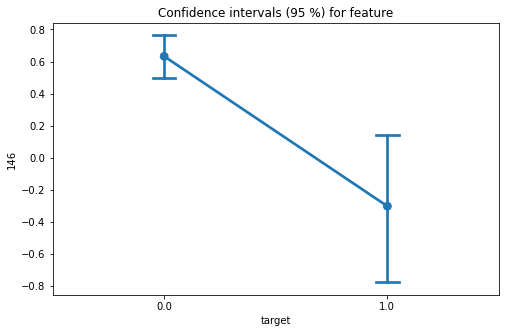

Оценка признака feature = 82


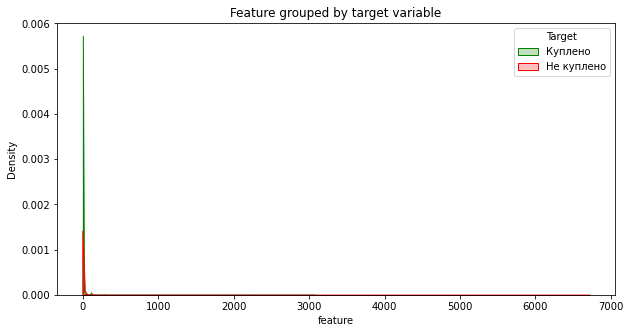

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.005890965461730957, pvalue=0.0)


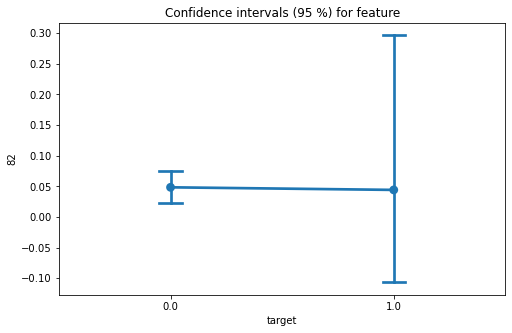

Оценка признака feature = 15


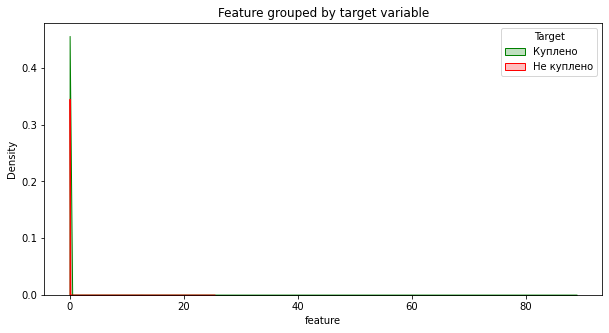

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0001742839813232422, pvalue=0.0)


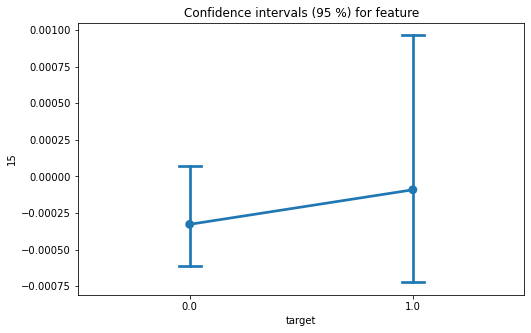

Оценка признака feature = 135


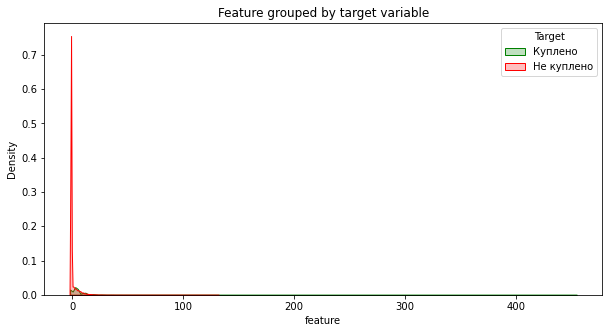

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.3611077070236206, pvalue=0.0)


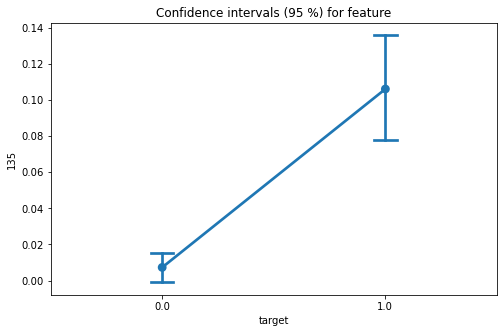

Оценка признака feature = 166


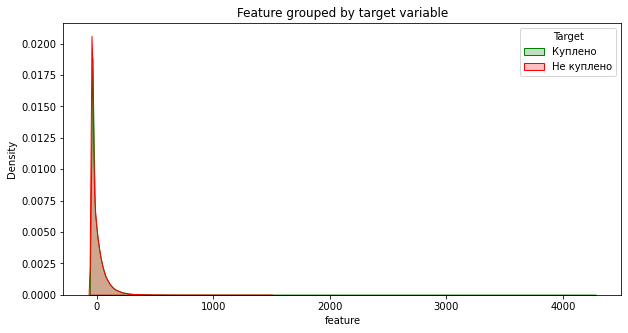

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.632157564163208, pvalue=0.0)


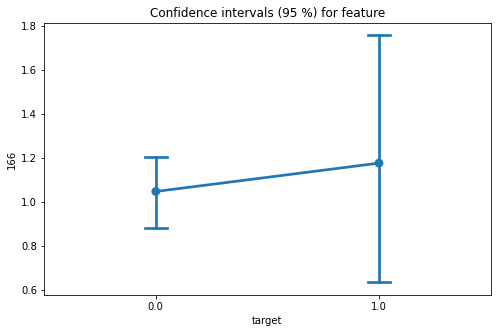

Оценка признака feature = 245


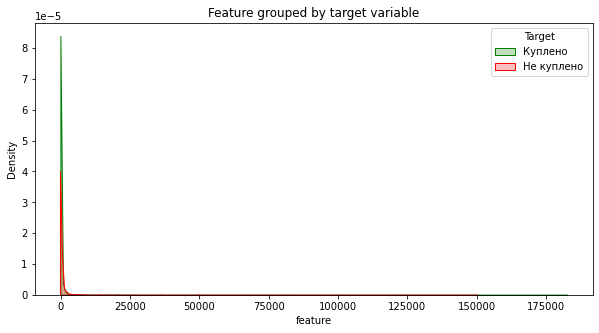

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.010667026042938232, pvalue=0.0)


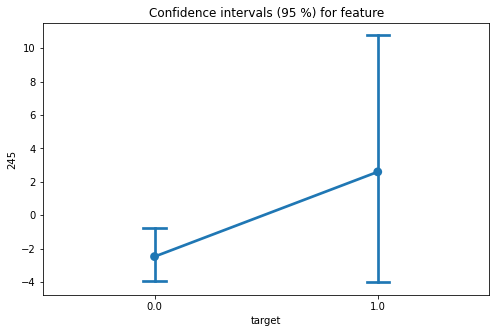

Оценка признака feature = 40


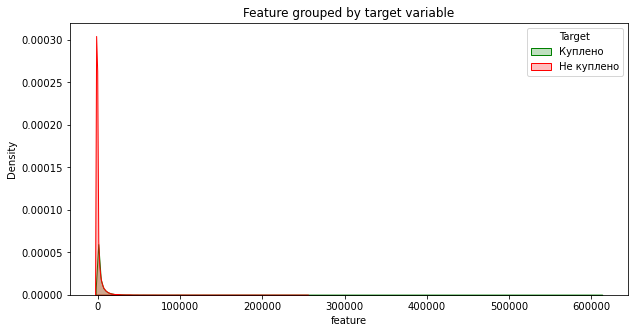

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.33088791370391846, pvalue=0.0)


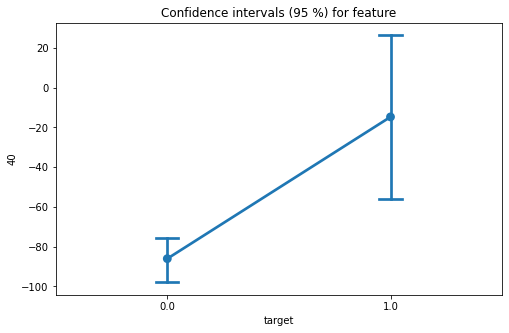

Оценка признака feature = 97


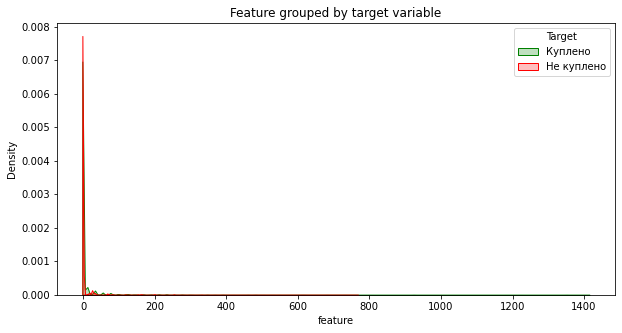

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.016942501068115234, pvalue=0.0)


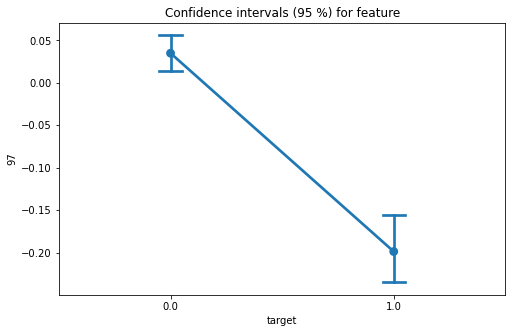

Оценка признака feature = 122


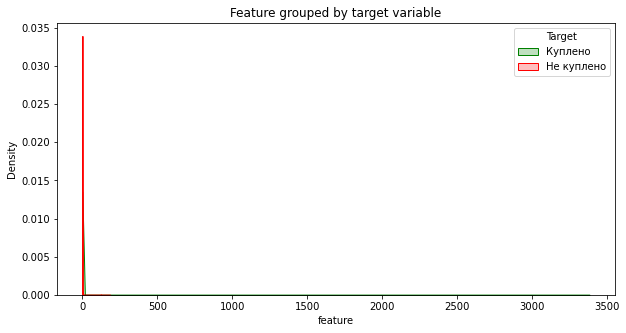

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0004913210868835449, pvalue=0.0)


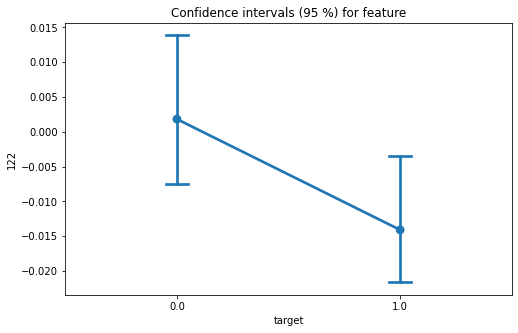

Оценка признака feature = 218


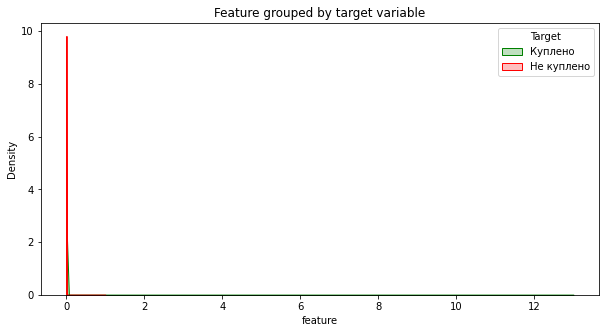

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.00010973215103149414, pvalue=0.0)


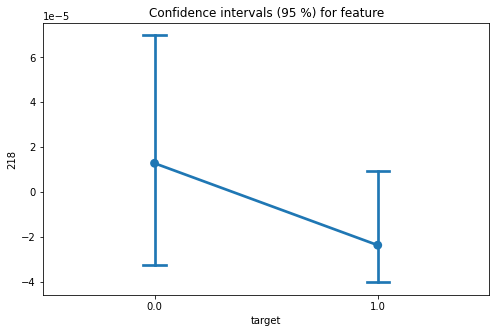

Оценка признака feature = 207


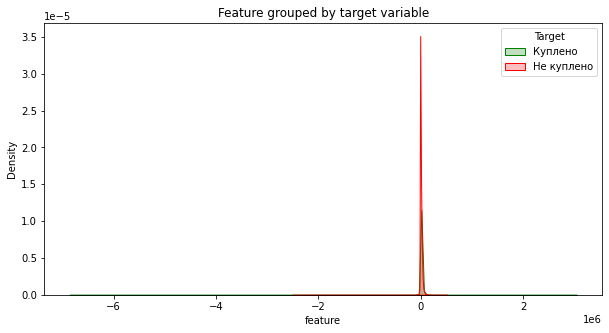

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.3593369722366333, pvalue=0.0)


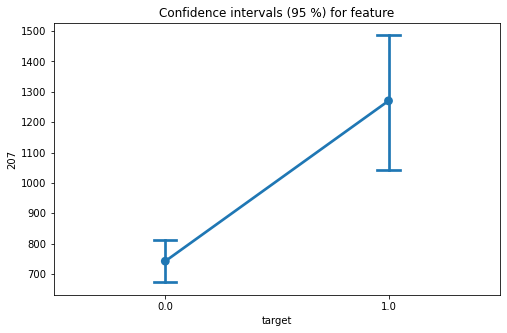

Оценка признака feature = 36


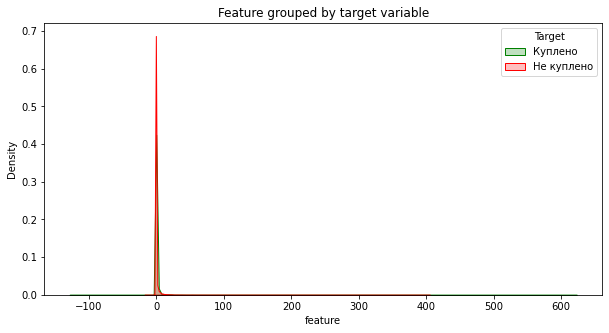

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.13703835010528564, pvalue=0.0)


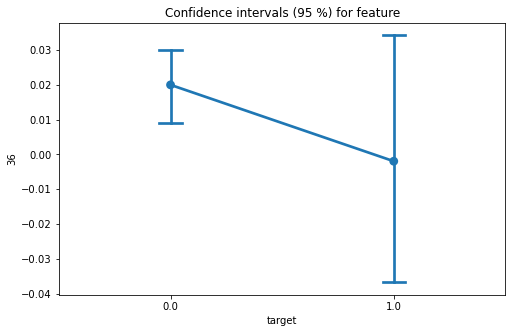

Оценка признака feature = 63


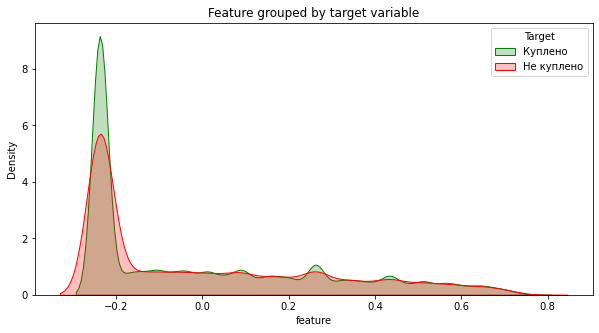

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.820965051651001, pvalue=0.0)


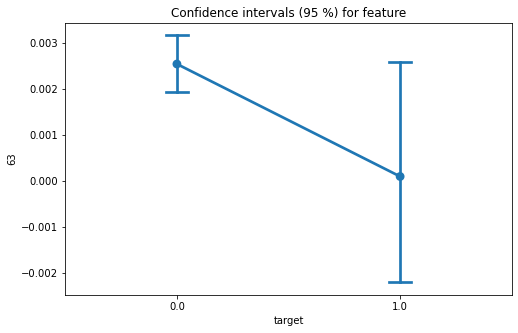

Оценка признака feature = 247


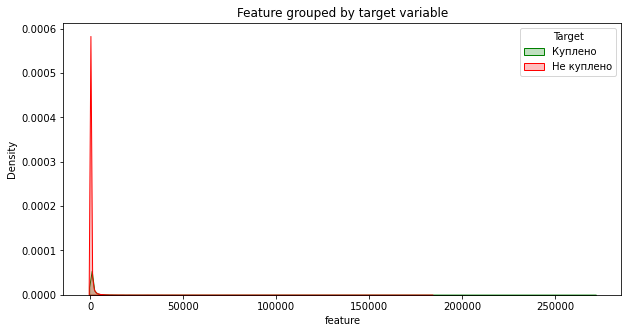

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.14500945806503296, pvalue=0.0)


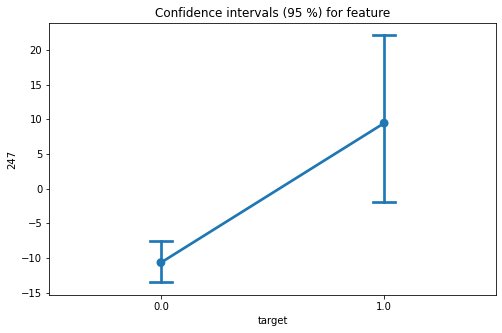

Оценка признака feature = 60


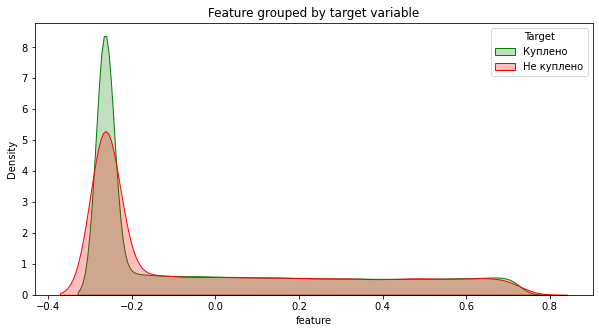

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.793942928314209, pvalue=0.0)


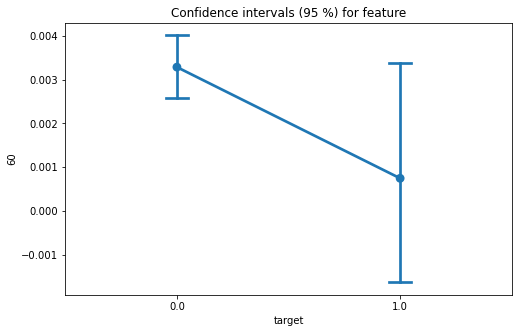

Оценка признака feature = 19


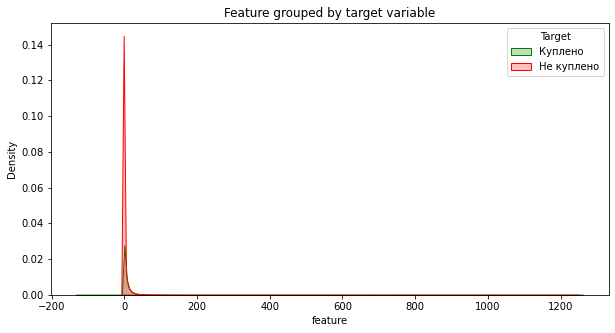

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.21671748161315918, pvalue=0.0)


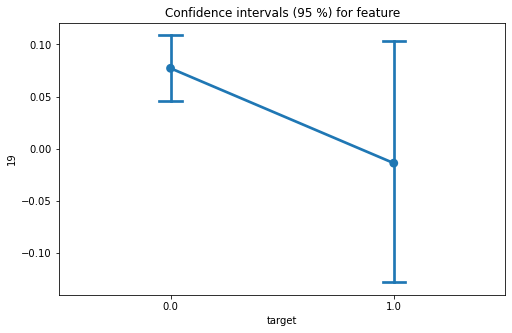

Оценка признака feature = 99


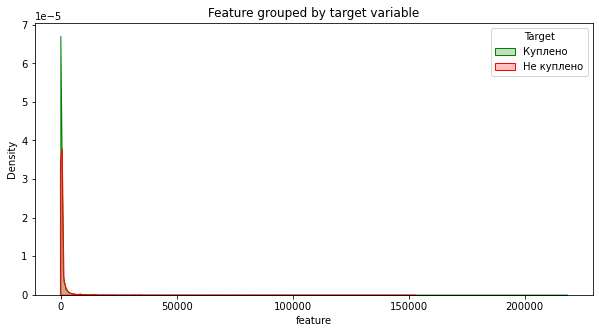

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.017271697521209717, pvalue=0.0)


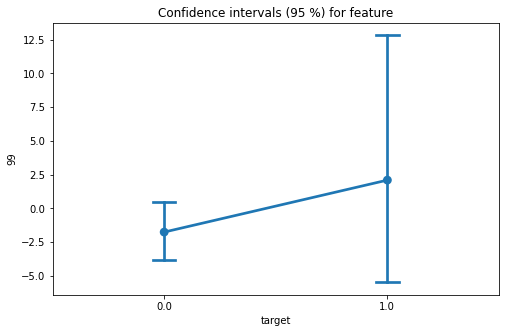

Оценка признака feature = 183


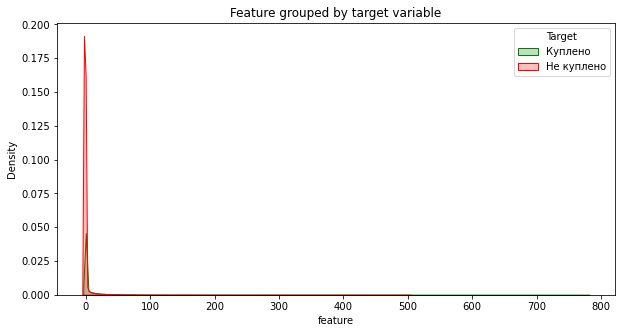

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.15761494636535645, pvalue=0.0)


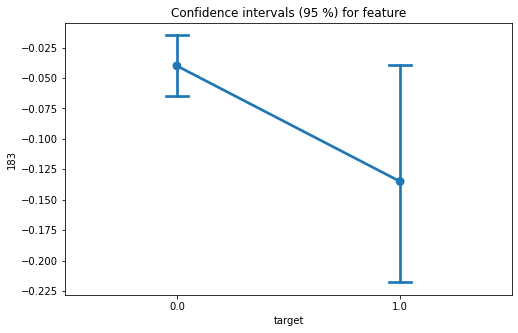

Оценка признака feature = 162


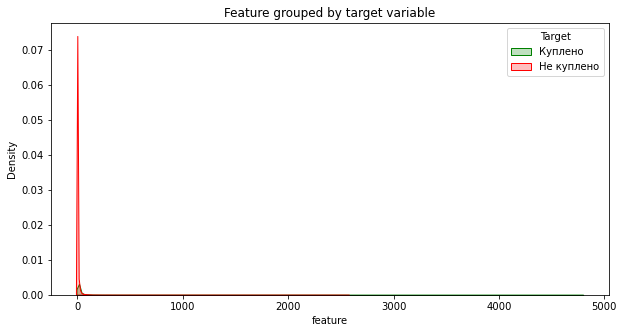

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.14923900365829468, pvalue=0.0)


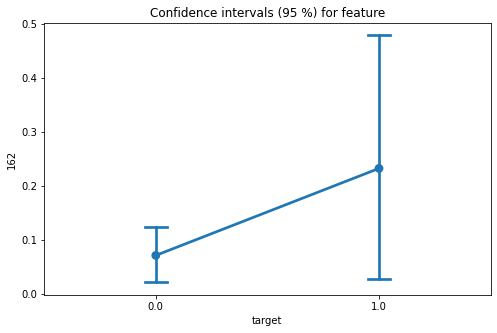

Оценка признака feature = 180


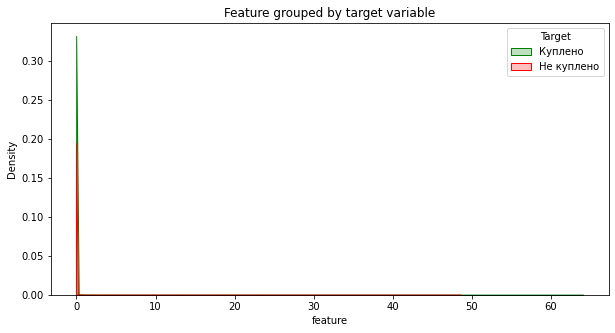

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.001571953296661377, pvalue=0.0)


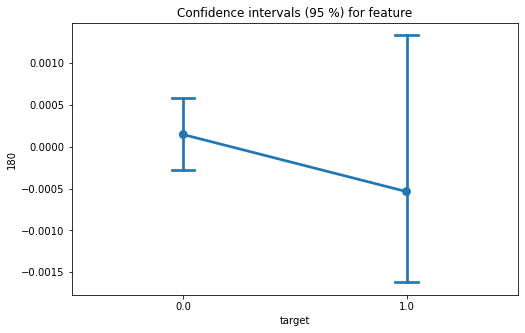

Оценка признака feature = 163


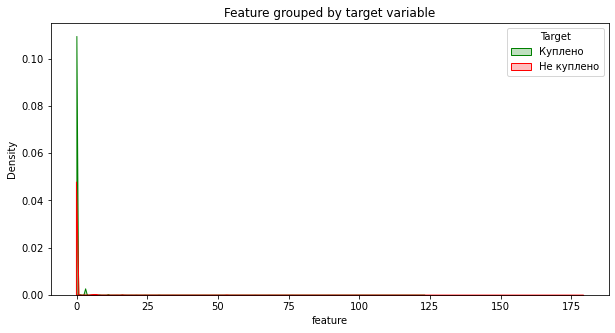

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.00595933198928833, pvalue=0.0)


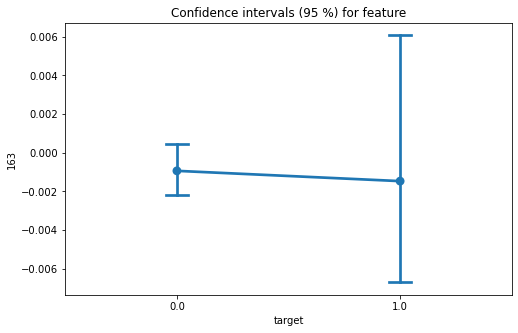

Оценка признака feature = 95


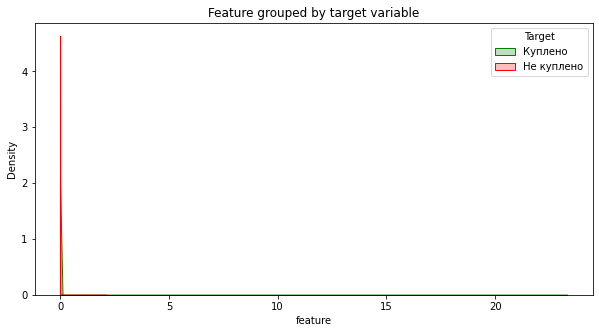

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=8.428096771240234e-05, pvalue=0.0)


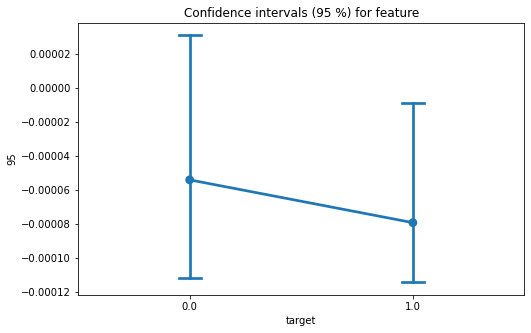

Оценка признака feature = 137


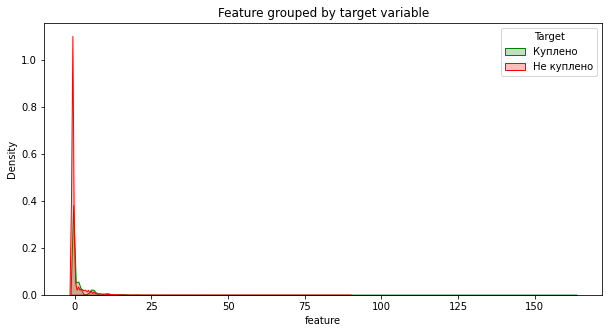

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.3669554591178894, pvalue=0.0)


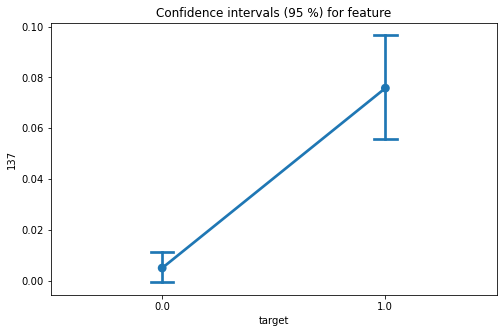

Оценка признака feature = 114


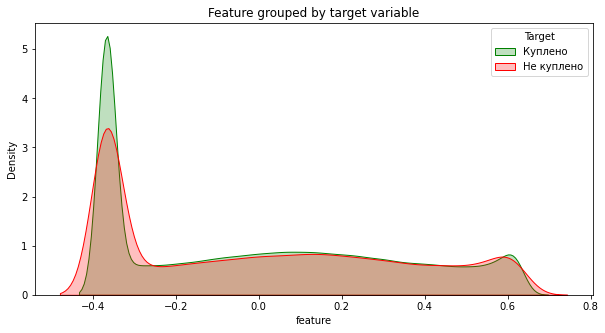

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.8926831483840942, pvalue=0.0)


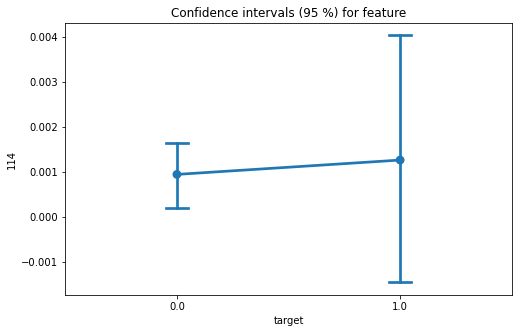

Оценка признака feature = vas_id


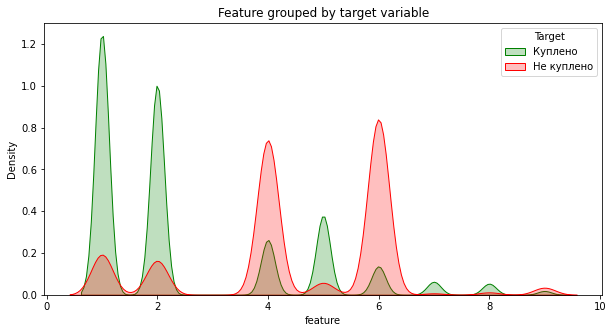

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.8014726042747498, pvalue=0.0)


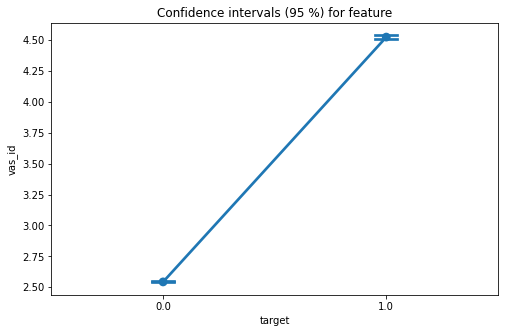

Оценка признака feature = 100


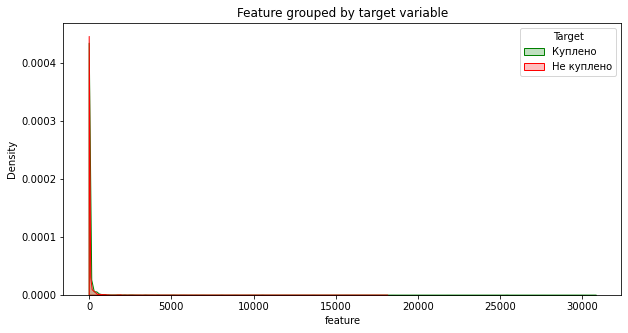

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.008804857730865479, pvalue=0.0)


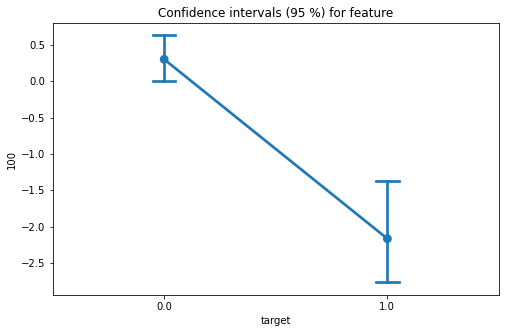

Оценка признака feature = 80


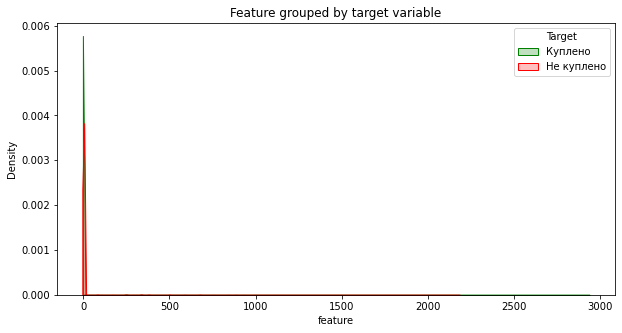

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.003849029541015625, pvalue=0.0)


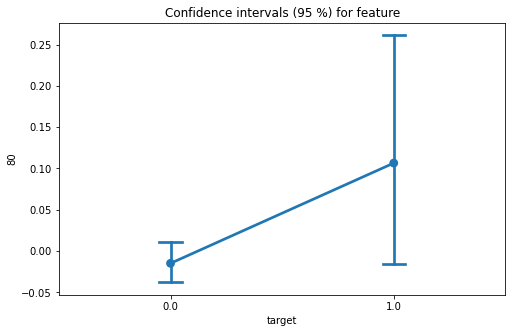

Оценка признака feature = 7


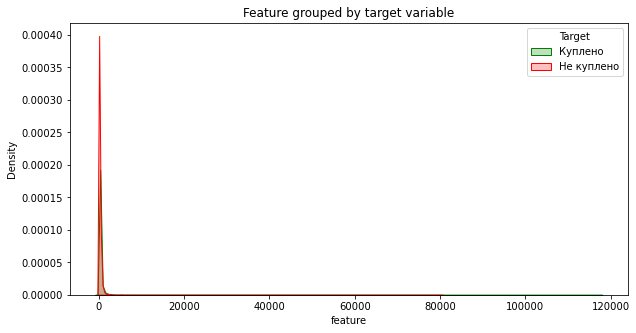

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.15045392513275146, pvalue=0.0)


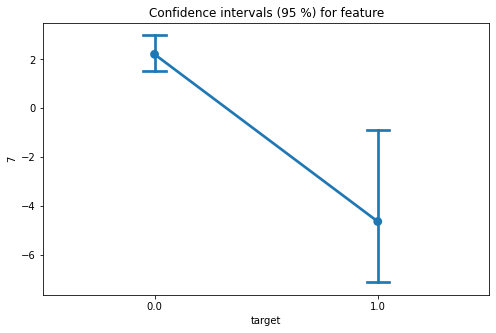

Оценка признака feature = 153


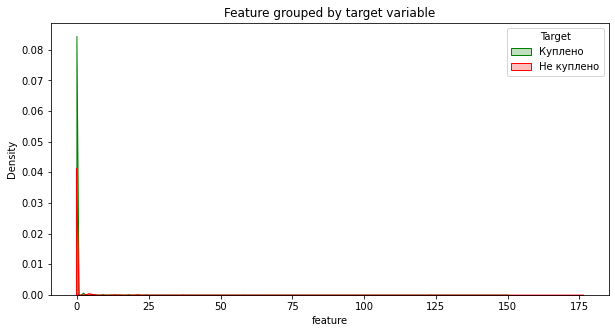

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.008732497692108154, pvalue=0.0)


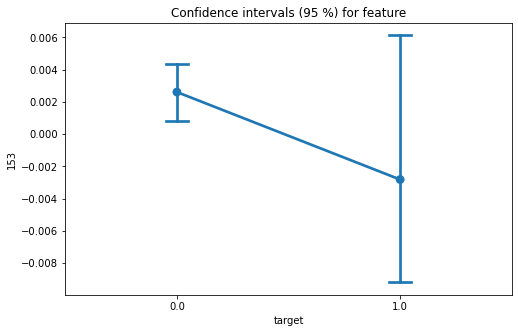

Оценка признака feature = 220


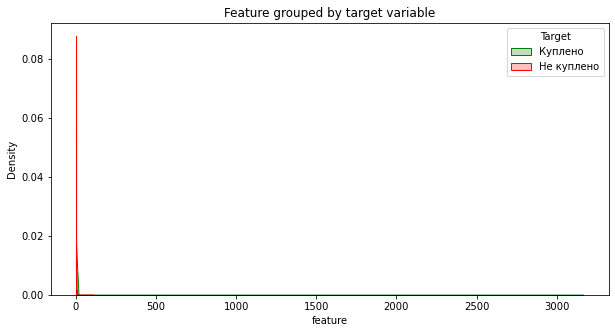

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.00011962652206420898, pvalue=0.0)


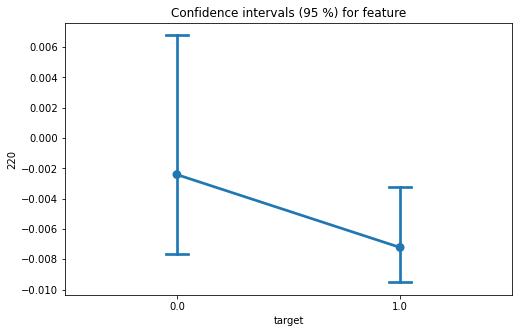

Оценка признака feature = 9


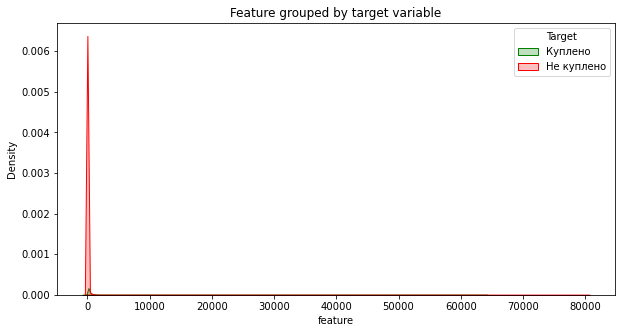

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.09960287809371948, pvalue=0.0)


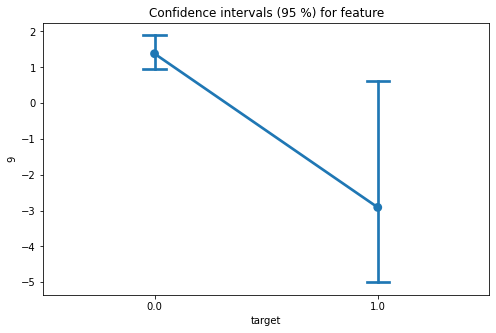

Оценка признака feature = 68


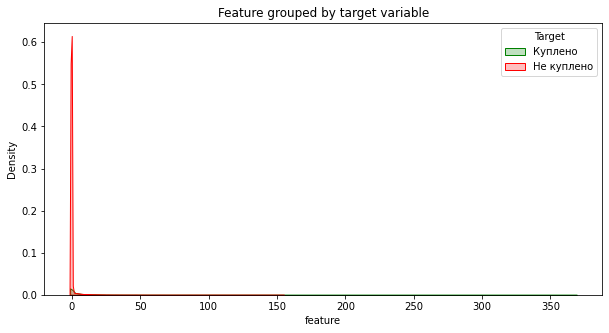

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.12107658386230469, pvalue=0.0)


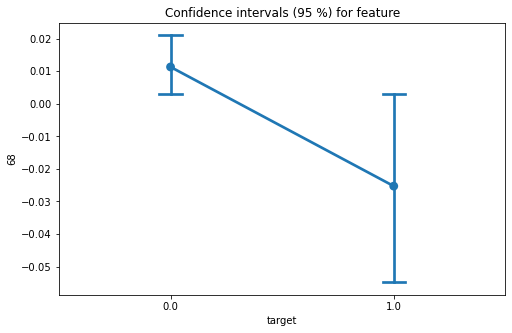

Оценка признака feature = 174


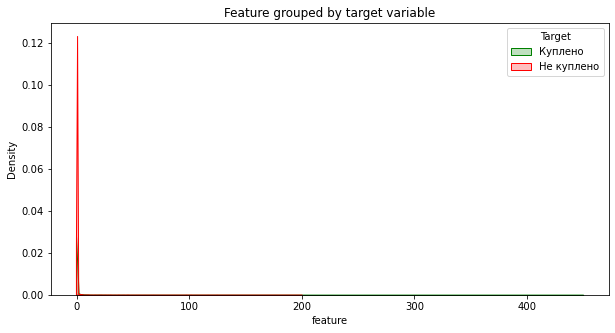

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.010466992855072021, pvalue=0.0)


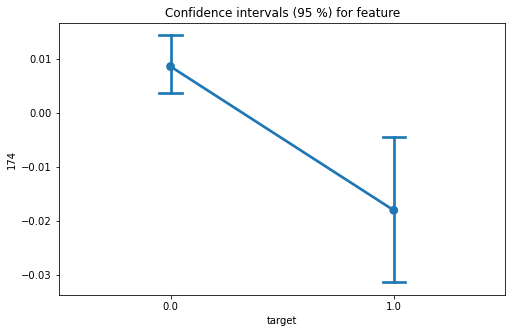

Оценка признака feature = 189


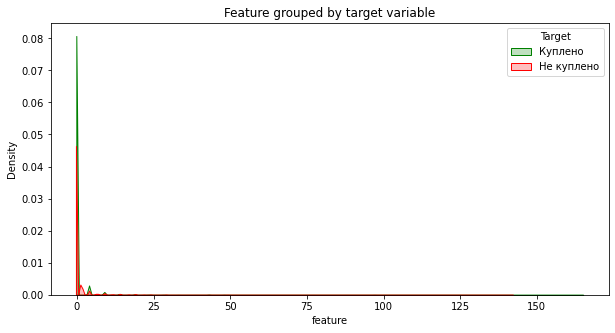

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.017163753509521484, pvalue=0.0)


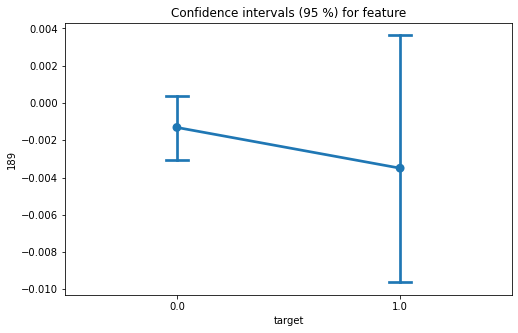

Оценка признака feature = 55


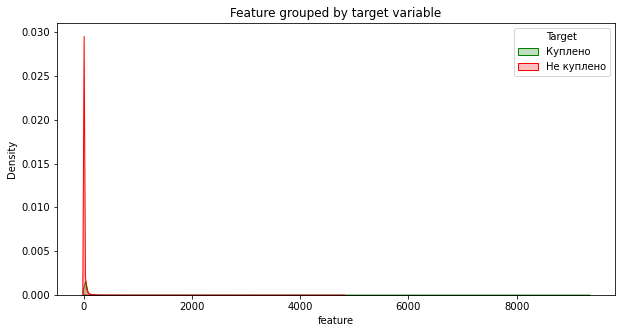

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.18782544136047363, pvalue=0.0)


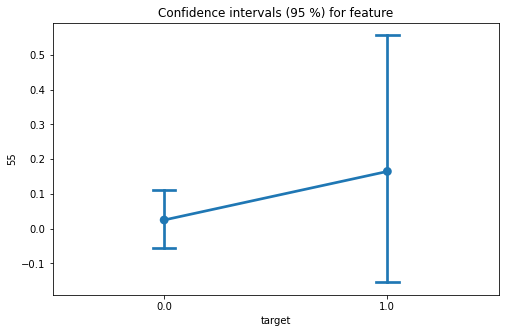

Оценка признака feature = 143


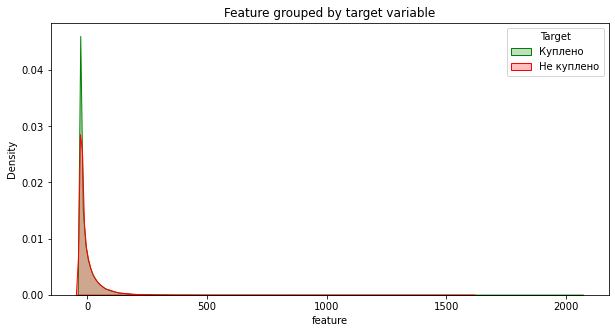

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.5824453830718994, pvalue=0.0)


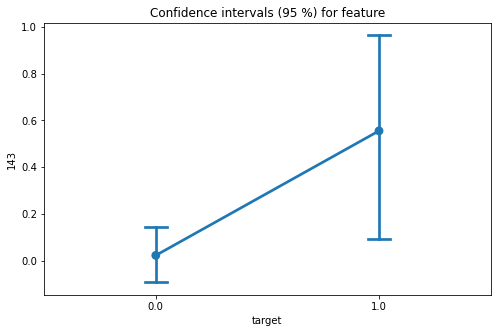

Оценка признака feature = 12


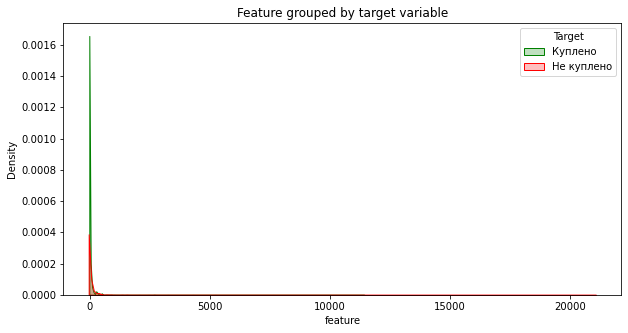

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.027757763862609863, pvalue=0.0)


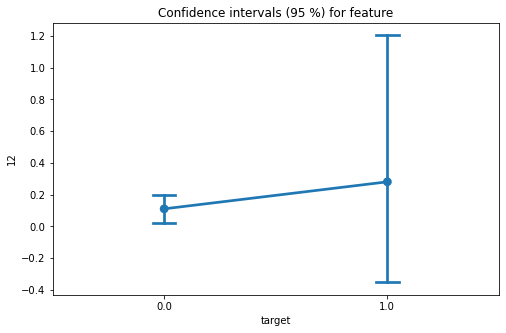

Оценка признака feature = 141


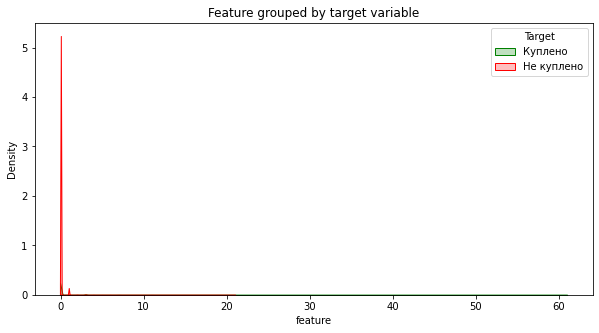

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.04293876886367798, pvalue=0.0)


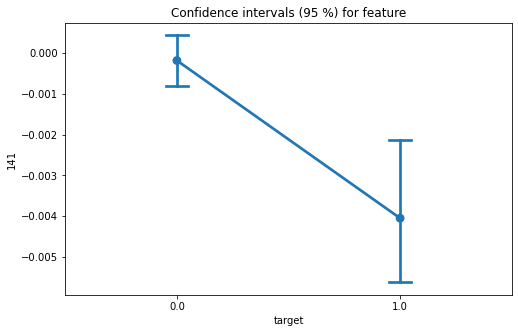

Оценка признака feature = 235


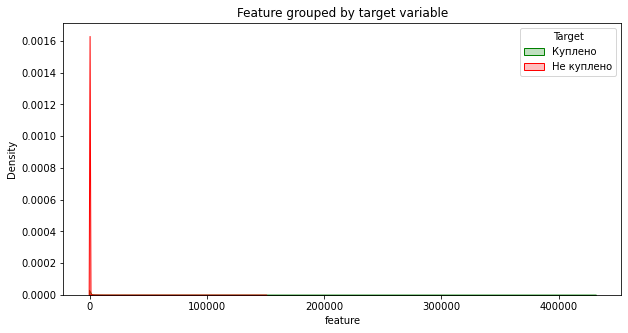

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.02215367555618286, pvalue=0.0)


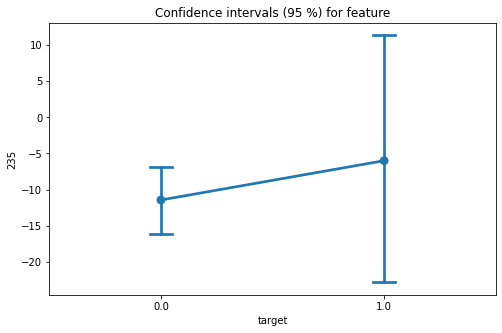

Оценка признака feature = 94


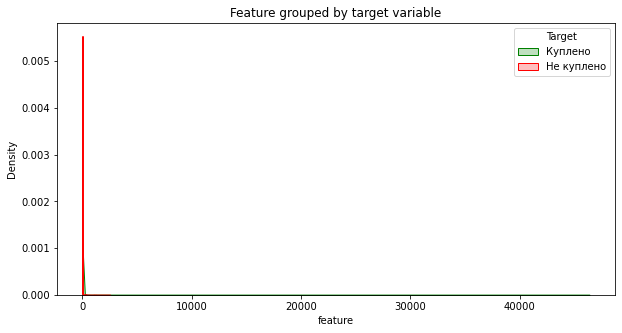

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0016720890998840332, pvalue=0.0)


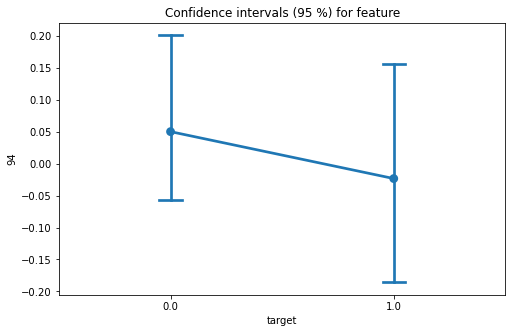

Оценка признака feature = 145


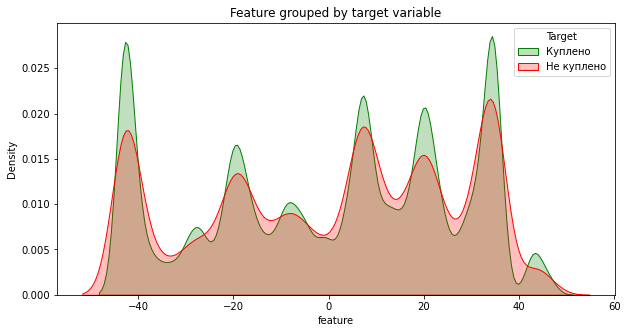

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.9356812834739685, pvalue=0.0)


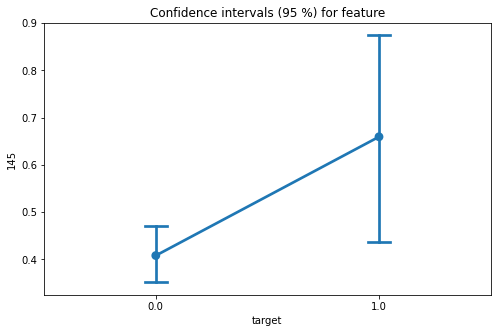

Оценка признака feature = 18


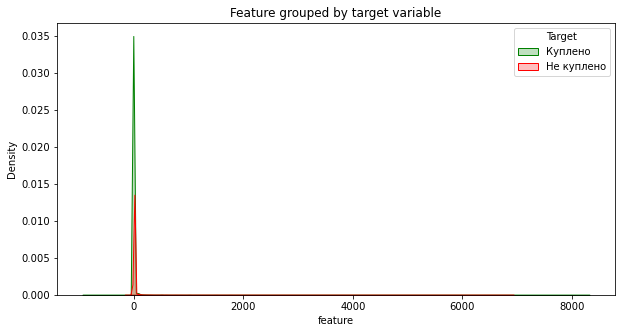

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.053805410861968994, pvalue=0.0)


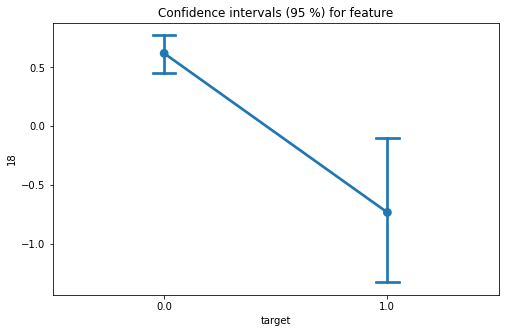

Оценка признака feature = 232


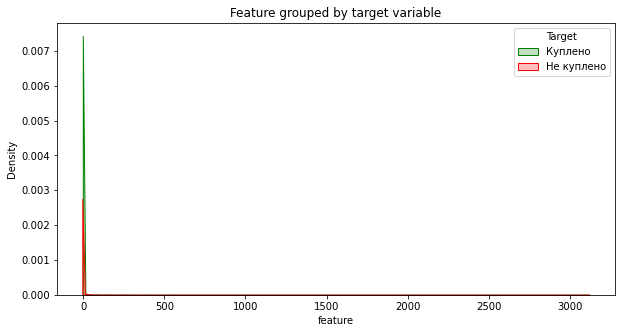

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0026805996894836426, pvalue=0.0)


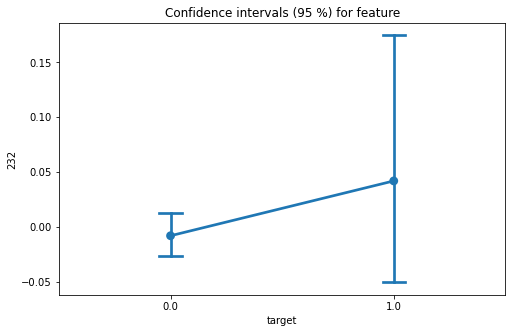

Оценка признака feature = 176


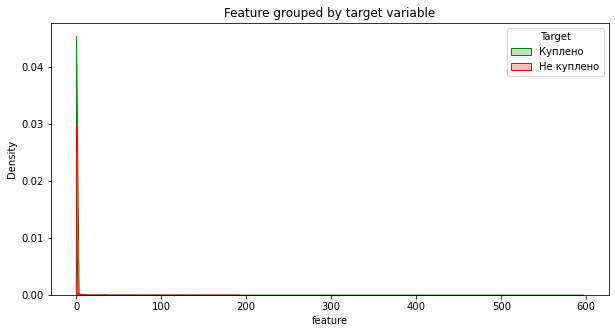

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.006830096244812012, pvalue=0.0)


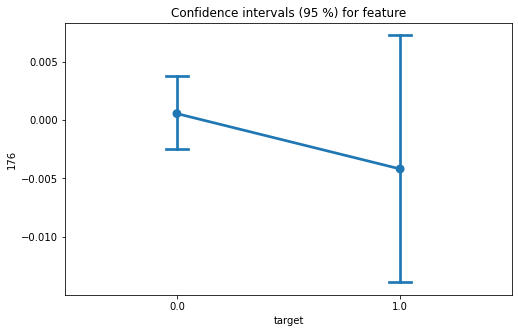

Оценка признака feature = 35


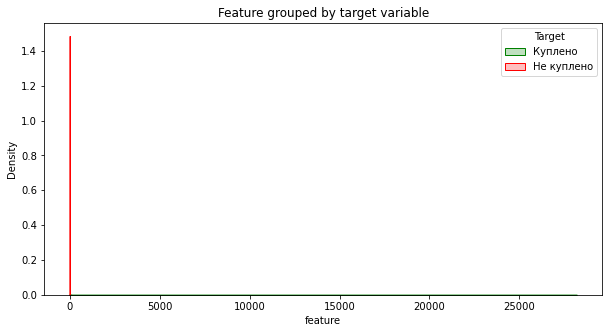

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=5.608797073364258e-05, pvalue=0.0)


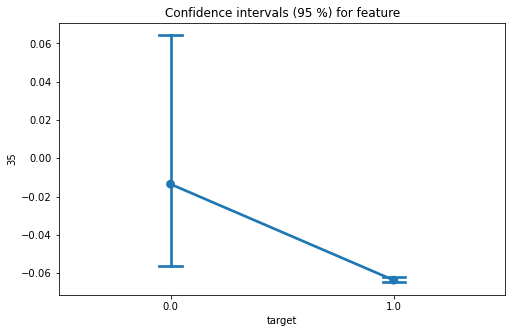

Оценка признака feature = 148


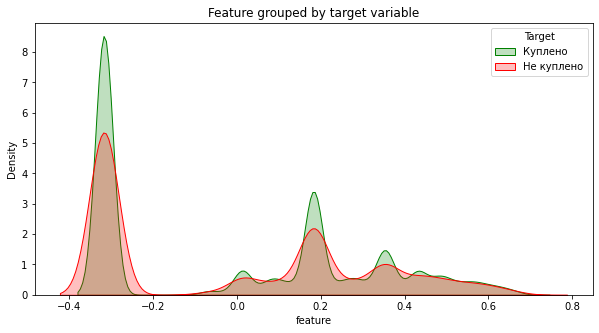

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.8274847269058228, pvalue=0.0)


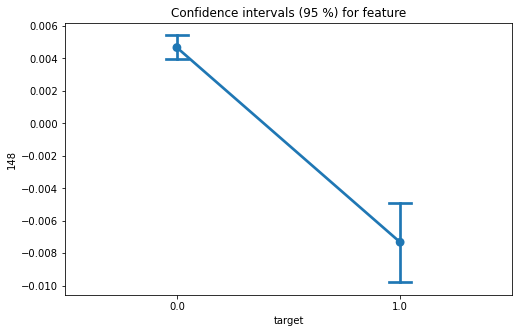

Оценка признака feature = 46


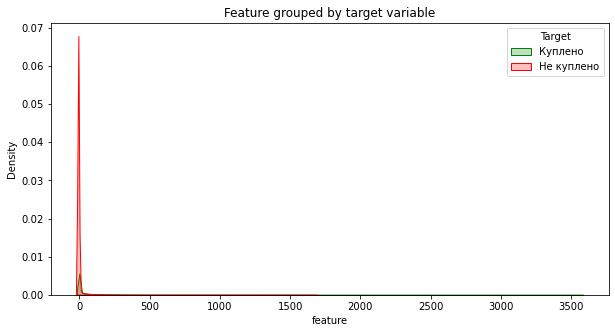

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.14944571256637573, pvalue=0.0)


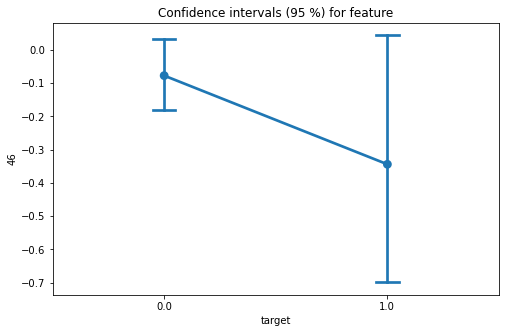

Оценка признака feature = 116


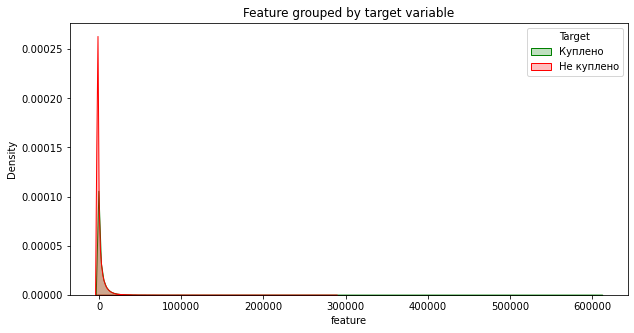

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.4345189929008484, pvalue=0.0)


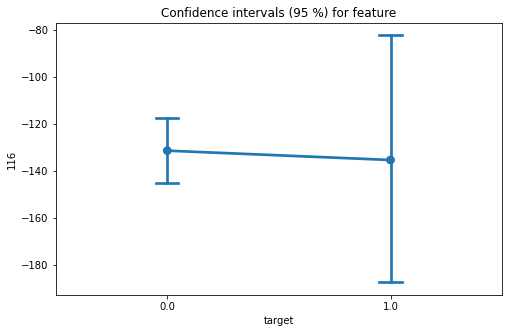

Оценка признака feature = 124


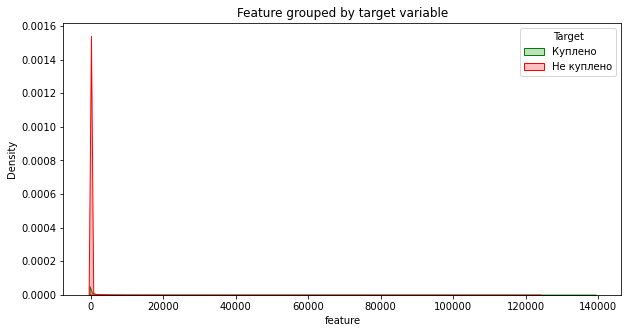

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.05639815330505371, pvalue=0.0)


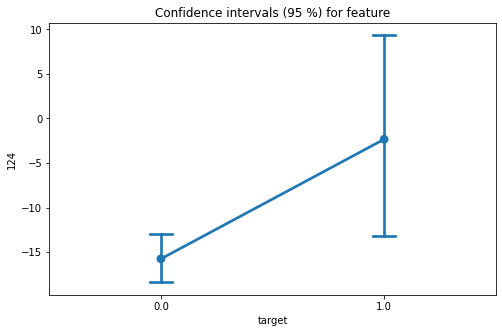

Оценка признака feature = 118


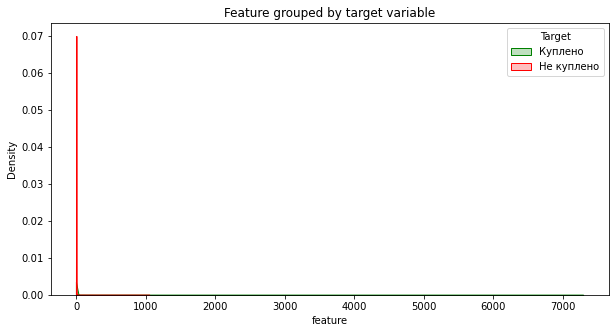

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.004053652286529541, pvalue=0.0)


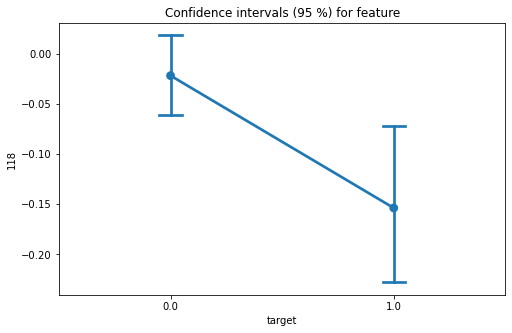

Оценка признака feature = 226


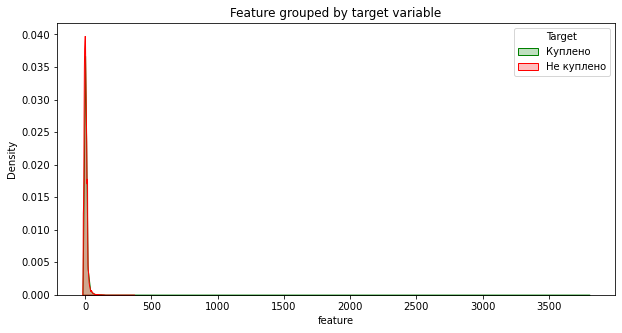

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.7327333092689514, pvalue=0.0)


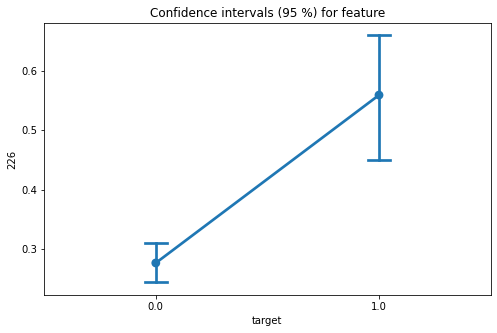

Оценка признака feature = 62


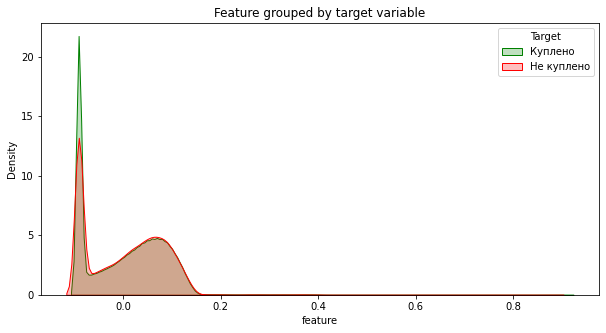

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.8842101693153381, pvalue=0.0)


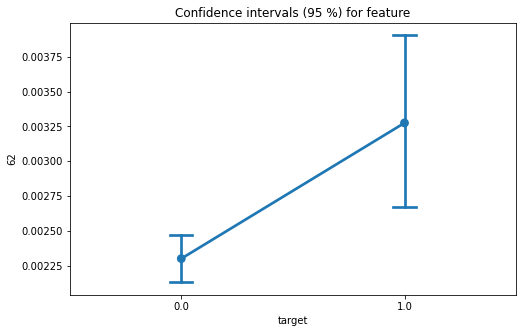

Оценка признака feature = 177


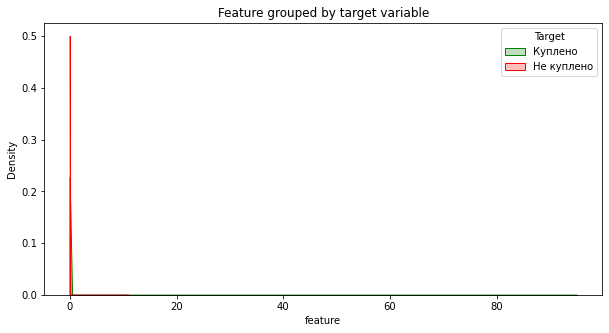

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.002338707447052002, pvalue=0.0)


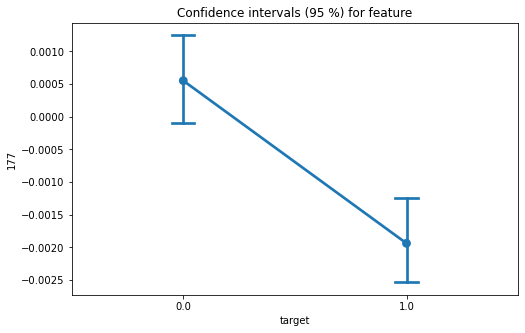

Оценка признака feature = 138


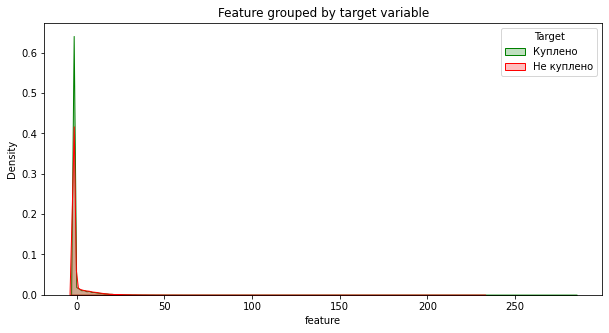

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.38238537311553955, pvalue=0.0)


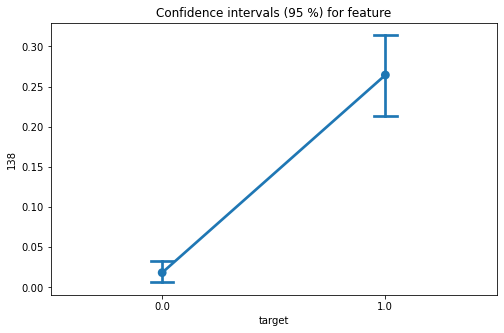

Оценка признака feature = 28


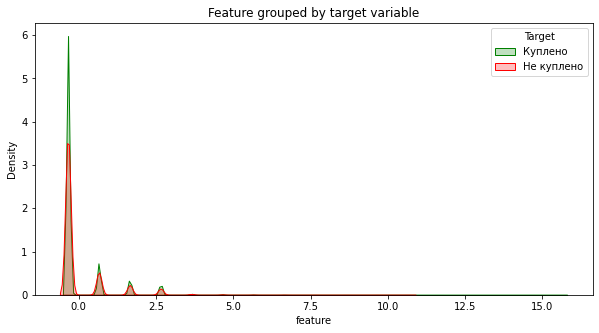

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.48093700408935547, pvalue=0.0)


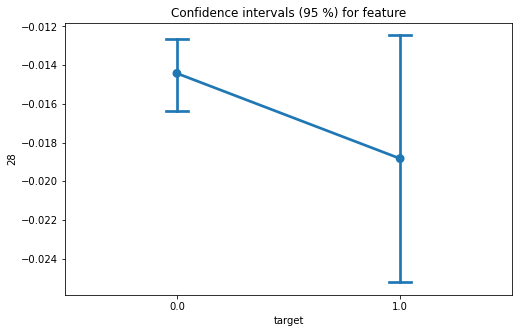

Оценка признака feature = 88


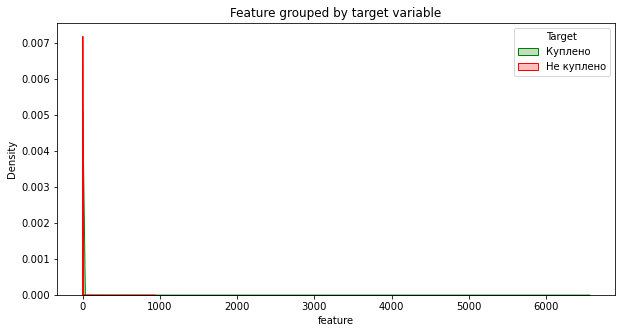

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.001268923282623291, pvalue=0.0)


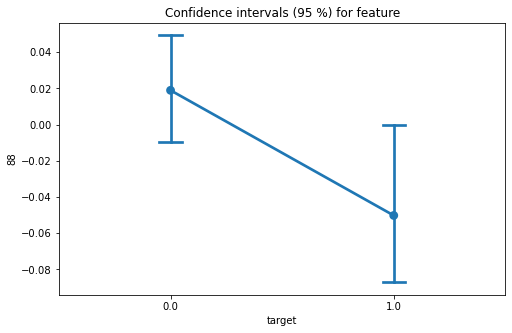

Оценка признака feature = 149


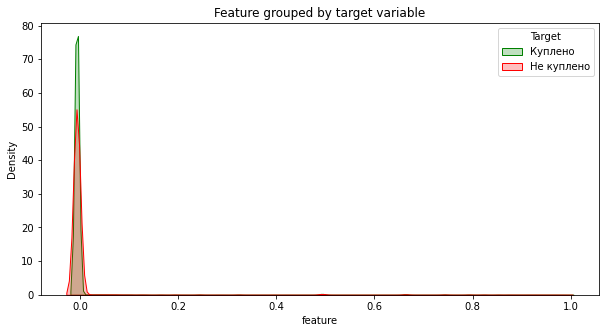

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.08212065696716309, pvalue=0.0)


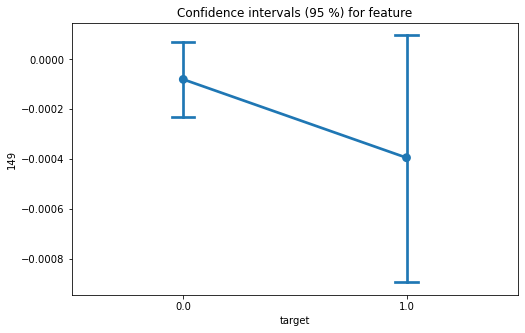

Оценка признака feature = 212


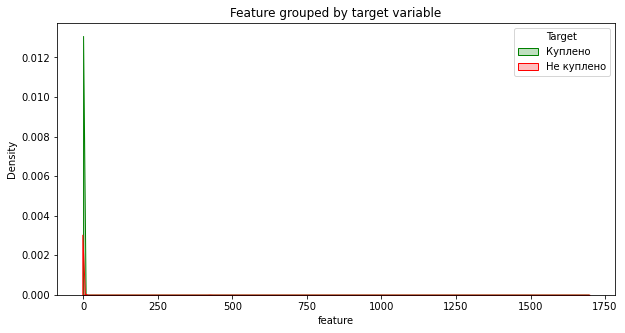

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.008250951766967773, pvalue=0.0)


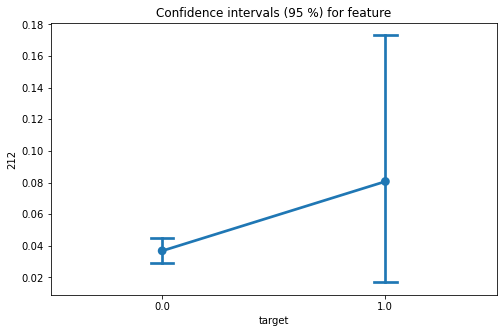

Оценка признака feature = 20


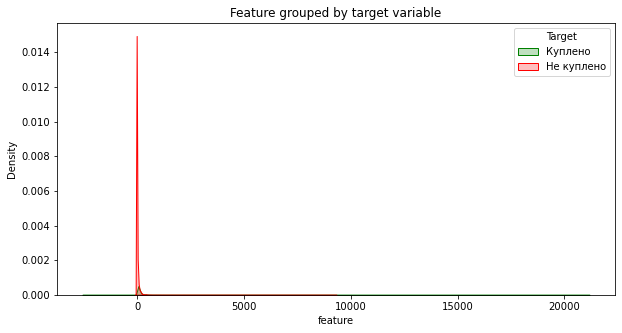

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.19933682680130005, pvalue=0.0)


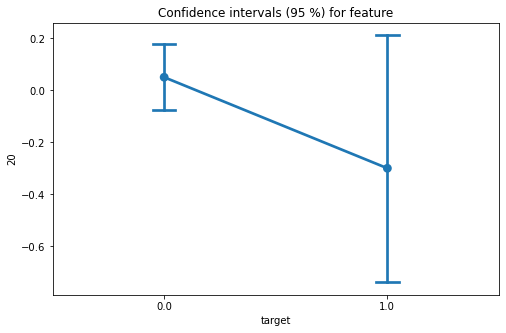

Оценка признака feature = 231


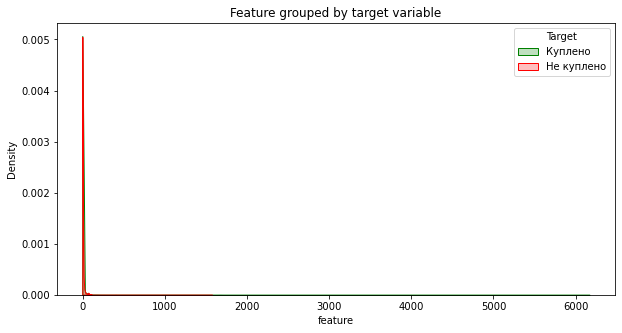

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0063343048095703125, pvalue=0.0)


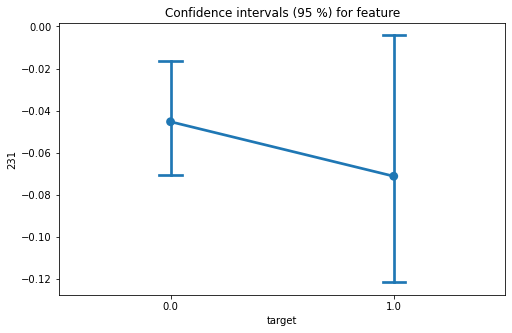

Оценка признака feature = 126


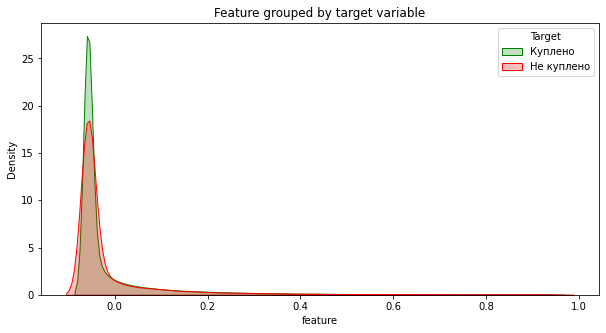

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.4782336950302124, pvalue=0.0)


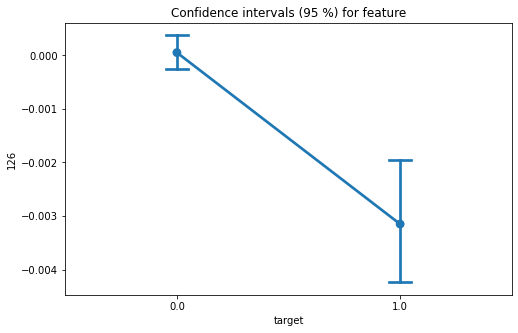

Оценка признака feature = 156


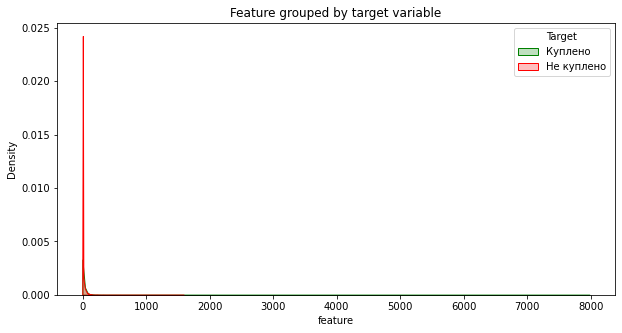

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.11047613620758057, pvalue=0.0)


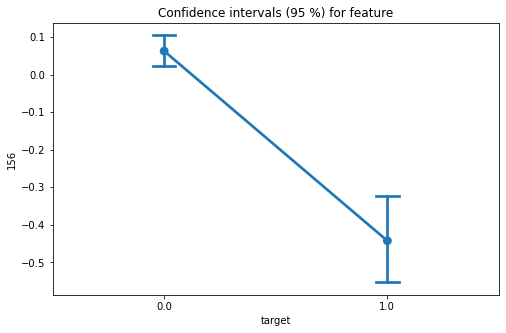

Оценка признака feature = 120


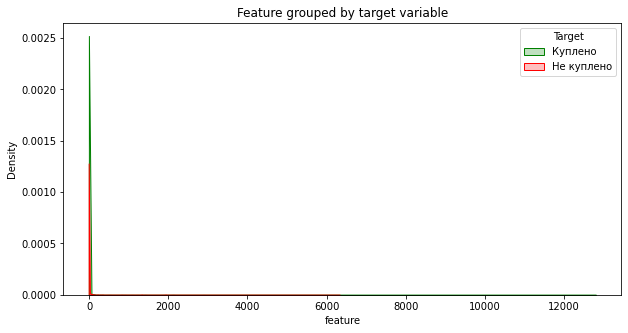

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.0021268129348754883, pvalue=0.0)


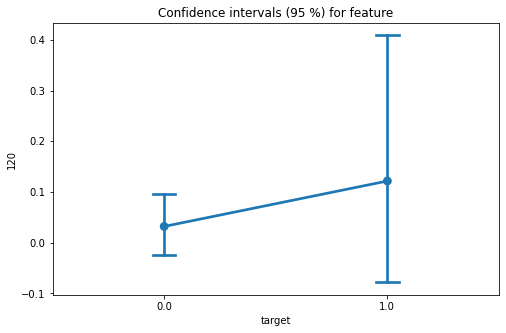

Оценка признака feature = 190


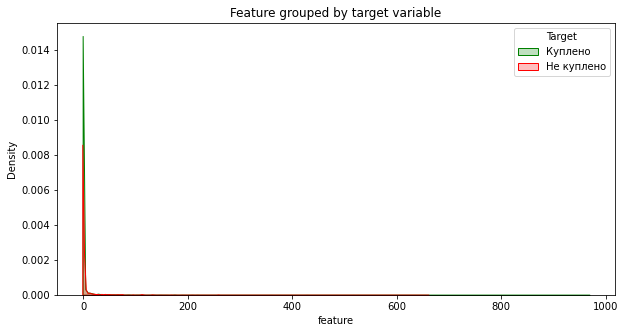

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.013753354549407959, pvalue=0.0)


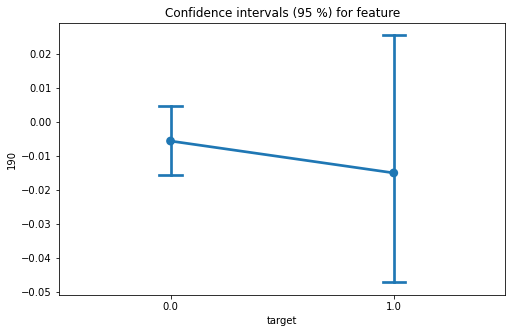

Оценка признака feature = 110


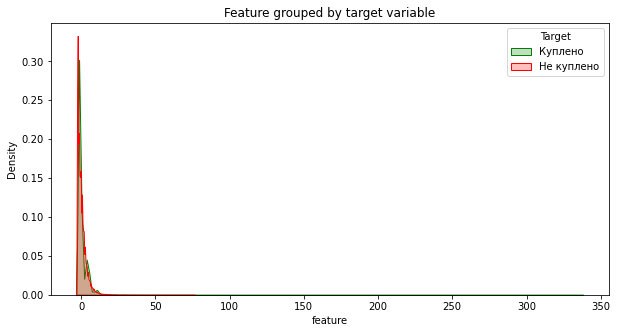

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Критерий Шапиро-Уилка для признака: ShapiroResult(statistic=0.689197301864624, pvalue=0.0)


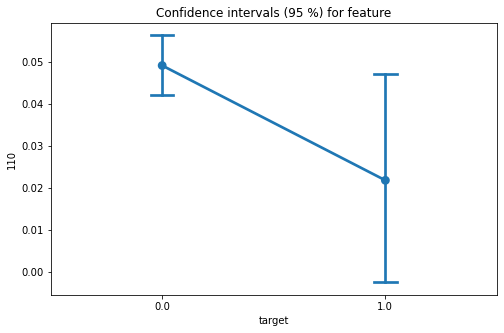

In [57]:
%time

for feature in (features_numeric | {'year', 'month', 'day', 'id', 'vas_id'}) :
    print(f'Оценка признака feature = {feature}')
    feature_with_target = pd.concat([X[feature], y], axis=1)
    feature = feature_with_target[feature]
    feature_target_0 = feature[feature_with_target['target'] == 0]
    feature_target_1 = feature[feature_with_target['target'] == 1]
    
    plt.figure(figsize=(10, 5))
    
    sns.kdeplot(feature_target_0, shade=True, label='Куплено', color='g')
    sns.kdeplot(feature_target_1, shade=True, label='Не куплено', color='r')
    
    plt.xlabel('feature')
    plt.title('Feature grouped by target variable')
    plt.legend(title='Target', loc='upper right')
 
    plt.show()
    
    # Проверяем распределения на нормальность
    print(f'Критерий Шапиро-Уилка для признака: {shapiro(feature)}')
    
    #Строим доверительные интервалы
    plt.figure(figsize=(8, 5))

    sns.pointplot(x='target', y=feature, data=feature_with_target, capsize=.1)

    plt.title('Confidence intervals (95 %) for feature')
    plt.show()

Не брать в обучение (средние значения в выборках равны): \
'11', '12', '13', '14', '15', '19',
'20', '22', '24', '28',
'36', '38', 
'43', '44', '45', '46', '47', '48',
'54', '55', '56',
'64', '69', 
'70', '72', '73', '74', '76', '77',
'82', '84', '89',
'90', '93', '95', '98', '99', 
'103', '104', '105', '106', '108', '109',
'114', '116', '117', '119',
'120', '121', '125', '129',
'130',
'149', 
'153', '157',
'161', '162', '163', '165', '166', '167',
'170', '172', '175', '176', '179',
'180', '182', '184', '186', '189', 
'190', '193', 
'208',
'211', '212', '213',
'221', '225', '229', 
'231', '232', '235', '236', '238', 
'240', '242', '245', '248',     
'251', '252'

In [58]:
# Собираем признаки, которые не надо использовать

do_not_use = [
    # убираем константные признаки
    '75', '81', '85', '139', '203',
    # убираем категориальные признаки
    'buy_time',
    '26', '27', '29', '30', '31', '32', '33', '57', '131', '132',
    '154', '192', '194', '195', '196', '197', '198', '199', '200', '201',
    '202', '204', '205', '206', '216',      
    # убираем неполезные признаки (средние значения совпадают)
    '11', '12', '13', '14', '15', '19', '20', '22', '24', '28',
    '36', '38', '43', '44', '45', '46', '47', '48', '54', '55',
    '56', '64', '69', '70', '72', '73', '74', '76', '77', '82',
    '84', '89', '90', '93', '95', '98', '99', '103', '104', '105',
    '106', '108', '109', '114', '116', '117', '119', '120', '121',
    '125', '129', '130', '149', '153', '157', '161', '162', '163',
    '165', '166', '167', '170', '172', '175', '176', '179', '180',
    '182', '184', '186', '189', '190', '193', '208', '211', '212',
    '213', '221', '225', '229', '231', '232', '235', '236', '238',
    '240', '242', '245', '248', '251', '252'
]

In [59]:
selected_features=[x for x in X.columns.to_list() if x not in do_not_use]
print(f'Признаки датасета: {selected_features}')
print(f'Количество признаков: {len(selected_features)}')

#датасет с отобранными признаками
df = X[selected_features]
df.head(2)

Признаки датасета: ['id', 'vas_id', 'year', 'month', 'day', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '16', '17', '18', '21', '23', '25', '34', '35', '37', '39', '40', '41', '42', '49', '50', '51', '52', '53', '58', '59', '60', '61', '62', '63', '65', '66', '67', '68', '71', '78', '79', '80', '83', '86', '87', '88', '91', '92', '94', '96', '97', '100', '101', '102', '107', '110', '111', '112', '113', '115', '118', '122', '123', '124', '126', '127', '128', '133', '134', '135', '136', '137', '138', '140', '141', '142', '143', '144', '145', '146', '147', '148', '150', '151', '152', '155', '156', '158', '159', '160', '164', '168', '169', '171', '173', '174', '177', '178', '181', '183', '185', '187', '188', '191', '207', '209', '210', '214', '215', '217', '218', '219', '220', '222', '223', '224', '226', '227', '228', '230', '233', '234', '237', '239', '241', '243', '244', '246', '247', '249', '250']
Количество признаков: 137


id  vas_id  year  month  day          0           1           2  \
0   2     2.0  2018     12   24 -96.799971  229.530888 -110.740786   
1   4     1.0  2018      8    6 -52.309971 -225.139112  -66.250786   

            3           4  ...        234       237         239         241  \
0  305.723202 -116.158246  ... -35.356505  0.631719 -108.409742    5.382022   
1 -258.246798  -71.668246  ... -35.356505 -5.368281 -108.409742 -106.617978   

           243          244        246         247       249        250  
0  2300.626154  1492.229208 -35.630448  368.252276  7.305572 -12.175933  
1  -977.373846  -613.770792 -37.630448 -304.747724 -0.694428 -12.175933  

[2 rows x 137 columns]

**Вывод:** определены признаки для обучения модели.

#### 2.3. Подбор моделей. Получение бейзлайна <a class="anchor" id="part2.3"></a><center>

#### 2.3.1. Разделение датасета data_train на тренировочный и валидационный <a class="anchor" id="part2.3.1"></a><center>

In [60]:
#датасет для обучения модели
df.head(2)

id  vas_id  year  month  day          0           1           2  \
0   2     2.0  2018     12   24 -96.799971  229.530888 -110.740786   
1   4     1.0  2018      8    6 -52.309971 -225.139112  -66.250786   

            3           4  ...        234       237         239         241  \
0  305.723202 -116.158246  ... -35.356505  0.631719 -108.409742    5.382022   
1 -258.246798  -71.668246  ... -35.356505 -5.368281 -108.409742 -106.617978   

           243          244        246         247       249        250  
0  2300.626154  1492.229208 -35.630448  368.252276  7.305572 -12.175933  
1  -977.373846  -613.770792 -37.630448 -304.747724 -0.694428 -12.175933  

[2 rows x 137 columns]

In [61]:
# Разбиваем датасет на тренировочный и валидационный
X_train, X_test, y_train, y_test = train_test_split(df, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)
print(X_train.shape, X_test.shape)
display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

(582157, 137) (249496, 137)


0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

0.0    0.92763
1.0    0.07237
Name: target, dtype: float64

In [62]:
#считаем дисбаланс
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

12.818110610016616

In [63]:
#списки для оценок значений f1_macro на кроссвалидации
a_scores = []
b_scores = []

#### 2.3.2. CatBoostClassifier <a class="anchor" id="part2.3.2"></a><center>

In [64]:
model_catb = catb.CatBoostClassifier(silent=True, 
                                     random_state=21,
                                     class_weights=[1, disbalance],
                                     eval_metric='F1',
                                     early_stopping_rounds=20
                                     )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92    540027
         1.0       0.35      0.91      0.50     42130

    accuracy                           0.87    582157
   macro avg       0.67      0.89      0.71    582157
weighted avg       0.95      0.87      0.89    582157

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.92    231440
         1.0       0.35      0.91      0.50     18056

    accuracy                           0.87    249496
   macro avg       0.67      0.89      0.71    249496
weighted avg       0.95      0.87      0.89    249496

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     200484  30956
1.0       1646  16410


Кроссвалидация

In [65]:
%%time

scores = cross_val_score(
    model_catb,
    df, #датасет с признаками до разбивки на train и test
    y, #целевая переменная
    scoring='f1_macro',
    cv=KFold(n_splits=5, shuffle=True, random_state=1)
)
print(f'Scores: {scores}')
a_scores.append(scores.mean() - scores.std())
b_scores.append(scores.mean() + scores.std())
scores.mean() - scores.std(), scores.mean() + scores.std()

Scores: [0.71859049 0.71748811 0.71874575 0.71886995 0.71689904]
Wall time: 18min 11s


(0.7173356766655149, 0.7189016568767107)

**Вывод:** модель model_catb стабильная, оценка f1_macro > 0,717.

#### 2.3.3. XGBClassifier <a class="anchor" id="part2.3.3"></a><center>

In [66]:
#выполняем балансировку Oversampling (SMOTE)
smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

y_train_balanced.value_counts()

1.0    540027
0.0    540027
Name: target, dtype: int64

In [67]:
model_xgb = XGBClassifier(random_state=21,
                          objective = 'binary:logistic')

model_xgb.fit(X_train_balanced, y_train_balanced)

evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:39:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97    540027
         1.0       0.98      0.95      0.97    540027

    accuracy                           0.97   1080054
   macro avg       0.97      0.97      0.97   1080054
weighted avg       0.97      0.97      0.97   1080054

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97    231440
         1.0       0.58      0.36      0.44     18056

    accuracy                           0.93    249496
   macro avg       0.76      0.67      0.70    249496
weighted avg       0.92      0.93      0.93    249496

CONFUSION MATRIX

col_0

Кроссвалидация

In [68]:
%%time

scores = cross_val_score(
    model_xgb,
    df, #датасет с признаками до разбивки на train и test
    y, #целевая переменная
    scoring='f1_macro',
    cv=KFold(n_splits=5, shuffle=True, random_state=1)
)
print(f'Scores: {scores}')
a_scores.append(scores.mean() - scores.std())
b_scores.append(scores.mean() + scores.std())
scores.mean() - scores.std(), scores.mean() + scores.std()

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:52:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:54:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores: [0.68309745 0.68305417 0.68104203 0.67856568 0.68242044]
Wall time: 13min 1s


(0.6799305508477663, 0.6833413604192485)

**Вывод:** модель model_xgb стабильная, оценка f1_macro > 0,67.

#### 2.3.4. LGBMClassifier <a class="anchor" id="part2.3.4"></a><center>

In [69]:
model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:1, 1:disbalance}
                                )

model_lgbm.fit(X_train, y_train)

evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    540027
         1.0       0.35      0.91      0.50     42130

    accuracy                           0.87    582157
   macro avg       0.67      0.89      0.72    582157
weighted avg       0.95      0.87      0.90    582157

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.87      0.93    231440
         1.0       0.35      0.91      0.50     18056

    accuracy                           0.87    249496
   macro avg       0.67      0.89      0.71    249496
weighted avg       0.95      0.87      0.89    249496

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     200768  30672
1.0       1664  16392


Кроссвалидация

In [70]:
%%time

scores = cross_val_score(
    model_lgbm,
    df, #датасет с признаками до разбивки на train и test
    y, #целевая переменная
    scoring='f1_macro',
    cv=KFold(n_splits=5, shuffle=True, random_state=1)
)
print(f'Scores: {scores}')
a_scores.append(scores.mean() - scores.std())
b_scores.append(scores.mean() + scores.std())
scores.mean() - scores.std(), scores.mean() + scores.std()

Scores: [0.71529132 0.71369998 0.71389544 0.7148887  0.71284773]
Wall time: 54.8 s


(0.7132519040273755, 0.714997362648228)

**Вывод:** модель model_lgbm стабильная, оценка f1_macro > 0,713.

#### 2.3.5. DecisionTreeClassifier <a class="anchor" id="part2.3.5"></a><center>

In [71]:
model_tree = DecisionTreeClassifier(random_state=21,
                                   class_weight={0:1, 1:disbalance})

model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    540027
         1.0       1.00      1.00      1.00     42130

    accuracy                           1.00    582157
   macro avg       1.00      1.00      1.00    582157
weighted avg       1.00      1.00      1.00    582157

TEST

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95    231440
         1.0       0.40      0.39      0.39     18056

    accuracy                           0.91    249496
   macro avg       0.68      0.67      0.67    249496
weighted avg       0.91      0.91      0.91    249496

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     221034  10406
1.0      11102   6954


Кроссвалидация

In [72]:
%%time

scores = cross_val_score(
    model_tree,
    df, #датасет с признаками до разбивки на train и test
    y, #целевая переменная
    scoring='f1_macro',
    cv=KFold(n_splits=5, shuffle=True, random_state=1)
)
print(f'Scores: {scores}')
a_scores.append(scores.mean() - scores.std())
b_scores.append(scores.mean() + scores.std())
scores.mean() - scores.std(), scores.mean() + scores.std()

Scores: [0.67268667 0.67235064 0.67294524 0.67109476 0.67203252]
Wall time: 6min 40s


(0.6715797620113001, 0.6728641630679536)

**Вывод:** модель model_tree стабильная, оценка f1_macro > 0,671.

#### 2.3.6. Сводная таблица метрик моделей <a class="anchor" id="part2.3.6"></a><center>

In [73]:
train_scores = []
test_scores = []

for model in [model_catb, model_xgb, model_lgbm, model_tree]:
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_score = f1_score(y_train, train_pred, average='macro')
    train_scores.append(train_score)
    test_score = f1_score(y_test, test_pred, average='macro')
    test_scores.append(test_score)

pd.DataFrame({'model': ['model_catb', 'model_xgb', 'model_lgbm', 'model_tree'], 
              'train_score_f1': train_scores, 
              'test_score_f1': test_scores,
              'scores.mean() - scores.std()': a_scores,
              'scores.mean() + scores.std()': b_scores})

model  train_score_f1  test_score_f1  scores.mean() - scores.std()  \
0  model_catb        0.713551       0.713236                      0.717336   
1   model_xgb        0.734999       0.703974                      0.679931   
2  model_lgbm        0.715044       0.714455                      0.713252   
3  model_tree        1.000000       0.673154                      0.671580   

   scores.mean() + scores.std()  
0                      0.718902  
1                      0.683341  
2                      0.714997  
3                      0.672864

**Вывод:** модель с лучшей оценкой f1_marco avg на test -- LGBMClassifier

#### 2.4. Выбор лучшей модели. Настройка гиперпараметров <a class="anchor" id="part2.4"></a><center>

Настроим гиперпараметры модели LGBMClassifier

In [109]:
frozen_params = {'is_unbalance': [True], 
                 'n_jobs': -1,
                 'random_state':21,
                 'objective': 'binary'
                }

params = {'num_leaves': [30, 40, 50, 100],
          'max_depth': [5, 10, 15, 20],
          'n_estimators': [500, 700, 1000, 1500, 2000]
         }

model_grid = lgbm.LGBMClassifier(**frozen_params)

cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

f1 = make_scorer(f1_score , average='macro')

In [110]:
%%time

grid_search = GridSearchCV(estimator=model_grid,
                            param_grid=params, 
                            cv=cv,
                            n_jobs=-1, 
                            refit=True,
                            verbose=2,
                            scoring=f1)

grid_search.fit(X_train, y_train)

grid_search.best_score_, grid_search.best_params_

Fitting 3 folds for each of 80 candidates, totalling 240 fits
Wall time: 2h 10min 16s


(0.7362145080838719,
 {'max_depth': 20, 'n_estimators': 1500, 'num_leaves': 100})

In [111]:
#модель с параметрами grid_search
params_2 = {'reg_lambda' : [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

model_grid = lgbm.LGBMClassifier(random_state=21, 
                            class_weight='balanced',
                            objective='binary',
                            max_depth=grid_search.best_params_['max_depth'],
                            n_estimators=grid_search.best_params_['n_estimators'],
                            num_leaves=grid_search.best_params_['num_leaves']
                           )

grid_search_2 = GridSearchCV(estimator=model_grid,
                            param_grid=params_2, 
                            cv=cv,
                            n_jobs=-1, 
                            refit=True,
                            verbose=2,
                            scoring=f1)

grid_search_2.fit(X_train, y_train)

grid_search_2.best_score_, grid_search_2.best_params_

Fitting 3 folds for each of 7 candidates, totalling 21 fits


(0.7396269563344241, {'reg_lambda': 1})

In [112]:
model_grid = lgbm.LGBMClassifier(random_state=21, 
                            class_weight='balanced',
                            objective='binary',
                            max_depth=grid_search.best_params_['max_depth'],
                            n_estimators=grid_search.best_params_['n_estimators'],
                            num_leaves=grid_search.best_params_['num_leaves'],
                            reg_lambda=grid_search_2.best_params_['reg_lambda']
                           )
model_grid.fit(X_train, y_train)

evaluate_preds(model_grid, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98    540027
         1.0       0.62      1.00      0.76     42130

    accuracy                           0.96    582157
   macro avg       0.81      0.98      0.87    582157
weighted avg       0.97      0.96      0.96    582157

TEST

              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95    231440
         1.0       0.41      0.73      0.52     18056

    accuracy                           0.90    249496
   macro avg       0.69      0.82      0.74    249496
weighted avg       0.94      0.90      0.92    249496

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     212516  18924
1.0       4900  13156


In [113]:
train_predict_grid = model_grid.predict(X_train)
test_predict_grid = model_grid.predict(X_test)
    
train_f1_grid = f1_score(y_train, train_predict_grid, average='macro')

test_f1_grid = f1_score(y_test, test_predict_grid, average='macro')

train_f1_grid, test_f1_grid

(0.8689673111662373, 0.7358676769123997)

Модель переобучена. В дальнейшем, при определении оптимального порога вероятности определения класса, переобучение становится еще более существенным.

In [80]:
%%time
#модель с параметрами, подобранными вручную
model = lgbm.LGBMClassifier(random_state=21, 
                            class_weight='balanced',
                            objective='binary',
                            max_depth=10,
                            n_estimators=1000,
                            num_leaves=40,
                            reg_lambda=0.5)

model.fit(X_train, y_train)

evaluate_preds(model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94    540027
         1.0       0.40      0.96      0.56     42130

    accuracy                           0.89    582157
   macro avg       0.70      0.92      0.75    582157
weighted avg       0.95      0.89      0.91    582157

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    231440
         1.0       0.36      0.87      0.51     18056

    accuracy                           0.88    249496
   macro avg       0.68      0.88      0.72    249496
weighted avg       0.94      0.88      0.90    249496

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     203713  27727
1.0       2345  15711
Wall time: 48.6 s


In [81]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
    
train_f1 = f1_score(y_train, train_predict, average='macro')

test_f1 = f1_score(y_test, test_predict, average='macro')

train_f1, test_f1

(0.7519431910896117, 0.7211201832143102)

**Вывод:** лучшие параметры модели LGBMClassifier:\
max_depth=10,\
n_estimators=1000, \
num_leaves=40,\
reg_lambda=0.5

P.S. Модель с параметрами, подобранными вручную дает лучшую метрику, чем с параметрами grid search (у последней переобучение).

#### 2.5. Перекрестная проверка (Cross-validation)  <a class="anchor" id="part2.5"></a><center>

In [82]:
%%time

scores = cross_val_score(
    model,
    df, #датасет с признаками до разбивки на train и test
    y, #целевая переменная
    scoring='f1_macro',
    cv=KFold(n_splits=5, shuffle=True, random_state=1)
)
print(f'Scores: {scores}')
scores.mean() - scores.std(), scores.mean() + scores.std()

Scores: [0.72077577 0.71978797 0.72240001 0.7220546  0.71995357]
Wall time: 3min 25s


(0.7199279543481911, 0.7220608182240646)

**Вывод:** модель с подобранными параметрами стабильная, оценка f1_macro > 0,719.

#### 2.6. Определение оптимального порога предсказания класса <a class="anchor" id="part2.6"></a><center>

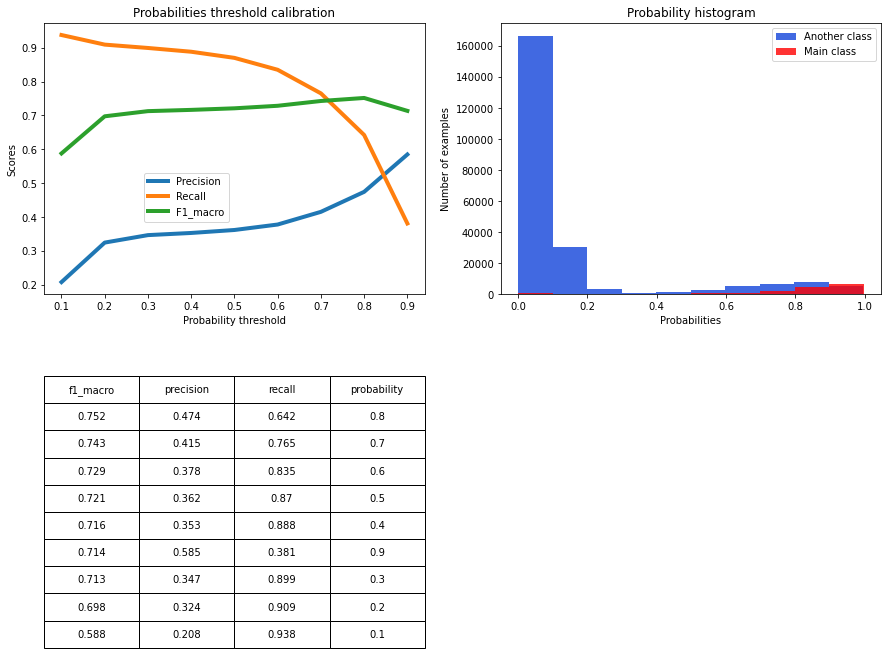

In [83]:
y_test_pred_probs = model.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

**Вывод:** лучшая отсечка 0,8.

In [84]:
# Делаем предсказание класса
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_test)

# Считаем метрику f1
f1_train = f1_score(y_train, y_train_preds, average='macro')
f1_test = f1_score(y_test, y_test_preds, average='macro')
print(f'f1_macro на train {f1_train}')
print(f'f1_macro на test {f1_test}')

f1_macro на train 0.7519431910896117
f1_macro на test 0.7211201832143102


In [85]:
# Предсказываем вероятности классов (0 и 1 соответственно)
y_train_preds_proba = model.predict_proba(X_train)

# Предсказываем вероятности классов (0 и 1 соответственно)
y_test_preds_proba = model.predict_proba(X_test)

In [86]:
# Меняем отсечку в большую сторону (чтобы увеличить точность)
y_train_preds = np.where(y_train_preds_proba[:, 1] >= 0.8, 1, 0)

# Меняем отсечку в большую сторону (чтобы увеличить точность)
y_test_preds = np.where(y_test_preds_proba[:, 1] >= 0.8, 1, 0)

# Считаем метрику f1
f1_train = f1_score(y_train, y_train_preds, average='macro')
f1_test = f1_score(y_test, y_test_preds, average='macro')
print(f'f1_macro на train {f1_train}')
print(f'f1_macro на test {f1_test}')

f1_macro на train 0.8261084731153342
f1_macro на test 0.751707927219625


#### 2.7. Важность признаков<a class="anchor" id="part2.7"></a><center>

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


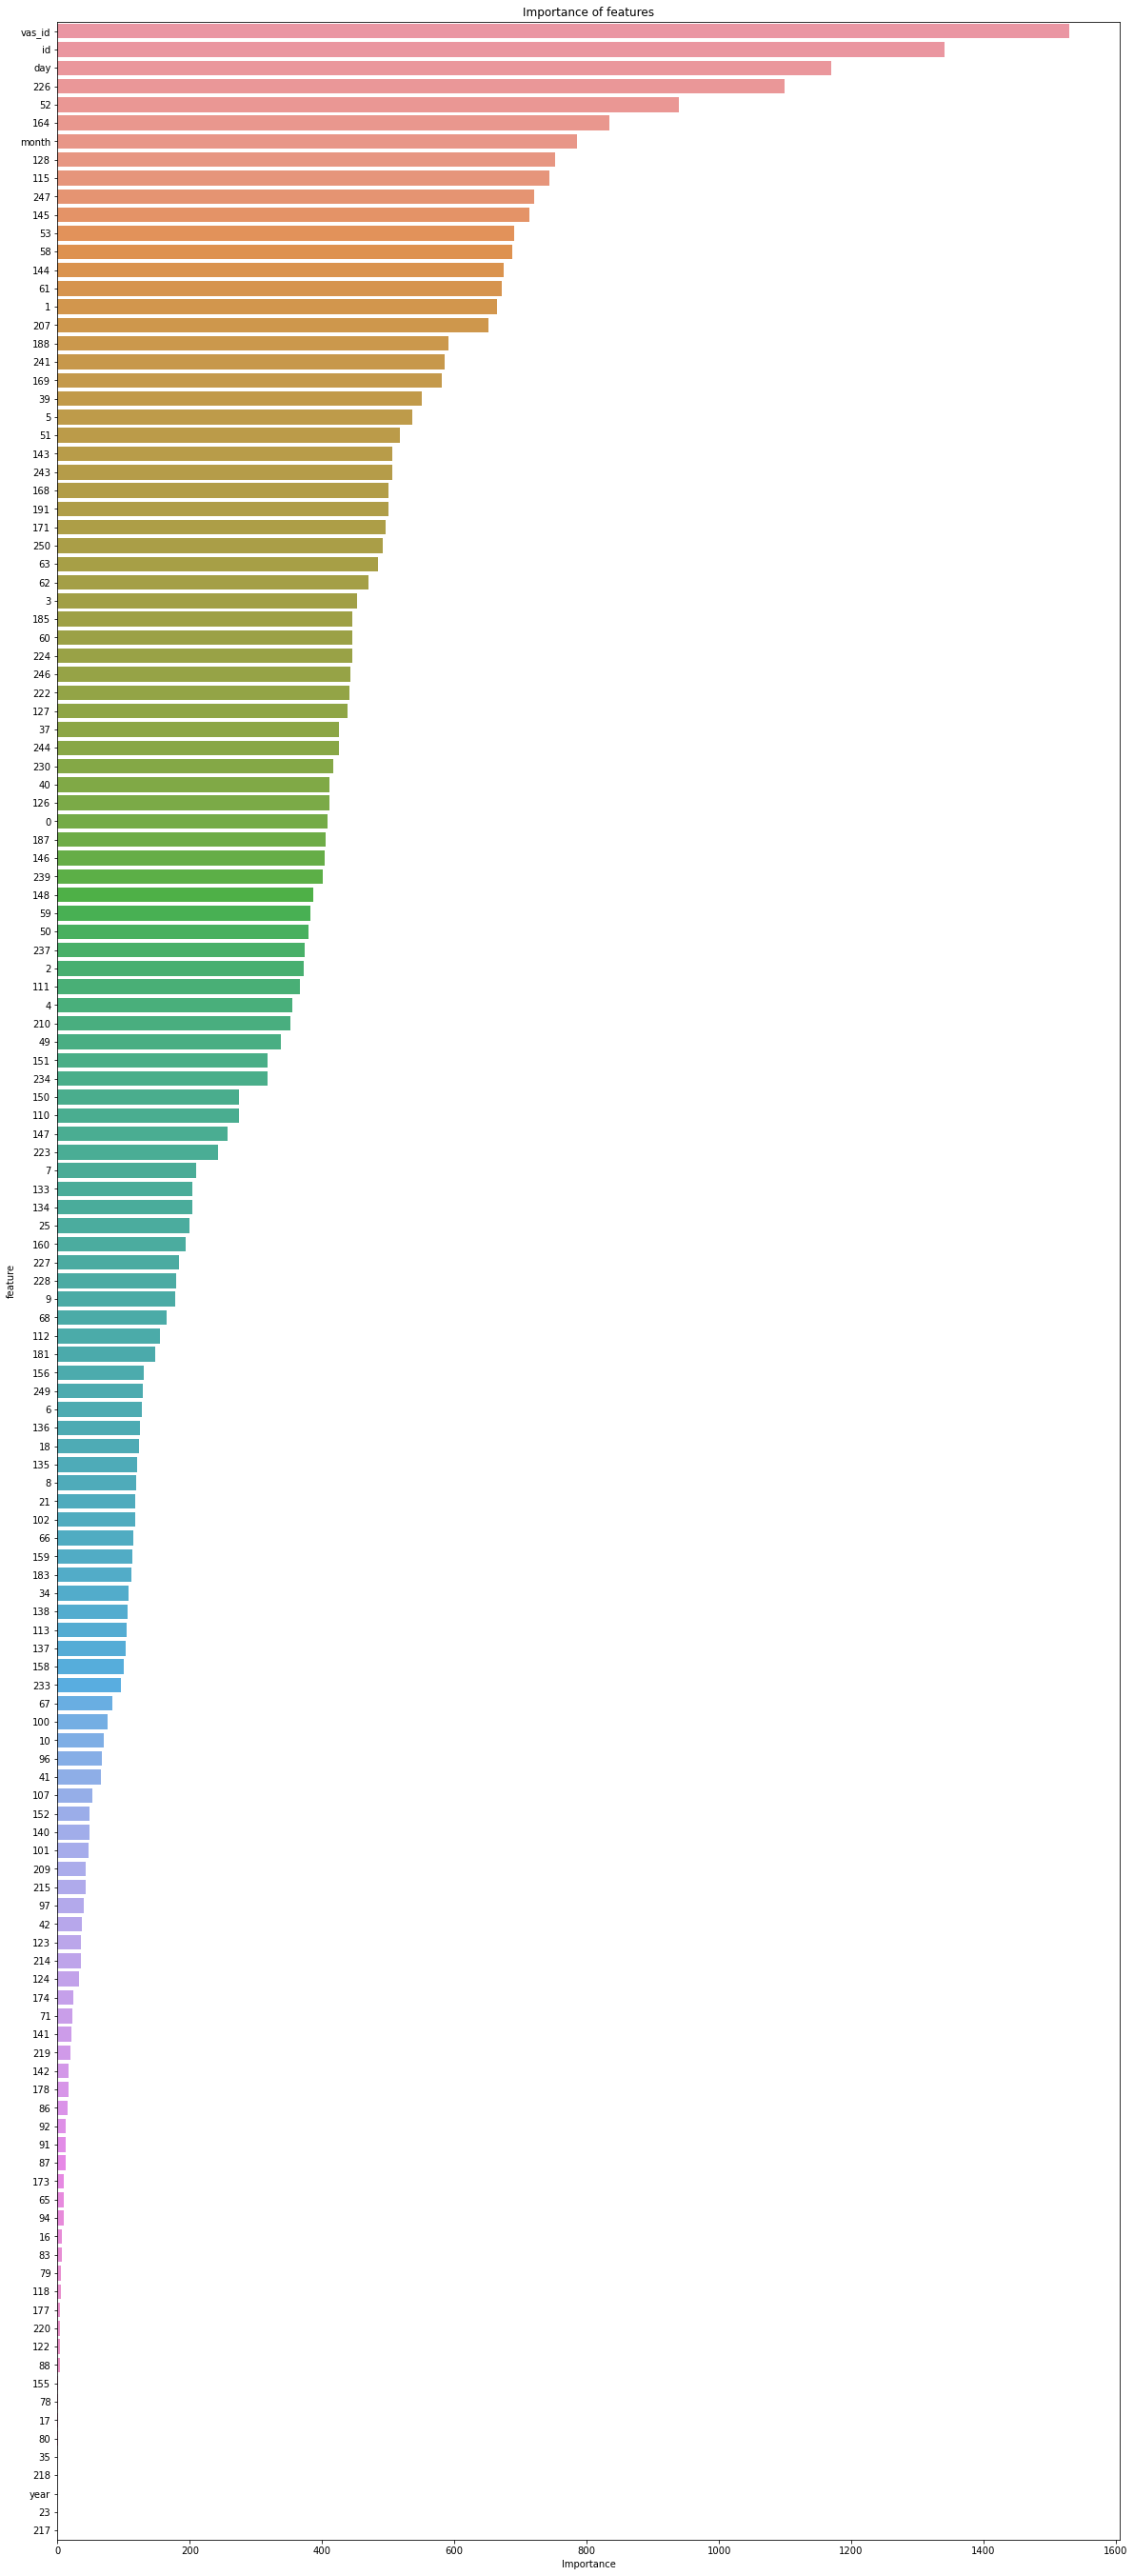

In [87]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top=126)

In [88]:
important_features_top

['vas_id',
 'id',
 'day',
 '226',
 '52',
 '164',
 'month',
 '128',
 '115',
 '247',
 '145',
 '53',
 '58',
 '144',
 '61',
 '1',
 '207',
 '188',
 '241',
 '169',
 '39',
 '5',
 '51',
 '143',
 '243',
 '168',
 '191',
 '171',
 '250',
 '63',
 '62',
 '3',
 '185',
 '60',
 '224',
 '246',
 '222',
 '127',
 '37',
 '244',
 '230',
 '40',
 '126',
 '0',
 '187',
 '146',
 '239',
 '148',
 '59',
 '50',
 '237',
 '2',
 '111',
 '4',
 '210',
 '49',
 '151',
 '234',
 '150',
 '110',
 '147',
 '223',
 '7',
 '133',
 '134',
 '25',
 '160',
 '227',
 '228',
 '9',
 '68',
 '112',
 '181',
 '156',
 '249',
 '6',
 '136',
 '18',
 '135',
 '8',
 '21',
 '102',
 '66',
 '159',
 '183',
 '34',
 '138',
 '113',
 '137',
 '158',
 '233',
 '67',
 '100',
 '10',
 '96',
 '41',
 '107',
 '152',
 '140',
 '101',
 '209',
 '215',
 '97',
 '42',
 '123',
 '214',
 '124',
 '174',
 '71',
 '141',
 '219',
 '142',
 '178',
 '86',
 '92',
 '91',
 '87',
 '173',
 '65',
 '94',
 '16',
 '83',
 '79',
 '118',
 '177',
 '220']

**Вывод:** выбрано 126 наиболее важных признаков из общего количества (именно в таком количестве достигается лучшая оценка на test).

#### 2.8. Получение  и сохранение итоговой модели <a class="anchor" id="part2.8"></a><center>

In [89]:
final_model = lgbm.LGBMClassifier(random_state=21, 
                            class_weight='balanced',
                            objective='binary',
                            max_depth=10,
                            n_estimators=1000,
                            num_leaves=40,
                            reg_lambda=0.5
                           )
final_model.fit(X_train[important_features_top], y_train)

evaluate_preds(final_model, X_train[important_features_top], X_test[important_features_top], y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.89      0.94    540027
         1.0       0.40      0.96      0.56     42130

    accuracy                           0.89    582157
   macro avg       0.70      0.92      0.75    582157
weighted avg       0.95      0.89      0.91    582157

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.88      0.93    231440
         1.0       0.36      0.87      0.51     18056

    accuracy                           0.88    249496
   macro avg       0.68      0.88      0.72    249496
weighted avg       0.94      0.88      0.90    249496

CONFUSION MATRIX

col_0      0.0    1.0
target               
0.0     203704  27736
1.0       2334  15722


Кроссвалидация

In [90]:
%%time

scores = cross_val_score(
    final_model,
    df[important_features_top], #датасет с признаками до разбивки на train и test
    y, #целевая переменная
    scoring='f1_macro',
    cv=KFold(n_splits=5, shuffle=True, random_state=1)
)
print(f'Scores: {scores}')
scores.mean() - scores.std(), scores.mean() + scores.std()

Scores: [0.72055562 0.71950905 0.72134358 0.72152131 0.71969607]
0.7197025755969458 0.7213476719077391
Wall time: 3min 20s


Предсказание модели

In [91]:
# Делаем предсказание класса
y_train_preds = final_model.predict(X_train[important_features_top])
y_test_preds = final_model.predict(X_test[important_features_top])

# Считаем метрику f1
f1_train = f1_score(y_train, y_train_preds, average='macro')
f1_test = f1_score(y_test, y_test_preds, average='macro')
print(f'f1_macro на train {f1_train}')
print(f'f1_macro на test {f1_test}')

f1_macro на train 0.7518948043894184
f1_macro на test 0.721216652200527


In [92]:
# Предсказываем вероятности классов (0 и 1 соответственно)
y_train_preds_proba = final_model.predict_proba(X_train[important_features_top])

# Предсказываем вероятности классов (0 и 1 соответственно)
y_test_preds_proba = final_model.predict_proba(X_test[important_features_top])

In [93]:
# Меняем отсечку в большую сторону
y_train_preds = np.where(y_train_preds_proba[:, 1] >= 0.8, 1, 0)

# Меняем отсечку в большую сторону
y_test_preds = np.where(y_test_preds_proba[:, 1] >= 0.8, 1, 0)

# Считаем метрику f1
f1_train = f1_score(y_train, y_train_preds, average='macro')
f1_test = f1_score(y_test, y_test_preds, average='macro')
print(f'f1_macro на train {f1_train}')
print(f'f1_macro на test {f1_test}')

f1_macro на train 0.8260610804103954
f1_macro на test 0.7522575067938254


Сохранение итоговой модели

In [94]:
with open('final_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

**Вывод:** итоговая модель обучена на признаках, отобранных по важности, и сохранена.

### 3. Прогнозирование на тестовом датасете<a class="anchor" id="part3"></a><center>

#### 3.1. Подготовка датасета для предсказания <a class="anchor" id="part3.1"></a><center>

In [95]:
data_test.head(3)

id  vas_id    buy_time  year  month  day
0  3130519     2.0  2019-01-21  2019      1   21
1  2000860     4.0  2019-01-21  2019      1   21
2  1099444     2.0  2019-01-07  2019      1    7

In [96]:
features.head(3)

id    buy_time          0           1           2           3  \
0  2013026  2018-07-16  18.910029   46.980888    4.969214   -1.386798   
1  2014722  2018-10-15  36.690029  152.400888  448.069214  563.833202   
2  2015199  2018-12-24 -67.019971  157.050888  -63.180786  178.103202   

            4          5         6          7  ...         243         244  \
0    3.791754  -14.01179 -16.08618 -65.076097  ... -977.373846 -613.770792   
1  463.841754  568.99821 -16.08618 -53.216097  ... -891.373846 -544.770792   
2  -68.598246  156.99821   3.51382  25.183903  ... -977.373846 -613.770792   

         245        246           247        248       249        250  \
0 -25.996269 -37.630448   -301.747724 -25.832889 -0.694428 -12.175933   
1 -20.996269  48.369552     80.252276 -13.832889 -0.694428  -1.175933   
2 -12.996269 -37.630448  10829.252276 -25.832889 -0.694428 -12.175933   

       251  252  
0 -0.45614  0.0  
1 -0.45614  0.0  
2 -0.45614  0.0  

[3 rows x 250 columns]

Соединение датасетов

In [97]:
%%time

X_test_nearest = pd.merge_asof(data_test.sort_values(by=['id']), 
                       features.sort_values(by=['id']), 
                       on='id', 
                       by='buy_time', 
                       direction='nearest')
X_test_nearest.head(2)

Wall time: 27min 5s


id  vas_id    buy_time  year  month  day          0           1  \
0  55     2.0  2019-01-14  2019      1   14 -96.799971 -166.599112   
1  64     4.0  2019-01-21  2019      1   21 -96.799971 -407.009112   

            2           3  ...         243         244        245        246  \
0 -110.740786 -219.206798  ... -970.373846 -610.770792 -24.996269 -34.630448   
1 -110.740786 -459.616798  ... -977.373846 -613.770792 -25.996269 -37.630448   

          247        248       249        250      251  252  
0 -253.747724 -22.832889 -0.694428 -12.175933 -0.45614  1.0  
1 -306.747724 -25.832889 -0.694428 -12.175933 -0.45614  0.0  

[2 rows x 254 columns]

In [98]:
X_test_nearest.isnull().sum()

id          0
vas_id      0
buy_time    0
year        0
month       0
           ..
248         0
249         0
250         0
251         0
252         0
Length: 254, dtype: int64

In [99]:
# Просматриваем тестовый датасет с important_features_top
print(f'Форма тестового датасета с important_features_top: {X_test_nearest[important_features_top].shape}')
X_test_nearest[important_features_top].head(3)

Форма тестового датасета с important_features_top: (71231, 126)


vas_id   id  day        226         52       164  month       128  \
0     2.0   55   14  -0.767334 -32.171711  0.060492      1  0.354871   
1     4.0   64   21  10.149332 -64.171711  0.120492      1 -0.575129   
2     2.0  151   14  -7.225668 -28.171711  0.250492      1  0.114871   

        115         247  ...        87       173        65        94  \
0  0.446143 -253.747724  ... -0.125866 -0.028857 -0.028454 -0.598716   
1 -0.393857 -306.747724  ... -0.125866 -0.028857 -0.028454 -0.598716   
2 -0.003857 -158.747724  ... -0.125866 -0.028857 -0.028454 -0.598716   

         16        83        79       118       177       220  
0 -0.016435 -0.222852 -0.998268 -0.343415 -0.003149 -0.012257  
1 -0.016435 -0.222852 -0.998268 -0.343415 -0.003149 -0.012257  
2 -0.016435 -0.222852 -0.998268 -0.343415 -0.003149 -0.012257  

[3 rows x 126 columns]

**Вывод:** тестовый датасет подготовлен аналогично тренировочному.

#### 3.2. Предсказание класса с помощью итоговой модели <a class="anchor" id="part3.2"></a><center>

In [100]:
# Предсказываем вероятности классов (0 и 1 соответственно)
test_preds_proba = final_model.predict_proba(X_test_nearest[important_features_top])
test_preds_proba[:5]

array([[0.8522544 , 0.1477456 ],
       [0.25631696, 0.74368304],
       [0.99454707, 0.00545293],
       [0.65082697, 0.34917303],
       [0.99720186, 0.00279814]])

In [101]:
# Меняем отсечку на 0,8
test_preds = np.where(test_preds_proba[:, 1] >= 0.8, 1, 0)
test_preds

array([0, 0, 0, ..., 0, 0, 0])

**Вывод:** получено предсказание классов на тестовом датасете.

#### 3.3. Создание и сохранение датасета с прогнозами класса <a class="anchor" id="part3.3"></a><center>

In [102]:
# формируем итоговый датасет
result = pd.DataFrame({
       "id" : X_test_nearest.id.tolist(),
       "vas_id" : X_test_nearest.vas_id.tolist(),
       "buy_time" : X_test_nearest.buy_time.tolist(),
       "target" : test_preds.tolist()})
result

id  vas_id    buy_time  target
0           55     2.0  2019-01-14       0
1           64     4.0  2019-01-21       0
2          151     2.0  2019-01-14       0
3          274     4.0  2019-01-21       0
4          274     2.0  2019-01-14       0
...        ...     ...         ...     ...
71226  4362676     2.0  2019-01-21       0
71227  4362677     2.0  2019-01-14       0
71228  4362697     5.0  2019-01-07       0
71229  4362712     5.0  2019-01-14       0
71230  4362720     2.0  2019-01-07       0

[71231 rows x 4 columns]

In [103]:
result['target'].value_counts()

0    65698
1     5533
Name: target, dtype: int64

Сохранение датасета с предсказаниями

In [104]:
result.to_csv('answers_test_class.csv', index=None)

P.S. Датасет с вероятностями (а не классами) формирует файл predict_test.py

**Вывод:** датасет с результатами собран и сохранен.

### 4. Формирование рекомендаций подключения услуг <a class="anchor" id="part4"></a><center>

#### 4.1. Прогнозирование вероятности подключения каждой услуги каждым пользователем из data_test <a class="anchor" id="part4.1"></a><center>

In [145]:
vas_id_predict = pd.DataFrame(X_test_nearest[important_features_top]['id'].copy())

for i in [1, 2, 3, 4, 5, 6, 7, 8, 9]:
    test_vas_id = pd.DataFrame(X_test_nearest[important_features_top].copy())
    test_vas_id['vas_id'] = i
    vas_id_predict[i] = final_model.predict_proba(test_vas_id)[:,1]

vas_id_predict['max_prob'] = vas_id_predict.iloc[:, 1:-1].max(axis = 1)
vas_id_predict['vas_id_max_prob'] = vas_id_predict.iloc[:, 1:-1].idxmax(axis = 1)
vas_id_predict

id         1         2         3         4         5         6  \
0           55  0.104246  0.147746  0.147746  0.707516  0.106805  0.832372   
1           64  0.162583  0.161608  0.161608  0.743683  0.158476  0.852569   
2          151  0.004107  0.005453  0.005453  0.623994  0.029704  0.745584   
3          274  0.001273  0.001102  0.001102  0.349173  0.009649  0.486087   
4          274  0.002336  0.002798  0.002798  0.574896  0.022765  0.742763   
...        ...       ...       ...       ...       ...       ...       ...   
71226  4362676  0.020714  0.027134  0.027134  0.514915  0.017387  0.734564   
71227  4362677  0.000573  0.000691  0.000691  0.319313  0.002409  0.587547   
71228  4362697  0.000298  0.000314  0.000314  0.158031  0.001239  0.407388   
71229  4362712  0.021990  0.024746  0.024746  0.467377  0.011264  0.742375   
71230  4362720  0.000298  0.000314  0.000314  0.158031  0.001239  0.407388   

              7         8         9  max_prob  vas_id_max_prob  
0      0.030274  0.028534  0.209745  0.832372                6  
1      0.018826  0.014938  0.146008  0.852569                6  
2      0.010856  0.010220  0.188749  0.745584                6  
3      0.001713  0.001296  0.037330  0.486087                6  
4      0.005849  0.005505  0.068046  0.742763                6  
...         ...       ...       ...       ...              ...  
71226  0.005075  0.003937  0.027335  0.734564                6  
71227  0.002588  0.002435  0.039488  0.587547                6  
71228  0.001190  0.001120  0.011403  0.407388                6  
71229  0.004634  0.004361  0.036433  0.742375                6  
71230  0.001190  0.001120  0.011403  0.407388                6  

[71231 rows x 12 columns]

In [146]:
vas_id_predict['max_prob'].describe()

count    71231.000000
mean         0.736024
std          0.137847
min          0.005907
25%          0.686724
50%          0.783434
75%          0.829680
max          0.970095
Name: max_prob, dtype: float64

In [147]:
vas_id_predict['vas_id_max_prob'].value_counts()

6    71126
4      105
Name: vas_id_max_prob, dtype: int64

<AxesSubplot:>

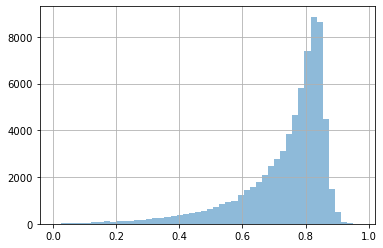

In [151]:
vas_id_predict['max_prob'].hist(bins=50, alpha=0.5)

**Вывод:** пользователям рекомендуются услуги 4 и 6.

#### 4.2. Составление рекомендаций (услуг) пользователям <a class="anchor" id="part4.2"></a><center>

In [148]:
# Датасет с рекомендациями услуг
vas_id_recommended = vas_id_predict[['id', 'vas_id_max_prob']]
vas_id_recommended

id  vas_id_max_prob
0           55                6
1           64                6
2          151                6
3          274                6
4          274                6
...        ...              ...
71226  4362676                6
71227  4362677                6
71228  4362697                6
71229  4362712                6
71230  4362720                6

[71231 rows x 2 columns]

In [149]:
#сохранение датасета с рекомендациями услуг пользователям
vas_id_recommended.to_csv('vas_id_recommended.csv', index=None)

**Вывод:** для более точных рекомендаций необходимо отфильтвровать предлагаемые услуги по вероятности и, возможно, предлагать только те услуги, вероятность покупки которых пользователем более 0.6. 